In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_path = 'dataset_ventes_luxeCed_enriched.csv'
data = pd.read_csv(file_path)
data

Date     Catégorie       Canal de vente  Événement spécial  Mois  \
0      2018-01-01          Mode      Ventes en ligne                  1     1   
1      2018-01-01          Mode  Boutiques physiques                  1     1   
2      2018-01-01          Mode       Ventes privées                  1     1   
3      2018-01-01          Mode      Grands Magasins                  1     1   
4      2018-01-01   Accessoires      Ventes en ligne                  1     1   
...           ...           ...                  ...                ...   ...   
52579  2023-12-31       Montres      Grands Magasins                  1    12   
52580  2023-12-31  Maroquinerie      Ventes en ligne                  1    12   
52581  2023-12-31  Maroquinerie  Boutiques physiques                  1    12   
52582  2023-12-31  Maroquinerie       Ventes privées                  1    12   
52583  2023-12-31  Maroquinerie      Grands Magasins                  1    12   

       Année  Montant des ventes  
0       2018           6761.3520  
1       2018           5969.7480  
2       2018           3458.0640  
3       2018           7871.2920  
4       2018           1630.9680  
...      ...                 ...  
52579   2023           2567.8465  
52580   2023           3104.5745  
52581   2023           2901.4845  
52582   2023           2663.5955  
52583   2023           4469.3255  

[52584 rows x 7 columns]

# **Vérification des valeurs manquantes**

In [ ]:
missing_values = data.isnull().sum()
missing_values

Date                  0
Catégorie             0
Canal de vente        0
Événement spécial     0
Mois                  0
Année                 0
Montant des ventes    0
dtype: int64

# **Nettoyage des données**

## **Valeurs manquantes**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data['Montant des ventes'] = pd.to_numeric(data['Montant des ventes'], errors='coerce')

missing_values_after_conversion = data.isnull().sum()
missing_values_after_conversion


Date                  0
Catégorie             0
Canal de vente        0
Événement spécial     0
Mois                  0
Année                 0
Montant des ventes    0
dtype: int64

Dans le cadre de la première phase du projet, qui consiste à collecter et à préparer des données, une attention particulière a été portée à la vérification des éventuelles valeurs manquantes. Après analyse, on constate qu'aucune valeur manquante n'était présente, ce qui garantit la complétude et l'intégrité initiale des données pour les étapes suivantes.

## **Variables catégorielles**

In [ ]:
categorical_columns = ['Catégorie', 'Canal de vente']


for column in categorical_columns:
    unique_values = data[column].unique()
    print(f"\nValeurs uniques dans '{column}' :\n", unique_values)


Valeurs uniques dans 'Catégorie' :
 ['Mode' 'Accessoires' 'Parfums' 'Joaillerie' 'Montres' 'Maroquinerie']

Valeurs uniques dans 'Canal de vente' :
 ['Ventes en ligne' 'Boutiques physiques' 'Ventes privées'
 'Grands Magasins']


En ce qui concerne les variables catégorielles, une vérification a été réalisée pour s'assurer de la cohérence des valeurs. Aucun problème tel que des fautes d'orthographe, des variations de casse ou des espaces supplémentaires n'a été détecté. Par conséquent , aucune correction n'est nécessaire pour ces colonnes.

## **Vérification temporelle**

In [ ]:
min_date = data['Date'].min()
max_date = data['Date'].max()
unique_years = data['Date'].dt.year.unique()

full_date_range = pd.date_range(start=min_date, end=max_date)

missing_dates = full_date_range.difference(data['Date'])

print(f"Date minimale : {min_date}")
print(f"Date maximale : {max_date}")
print(f"Années couvertes : {unique_years}")
print(f"Nombre de dates manquantes : {missing_dates.size}")

Date minimale : 2018-01-01 00:00:00
Date maximale : 2023-12-31 00:00:00
Années couvertes : [2018 2019 2020 2021 2022 2023]
Nombre de dates manquantes : 0


Dans le cadre de la vérification temporelle des données, une analyse de la plage de dates disponibles a été réalisée afin de garantir leur cohérence et leur intégrité. Les données couvrent une période allant du 1er janvier 2018 au 31 décembre 2023, englobant ainsi les années 2018, 2019, 2020, 2021, 2022 et 2023. Cette vérification a permis de confirmer que toutes les dates situées dans cette période sont bien représentés dans les données, sans aucune omission ni anomalie. Aucune date manquante n'a été détectée, ce qui garantit une couverture temporelle continue et exhaustive, un élément essentiel pour la fiabilité des analyses et du modèle.

## **Détection des doublons**

In [ ]:
duplicated_rows = data[data.duplicated()]

num_duplicates = duplicated_rows.shape[0]

if num_duplicates > 0:
    print("\nExemples de doublons :")
    print(duplicated_rows.head())
else:
    print("\nAucun doublon détecté.")


Aucun doublon détecté.


Une vérification a été menée pour identifier la présence éventuelle de doublons dans les données. Après analyse, il a été constaté qu'aucun doublon n'est présent, ce qui confirme l'unicité et la fiabilité de l'ensemble des enregistrements. Cette absence de doubles assure que les données sont prêtes à être utilisées sans nécessiter d'étapes supplémentaires de nettoyage liées à ce type d'anomalie

## **Détection des valeurs aberrantes**




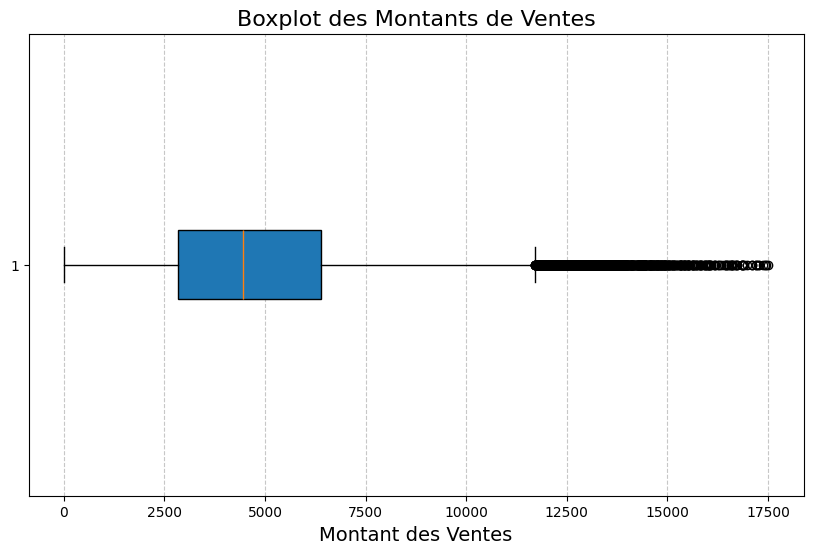

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['Montant des ventes'], vert=False, patch_artist=True)
plt.title('Boxplot des Montants de Ventes', fontsize=16)
plt.xlabel('Montant des Ventes', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
Q1 = data['Montant des ventes'].quantile(0.25)
Q3 = data['Montant des ventes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Seuil inférieur : {lower_bound}")
print(f"Seuil supérieur : {upper_bound}")

outliers = data[(data['Montant des ventes'] < lower_bound) | (data['Montant des ventes'] > upper_bound)]

num_outliers = outliers.shape[0]
print(f"Nombre de valeurs aberrantes détectées : {num_outliers}")

outliers


Seuil inférieur : -2489.261875
Seuil supérieur : 11715.153125
Nombre de valeurs aberrantes détectées : 953


Date     Catégorie       Canal de vente  Événement spécial  Mois  \
228   2018-01-10    Joaillerie      Ventes en ligne                  1     1   
230   2018-01-10    Joaillerie       Ventes privées                  1     1   
253   2018-01-11    Joaillerie  Boutiques physiques                  1     1   
262   2018-01-11  Maroquinerie       Ventes privées                  1     1   
266   2018-01-12          Mode       Ventes privées                  1     1   
...          ...           ...                  ...                ...   ...   
50138 2023-09-21          Mode       Ventes privées                  1     9   
51684 2023-11-24    Joaillerie      Ventes en ligne                  1    11   
51686 2023-11-24    Joaillerie       Ventes privées                  1    11   
51688 2023-11-24       Montres      Ventes en ligne                  1    11   
51690 2023-11-24       Montres       Ventes privées                  1    11   

       Année  Montant des ventes  
228     2018          12873.8760  
230     2018          14156.5200  
253     2018          13028.0280  
262     2018          12779.0760  
266     2018          12613.4160  
...      ...                 ...  
50138   2023          11930.3910  
51684   2023          11858.7375  
51686   2023          11752.0500  
51688   2023          13399.4500  
51690   2023          11785.7500  

[953 rows x 7 columns]

Dans le cadre de la détection des valeurs aberrantes, une analyse a été réalisée à l'aide du boxplot pour examiner les montants des ventes. La majorité des montants se situe entre les quartiles, c'est-à-dire autour de la médiane, reflétant une répartition cohérente des données. Les valeurs dépassant la moustache supérieure ont été identifiées comme des ventes exceptionnellement élevées, tandis qu'aucune valeur aberrante n'a été détectée en dessous de la moustache inférieure. Néanmoins jugées significatives pour notre analyse, car elles pourraient correspondre à des ventes exceptionnelles liées à des événements particuliers. Par conséquent, nous avons décidé de conserver ces valeurs aberrantes pour une exploration plus approfondie lors de l'analyse
exploratoire des données (EDA), afin de mieux comprendre leur nature et leur impact sur les résultats globaux

# **Statistique descrptive**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                52584 non-null  datetime64[ns]
 1   Catégorie           52584 non-null  object        
 2   Canal de vente      52584 non-null  object        
 3   Événement spécial   52584 non-null  int64         
 4   Mois                52584 non-null  int64         
 5   Année               52584 non-null  int64         
 6   Montant des ventes  52584 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [ ]:
sales_summary = data['Montant des ventes'].describe()
sales_summary

count    52584.000000
mean      4794.666463
std       2709.321453
min          0.000000
25%       2837.393750
50%       4461.594250
75%       6388.497500
max      17508.948000
Name: Montant des ventes, dtype: float64

In [ ]:
# sales_data = data['Montant des ventes']

# sales_summary = {
#     'count': len(sales_data),
#     'mean': sum(sales_data) / len(sales_data) if len(sales_data) > 0 else 0,
#     'std': (sum((x - (sum(sales_data) / len(sales_data)))**2 for x in sales_data) / (len(sales_data) - 1))**0.5 if len(sales_data) > 1 else 0,
#     'min': min(sales_data),
#     '25%': sorted(sales_data)[int(len(sales_data) * 0.25)],
#     '50%': sorted(sales_data)[int(len(sales_data) * 0.5)],
#     '75%': sorted(sales_data)[int(len(sales_data) * 0.75)],
#     'max': max(sales_data)
# }

# sales_summary


In [ ]:
data[data['Montant des ventes'] == 0]

Date     Catégorie       Canal de vente  Événement spécial  Mois  \
19345 2020-03-17          Mode  Boutiques physiques                  1     3   
19346 2020-03-17          Mode       Ventes privées                  1     3   
19347 2020-03-17          Mode      Grands Magasins                  1     3   
19349 2020-03-17   Accessoires  Boutiques physiques                  1     3   
19350 2020-03-17   Accessoires       Ventes privées                  1     3   
...          ...           ...                  ...                ...   ...   
29250 2021-05-03       Montres       Ventes privées                  1     5   
29251 2021-05-03       Montres      Grands Magasins                  1     5   
29253 2021-05-03  Maroquinerie  Boutiques physiques                  1     5   
29254 2021-05-03  Maroquinerie       Ventes privées                  1     5   
29255 2021-05-03  Maroquinerie      Grands Magasins                  1     5   

       Année  Montant des ventes  
19345   2020                 0.0  
19346   2020                 0.0  
19347   2020                 0.0  
19349   2020                 0.0  
19350   2020                 0.0  
...      ...                 ...  
29250   2021                 0.0  
29251   2021                 0.0  
29253   2021                 0.0  
29254   2021                 0.0  
29255   2021                 0.0  

[2412 rows x 7 columns]

L'analyse statistique descriptive des données a permis d'obtenir des informations détaillées sur leur qualité, leur structure et leur répartition. Tout d'abord, les données sont complètes, sans valeurs manquantes ni doublons, ce qui garantit une base solide pour les analyses ultérieures. La cohérence des variables et l'intégrité des informations confirment que cet ensemble de données est bien préparé pour les prochaines étapes du projet.

En ce qui concerne la répartition des montants de vente, plusieurs observations intéressantes ont été faites. La médiane, qui s'élève à 4,461.59 , est inférieure à la moyenne de 4,794.67 , ce qui indique une distribution légèrement asymétrique avec un biais vers les valeurs élevées. Cette asymétrie reflète probablement l'impact de quelques ventes exceptionnellement importantes, déjà identifiées comme des valeurs aberrantes significatives.

Un autre point notable concerne les ventes enregistrées à zéro, qui représentent 2 412 cas . Ce volume non négligeable de données nécessite une analyse approfondie pour en comprendre les causes. Plusieurs hypothèses peuvent expliquer ces ventes nulles, notamment des fermetures temporaires liées à des jours fériés, des périodes de confinement ou des restrictions imposées par la pandémie de COVID-19. Une autre possibilité est que ces ventes à zéro soient associées à des catégories spécifiques de produits ou de magasins qui ne génèrent pas de revenus sous certaines conditions.

# **EDA**

## **Analyse de la répartition des variables clés**

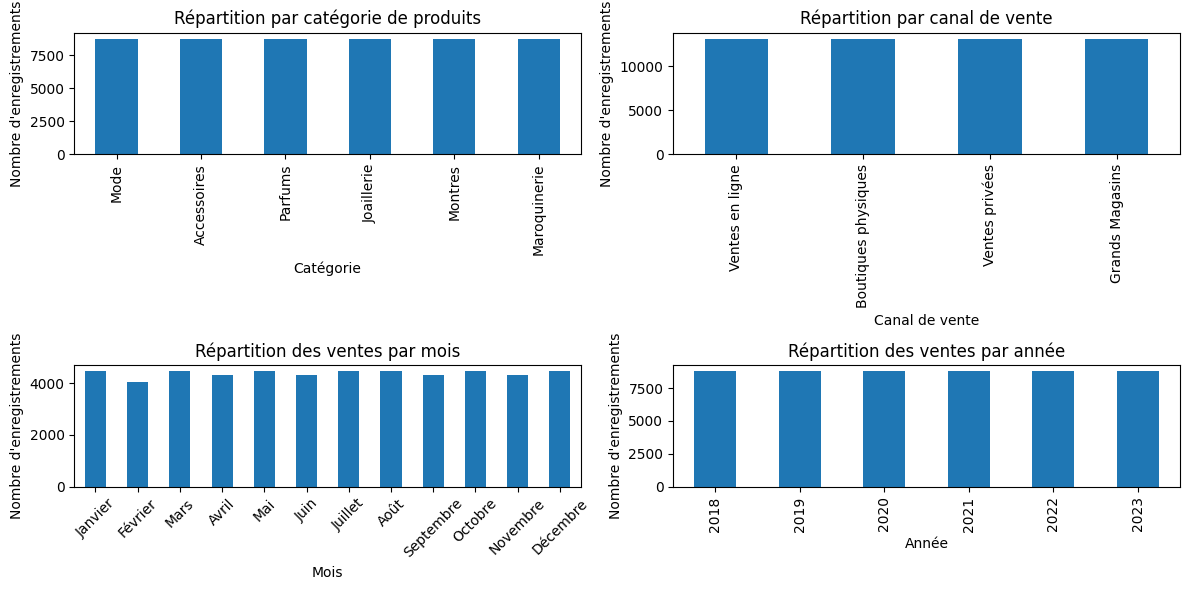

In [ ]:
category_distribution = data['Catégorie'].value_counts()

channel_distribution = data['Canal de vente'].value_counts()

month_distribution = data['Mois'].value_counts().sort_index()
month_distribution.index = month_distribution.index.map(lambda x: calendar.month_name[x])

year_distribution = data['Année'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
category_distribution.plot(kind='bar', title='Répartition par catégorie de produits')
plt.ylabel('Nombre d\'enregistrements')
plt.xlabel('Catégorie')

plt.subplot(2, 2, 2)
channel_distribution.plot(kind='bar', title='Répartition par canal de vente')
plt.ylabel('Nombre d\'enregistrements')
plt.xlabel('Canal de vente')

plt.subplot(2, 2, 3)
month_distribution.plot(kind='bar', title='Répartition des ventes par mois')
plt.ylabel('Nombre d\'enregistrements')
plt.xticks(ticks=range(0, 12), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin",
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.xlabel('Mois')

plt.subplot(2, 2, 4)
year_distribution.plot(kind='bar', title='Répartition des ventes par année')
plt.ylabel('Nombre d\'enregistrements')
plt.xlabel('Année')

plt.tight_layout()
plt.show()


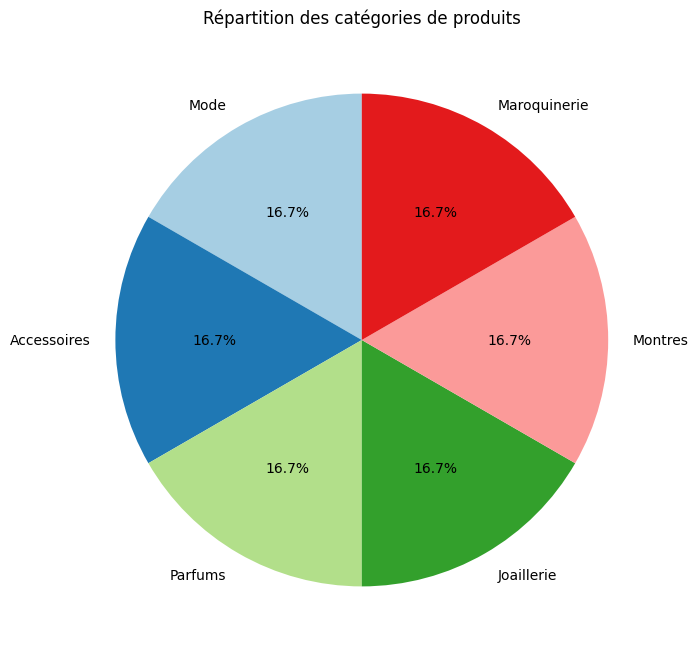

In [ ]:
category_distribution = data['Catégorie'].value_counts()

plt.figure(figsize=(8, 8))
category_distribution.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=category_distribution.index,
    colors=plt.cm.Paired.colors
)
plt.title("Répartition des catégories de produits")
plt.ylabel("")
plt.show()


L'analyse de la répartition des variables clés à travers les quatre graphiques montre une homogénéité significative, suggérant une stratégie équilibrée en termes de diversification des produits, des canaux de vente, ainsi que des volumes répartis par mois et par année. Voici un résumé des principales observations :
1. Répartition par catégorie de produits
Les données montrent une répartition uniforme parmi les catégories principales : Mode, Accessoires, Parfums, Joaillerie, Montres et Maroquinerie. Aucune catégorie ne domine de manière significative, ce qui souligne une diversification réussie du portefeuille de produits. Cette stratégie limite la dépendance à une catégorie unique, impliquant ainsi les risques liés à des fluctuations sectorielles spécifiques.
Cependant, cette diversification peut également constituer une faiblesse potentielle : en se dispersant sur plusieurs segments, l'entreprise risque de perdre en spécialisation, ce qui pourrait laisser un espace à la concurrence pour se positionner comme leader dans des segments spécifiques.

2. Répartition par canal de vente
Les quatre canaux principaux (ventes en ligne, boutiques physiques, ventes privées et grands magasins) affichent une répartition équilibrée. Cela démontre une approche multi-canal réfléchie, sans forte dépendance à un canal unique. Une telle stratégie est essentielle dans le contexte actuel où la digitalisation joue un rôle crucial. Pour répondre aux attentes des consommateurs digitalisés (générations Y et Z), il est impératif d'être présent sur des plateformes numériques, y compris les réseaux sociaux, les sites web et les places de marché. Toutefois, conserver une présence dans les canaux traditionnels reste primordiale pour attirer des clients tels que les touristes ou les générations plus âgées qui préfèrent les expériences d'achat physiques.

3. Répartition des ventes par mois
Les ventes mensuelles sont réparties de manière relativement stable sur l'ensemble de l'année, sans variations importantes. Ce faible niveau de saisonnalité pourrait refléter une demande constante et une clientèle fidèle. Cependant, cette stabilité pourrait également indiquer un manque d'opportunités de saisies pour maximiser les ventes à des périodes clés, comme les fêtes de fin d'année ou les événements commerciaux majeurs. Une stratégie pour stimuler les ventes à ces moments spécifiques pourrait inclure des campagnes marketing ciblées ou des innovations, telles que des expériences immersives en point de vente, par exemple avec des casques de réalité virtuelle.

4. Répartition des ventes par année
Les données sont bien réparties sur les années 2018 à 2023, garantissant une couverture temporelle homogène et une absence de biais lié à une période spécifique. Bien que des événements externes tels que la pandémie de COVID-19 aient probablement eu un impact sur les ventes, ils ne ressortent pas dans les données en termes de volume d'enregistrements.

**Conclusion**

L'analyse des répartitions montre une homogénéité favorable des données à travers les catégories de produits, les canaux de vente et les périodes. Cela témoigne d’une stratégie globale bien équilibrée. Toutefois, un manque de dynamisme ressort, notamment en termes de croissance ou de saisonnalité marquée, qui contraste avec les tendances actuelles du secteur du luxe, caractérisées par une forte croissance dans certaines régions (comme l'Asie) et une transformation numérique accélérée. Les marques pourraient explorer des moyens de dynamiser davantage leurs ventes, que ce soit par des campagnes marketing stratégiques, une meilleure exploitation des canaux numériques ou des initiatives innovantes visant à enrichir l'expérience client.



## **Analyser les variations saisonnières**

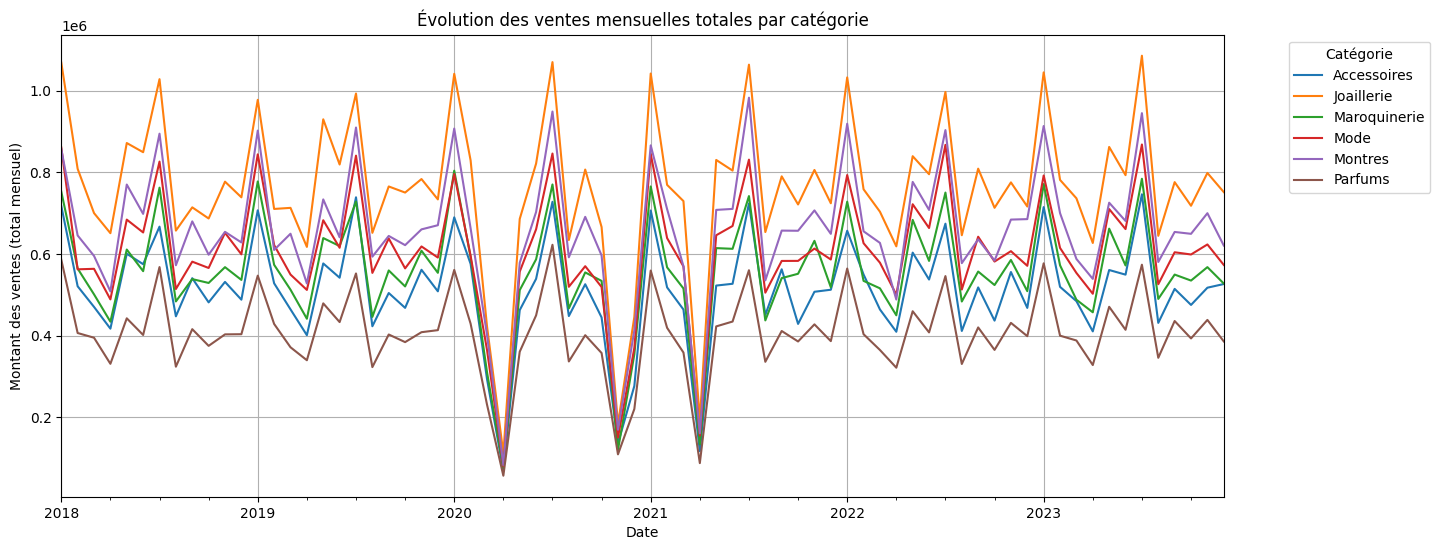

In [ ]:
monthly_sales_by_category = data.groupby([data['Date'].dt.to_period('M'), 'Catégorie'])['Montant des ventes'].sum().unstack()

monthly_sales_by_category.plot(figsize=(15, 6), title='Évolution des ventes mensuelles totales par catégorie')
plt.ylabel('Montant des ventes (total mensuel)')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Catégorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Introduction de l’analyse des variations saisonnières**

Bien que la courbe représentant la Joaillerie domine sur les graphes, cela ne reflète pas la dynamique globale du secteur du luxe. En réalité, la catégorie Mode & Maroquinerie reste prédominante grâce à sa clientèle plus large et à des cycles de renouvellement fréquents (sacs, vêtements, etc.). En revanche, la Joaillerie, bien que lucrative et symbolique du prestige des marques, cible un public plus restreint avec des achats souvent ponctuels.

* **Impact du COVID-19**

Au début de l’année 2020, toutes les catégories du luxe (joaillerie, accessoires, maroquinerie, mode, montres, parfums) ont subi une chute drastique des ventes en raison des fermetures des points de vente physiques. Cependant, dès le milieu de l’année, l’adoption accélérée des plateformes e-commerce et le repositionnement numérique des marques ont permis une reprise notable.

Les marques ont innové avec :
* Des lancements exclusifs en ligne,
* Des services de personnalisation,
* Des expériences virtuelles cohérentes avec la transformation numérique du luxe

Les campagnes marketing axées sur la proximité et l’exclusivité ont permis de capter une clientèle désireuse de vivre des expériences de luxe accessibles depuis chez elle. Malgré une reprise en fin d’année, la baisse observée début 2021 s’explique par une conjoncture économique encore incertaine et les restrictions du 3e confinement en mars 2021.

Périodes clés pour le secteur du luxe :

* Fin d’année (Q4) : Une hausse systématique des ventes due aux fêtes de fin d’année.
* Événements saisonniers asiatiques :
* Nouvel An Chinois (janvier-février),
* Golden Week Japonaise (29 avril - 5 mai),
* Golden Week Chinoise (1er - 7 octobre).
Ces périodes génèrent une consommation accrue, particulièrement dans les secteurs de la mode et des accessoires.
* Promotions saisonnières (juin-juillet) : Les soldes structurent également les comportements d’achat.
* Événements comme le Black Friday : Continuent de dynamiser les ventes.
Analyse des variations saisonnières

Les données montrent une saisonnalité marquée dans toutes les catégories :

* Des pics réguliers chaque année autour des fêtes et des promotions.
* Une baisse notable en 2020, directement liée à la pandémie.
* Une reprise visible dès fin 2020 et accélérée en 2021, suggérant une demande refoulée pour les produits de luxe.

* **Catégorie dominante**

La Joaillerie semble enregistrer des ventes élevées sur le court terme, mais cela masque la prédominance structurelle de la Mode & Maroquinerie, qui bénéficie de cycles d’achat plus réguliers et d’un public plus large. Après la chute de 2020, les ventes des différentes catégories se stabilisent à des niveaux proches de ceux d’avant la pandémie, illustrant une reprise progressive du secteur.

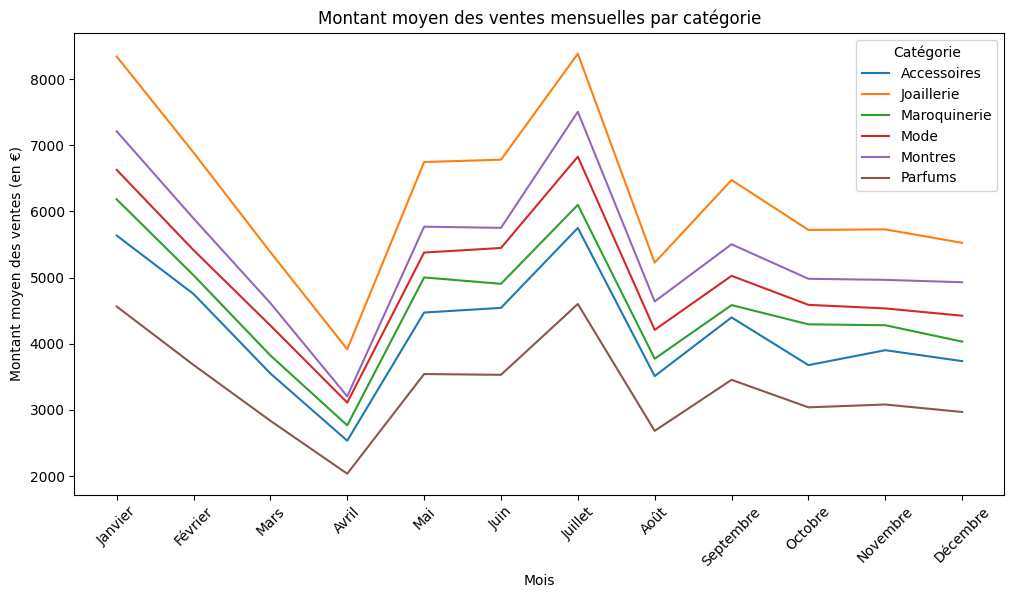

In [ ]:
monthly_sales_by_category = data.groupby(['Mois', 'Catégorie'])['Montant des ventes'].mean().unstack()

annual_sales_by_category = data.groupby(['Année', 'Catégorie'])['Montant des ventes'].mean().unstack()

monthly_sales_event = data.groupby(['Mois', 'Événement spécial'])['Montant des ventes'].mean().unstack()

month_names = [calendar.month_name[i] for i in range(1, 13)]
monthly_sales_by_category.plot(figsize=(12, 6), title='Montant moyen des ventes mensuelles par catégorie')
plt.ylabel('Montant moyen des ventes (en €)')
plt.xlabel('Mois')
plt.xticks(ticks=range(1, 13), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin",
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.show()




Les ventes présentent des fluctuations saisonnières bien définies, avec des creux et des pics qui suggèrent les cycles d'achat dans le secteur du luxe :
* **Creux saisonniers :**

**Avril et août** : Ces deux mois enregistrent les plus faibles montants moyens des ventes.

**Avril** : Période de transition entre les soldes d'hiver (janvier-février) et la saison des mariages (juin-juillet), souvent marquée par une baisse d'activité.

**Août** : Mois traditionnellement calme en raison des vacances d'été dans de nombreux marchés clés.

* **Pics saisonnières :**

**Juillet** : Mois phare, marqué par des promotions estivales et des ventes qui boostent les ventes dans toutes les catégories.

**Novembre** : Une forte hausse, probablement liée aux événements comme le Black Friday et les campagnes de fin d'année.

**Décembre** : Ventes élevées mais légèrement inférieures à celles de juillet, en raison de la saison des fêtes et des cadeaux.

* **Analyse des catégories dominantes**
1. **Joaillerie** : La Joaillerie domine tout au long de l'année avec des ventes moyennes plus élevées que les autres catégories. Les pics en juin (saison des mariages) et en juillet confirment son attrait lors des périodes associées à des événements spéciaux et aux promotions.
2. **Mode et Maroquinerie** : Bien que non dominantes dans ces données, ces catégories représentent généralement le moteur principal des ventes dans le luxe grâce à une clientèle large et des cycles de renouvellement fréquents. Leur performance stable reflète leur importance fondamentale dans le secteur.
3.**Accessoires et Montres** : Les Accessoires suivent des tendances proches de celles des catégories principales mais avec des montants moyens inférieurs. Les Montres enregistrent les ventes moyennes les plus faibles, suggérant soit un prix moyen inférieur, soit une moindre rotation des produits.
4.**Parfums** : Les ventes restent stables tout au long de l'année, sans variation significative, reflétant un produit plus accessible mais moins dynamique en termes de montants moyens.

**Conclusion : Réalité vs Données actuelles**

Bien que les données actuelles mettent en avant la Joaillerie comme catégorie dominante, il est important de noter que cela diverge de la dynamique réelle du marché du luxe. La Mode et la Maroquinerie sont généralement les piliers du secteur, bénéficiant d'une base de clientèle plus large et d'une fréquence d'achat plus élevée. La Joaillerie, quant à elle, reste un segment prestigieux mais ciblant un public restreint avec des achats ponctuels.
Cette analyse met en lumière l'importance des variations saisonnières et des stratégies commerciales bien définies pour maximiser les opportunités lors des périodes clés, tout en prenant en compte la réalité des dynamiques du marché

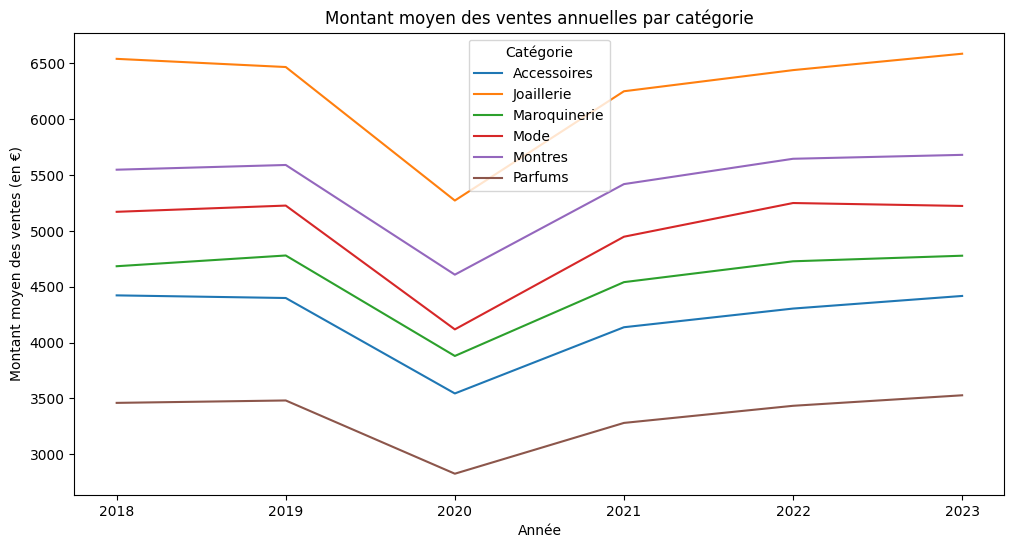

In [ ]:
annual_sales_by_category.plot(figsize=(12, 6), title='Montant moyen des ventes annuelles par catégorie')
plt.ylabel('Montant moyen des ventes (en €)')
plt.xlabel('Année')
plt.show()

**Baisse des ventes en 2020 :**

Toutes les catégories montrent un creux marqué en 2020, conséquence directe de la pandémie de COVID-19. Cette baisse peut être attribuée à :
1. La fermeture des boutiques physiques.
2. Les restrictions de déplacement.
3. Une baisse générale de la consommation discrétionnaire.

**Reprise progressive :**

À partir de 2021, une reprise notable est visible, marquée par une croissance régulière des ventes dans toutes les catégories jusqu'en 2023. Cela reflète la résilience du marché du luxe, stimulée par :
1. Une demande soutenue, notamment pour des catégories emblématiques.
2. Le repositionnement stratégique des marques vers le numérique, permettant de comprendre les impacts de la pandémie.

**Catégorie dominante : Joaillerie**

La Joaillerie se distingue comme la catégorie aux montants moyens les plus élevés tout au long de la période. Cela souligne :

1. Son attrait durable auprès des consommateurs malgré la crise.
2. Sa représentation du prestige et de l'exclusivité dans le secteur du luxe.


**Précision importante :**

Cependant, cette analyse ne reflète pas pleinement la réalité du marché mondial du luxe. En pratique :

**Mode et Maroquinerie** dominent généralement les ventes grâce à une clientèle plus large et des cycles de renouvellement fréquents (sacs, vêtements). **La Joaillerie,** bien que lucrative, cible un public plus restreint, avec des achats souvent ponctuels.

Cette distinction entre les données enregistrées et la dynamique réelle du marché rappelle l'importance d'une analyse croisée des chiffres et des tendances macroéconomiques pour obtenir une vision complète.

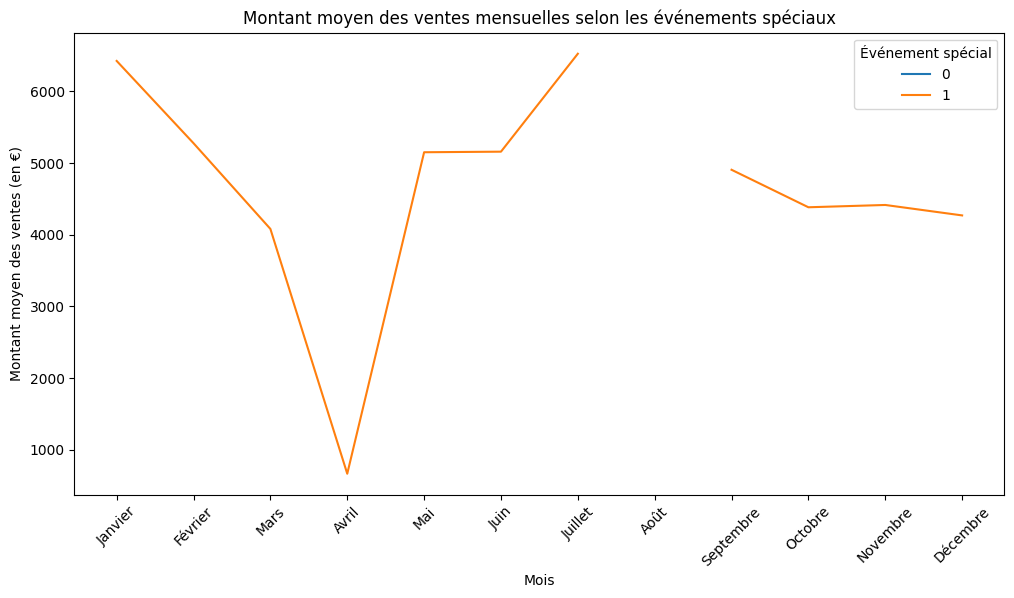

In [ ]:
monthly_sales_event.plot(figsize=(12, 6), title='Montant moyen des ventes mensuelles selon les événements spéciaux')
plt.ylabel('Montant moyen des ventes (en €)')
plt.xlabel('Mois')
plt.xticks(ticks=range(1, 13), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin",
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.show()

**Dynamique des ventes lors des événements spéciaux (Événement spécial = 1)**

La courbe représentant les ventes associées aux événements spéciaux illustre des montants moyens élevés, soulignant l'importance de ces moments clés pour le secteur du luxe. Les variations saisonnières sont marquées :

* **Janvier à avril :**
Une forte baisse est enregistrée après les fêtes de fin d'année et les soldes d'hiver, atteignant un point bas en avril, période traditionnellement calme pour le luxe.
* **Mai à juillet :**
Les ventes rebondissent significativement, atteignant un pic en juillet. Cela coïncide avec des lancements de collections estivales, des campagnes marketing ou des occasions spéciales comme les mariages.
* **Septembre à décembre :**
Une relative stabilité est observée en automne, bien qu'une hausse en fin d'année reste étonnamment faible. Cette tendance pourrait s'expliquer par une stratégie des marques visant à préserver l'exclusivité en limitant les promotions, même pendant la période de Noël.

**Absence de données pour les périodes sans événements spéciaux (Événement spécial = 0)**

La courbe des ventes hors événements spéciaux n'est pas visible, ce qui peut s'expliquer par : Une absence de données disponible pour ces périodes. Des montants négligeables, reflétant l'importance centrale des événements spéciaux pour dynamiser les ventes dans le luxe.

**Conclusion : Importance des événements spéciaux**

Les événements spéciaux jouent un rôle clé dans la stratégie des marques de luxe, offrant des opportunités de dynamisation des ventes. Ces périodes permettent aux Maisons de luxe de maintenir l'exclusivité de leur image tout en créant des expériences uniques pour leurs clients.
Les pics de vente en mai-juillet et la concentration des montants élevés autour des événements soulignent l'importance des temps forts dans le luxe.
Les creux (notamment en avril) confirment que l'absence d'événements spéciaux entraîne une baisse d'intérêt et de demande.
Les marques doivent donc continuer à miser sur ces temps forts pour stimuler les ventes tout en renforçant leur positionnement stratégique et leur image de prestige.


In [ ]:
monthly_sales_event

Événement spécial            0            1
Mois                                       
1                          NaN  6425.532220
2                          NaN  5276.553423
3                          NaN  4080.058840
4                  3380.876008   662.180682
5                          NaN  5150.607454
6                          NaN  5158.629492
7                          NaN  6526.052008
8                  4006.316310          NaN
9                          NaN  4905.865652
10                         NaN  4382.334591
11                         NaN  4414.498487
12                         NaN  4268.673930

* La majorité des ventes dans l'année sont associées à des événements spéciaux (Événement spécial = 1), expliquant pourquoi la plupart des mois n'ont pas de valeurs pour Événement spécial = 0. Cela reflète une stratégie commerciale où le secteur du luxe mise fortement sur les campagnes événementielles pour stimuler la demande.

## **Impact des évenements spéciaux**

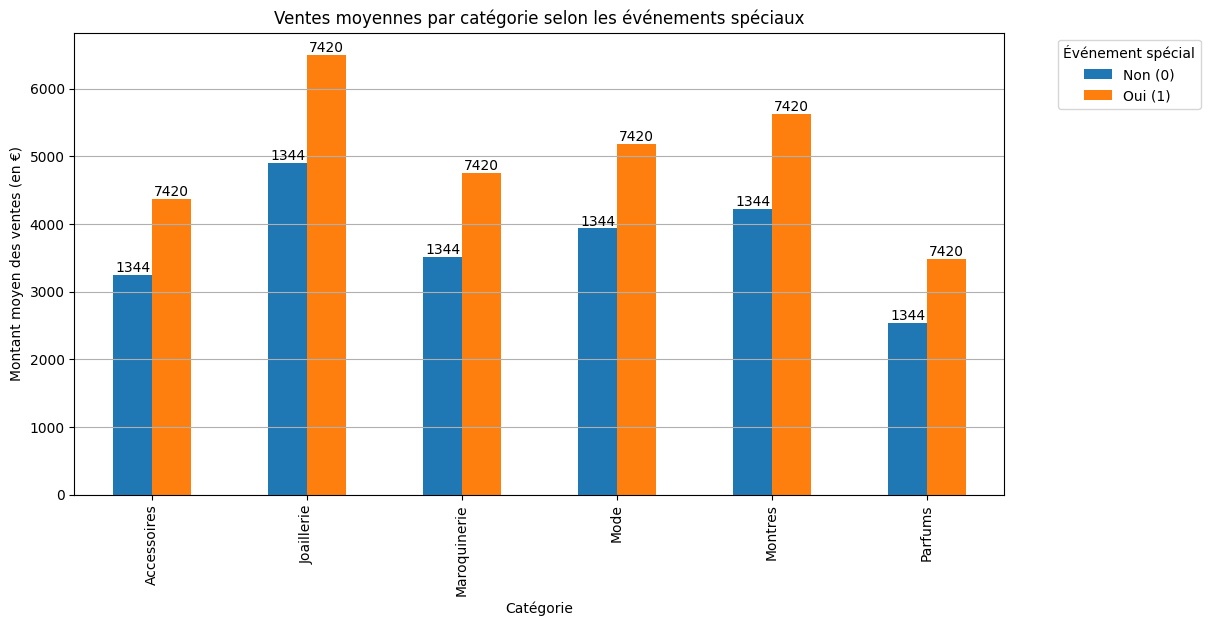

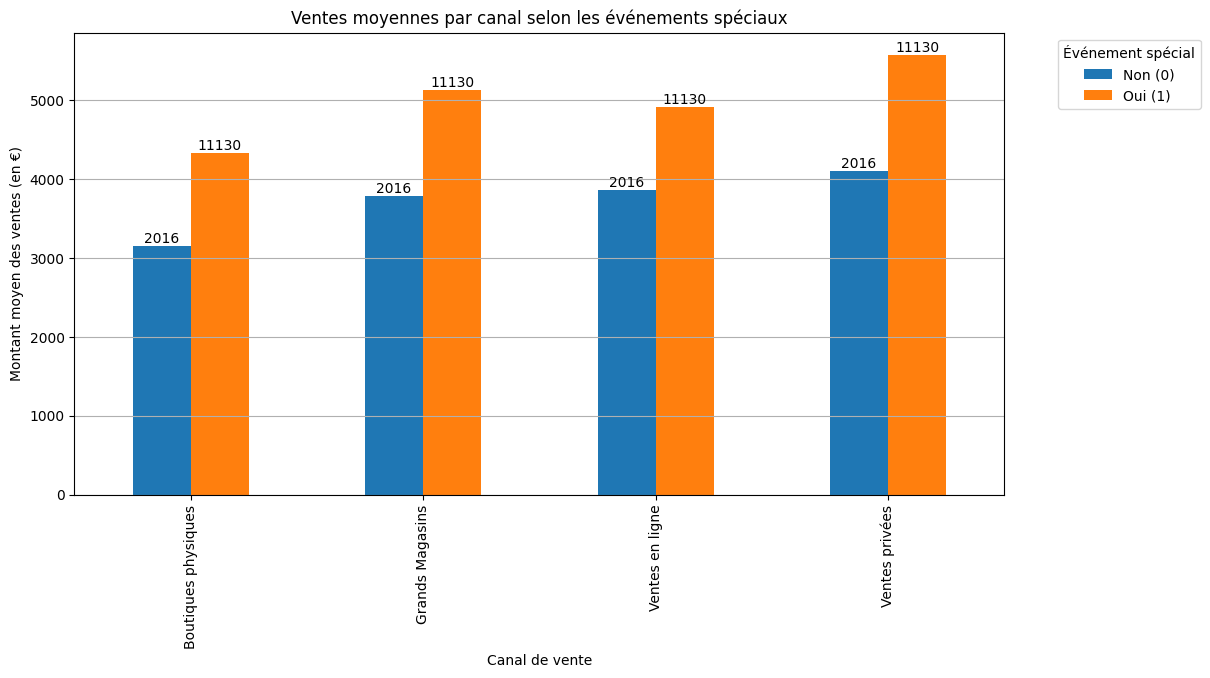

In [ ]:
event_sales_by_category = data.groupby(['Événement spécial', 'Catégorie'])['Montant des ventes'].mean().unstack()

event_sales_by_channel = data.groupby(['Événement spécial', 'Canal de vente'])['Montant des ventes'].mean().unstack()

event_counts_by_category = data.groupby(['Événement spécial', 'Catégorie']).size().unstack()

event_counts_by_channel = data.groupby(['Événement spécial', 'Canal de vente']).size().unstack()

ax1 = event_sales_by_category.T.plot(kind='bar', figsize=(12, 6), title='Ventes moyennes par catégorie selon les événements spéciaux')
plt.ylabel('Montant moyen des ventes (en €)')
plt.xlabel('Catégorie')
plt.legend(title='Événement spécial', labels=['Non (0)', 'Oui (1)'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

for i, bar in enumerate(ax1.patches):
    col_idx = i % event_counts_by_category.shape[1]
    row_idx = i // event_counts_by_category.shape[1]
    count_value = event_counts_by_category.iloc[row_idx, col_idx]

    ax1.annotate(f'{int(count_value)}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.show()

ax2 = event_sales_by_channel.T.plot(kind='bar', figsize=(12, 6), title='Ventes moyennes par canal selon les événements spéciaux')
plt.ylabel('Montant moyen des ventes (en €)')
plt.xlabel('Canal de vente')
plt.legend(title='Événement spécial', labels=['Non (0)', 'Oui (1)'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

for i, bar in enumerate(ax2.patches):
    col_idx = i % event_counts_by_channel.shape[1]
    row_idx = i // event_counts_by_channel.shape[1]
    count_value = event_counts_by_channel.iloc[row_idx, col_idx]

    ax2.annotate(f'{int(count_value)}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.show()



**1. Par catégorie**

* **Événement spécial = 1**

Montants élevés pour toutes les catégories, notamment pour la Joaillerie et les Montres, qui affichent les ventes moyennes les plus importantes, témoignant de leur forte sensibilité aux événements.
Les Parfums et Accessoires enregistrent des montants moyens plus modestes mais restent stables, indiquant une moindre dépendance aux événements.

* **Événement spécial = 0**

Les ventes moyennes chutent nettement pour toutes les catégories.
La Joaillerie et les Montres continuent de performer légèrement mieux, probablement grâce à leur attrait intemporel et leur valeur perçue élevée.

**2. Par canal**

* **Événement spécial = 1**

Ventes privées et Grands Magasins dominants, avec des ventes moyennes très élevées. Ces canaux s'avèrent particulièrement efficaces lors des campagnes événementielles.
Les Boutiques physiques et les Ventes en ligne montrent également de bonnes performances, bien qu'elles soient légèrement inférieures aux deux premiers canaux.
* **Événement spécial = 0**

Les Ventes privées maintiennent une légère supériorité en termes de montants moyens, même sans événements.
Les Boutiques physiques sont nettement moins performantes en l'absence de campagnes spécifiques, révélant leur forte dépendance aux temps forts.

**Synthèse et opportunités**

**Sensibilité aux événements :**

**Catégories clés :** Joaillerie et Montres, en raison de leur valeur perçue, leur intemporalité, et leur attrait pour les événements exclusifs.
Canaux les plus efficaces : Ventes privées et Grands Magasins, qui renvoient prestige et exclusivité.

**Lien stratégique :**
Les Ventes privées et Grands Magasins pourraient maximiser leurs performances en organisant davantage d'événements privés pour les catégories Joaillerie et Montres, répondant aux attentes des clients qui privilégient l'essai et la visualisation de produits de grande valeur. Ces catégories incarnent une rareté et une longue

## **Analyse par canal de vente**

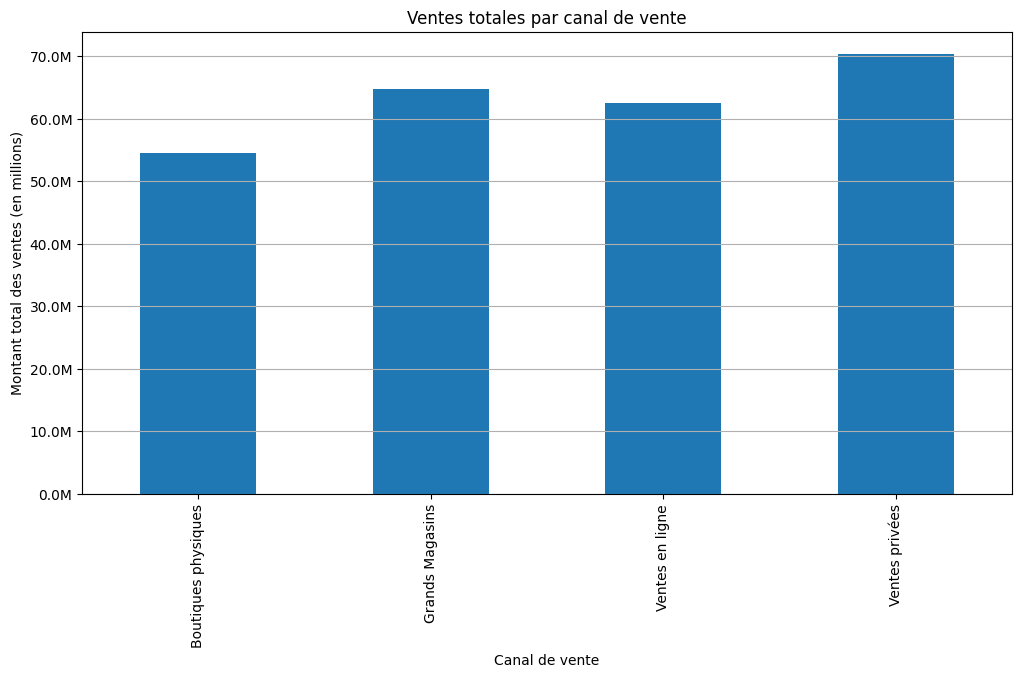

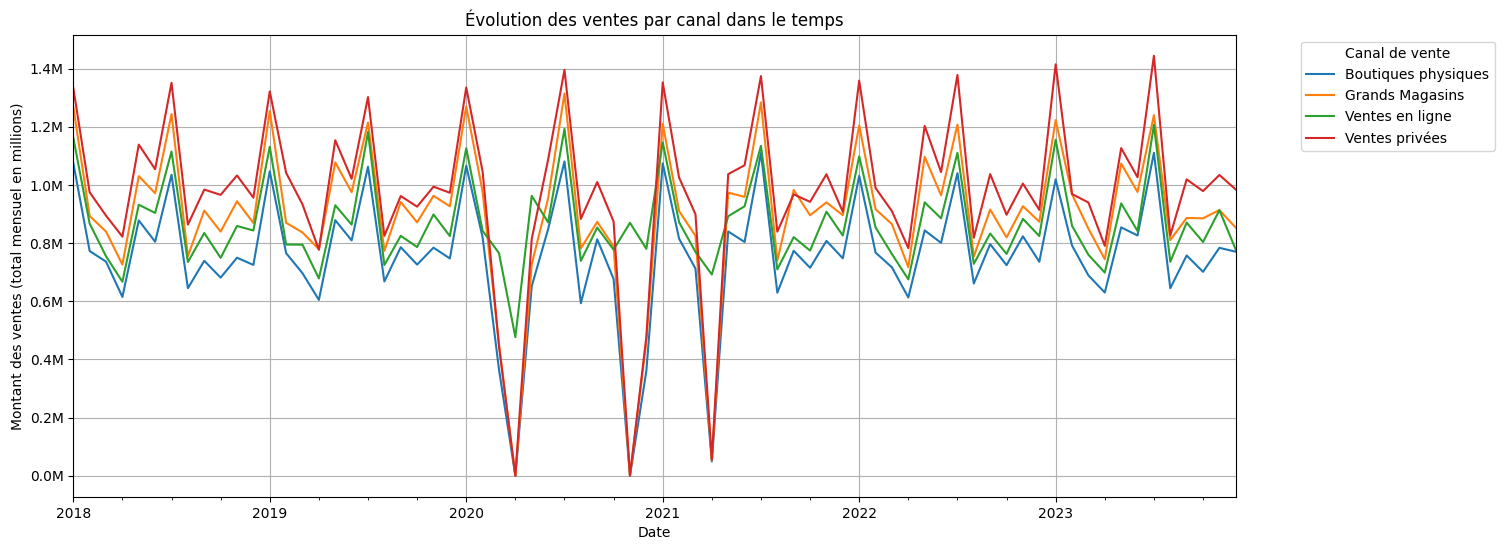

In [ ]:
from matplotlib.ticker import FuncFormatter

def full_millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

formatter = FuncFormatter(full_millions_formatter)

sales_by_channel = data.groupby('Canal de vente')['Montant des ventes'].sum()
monthly_sales_by_channel = data.groupby([data['Date'].dt.to_period('M'), 'Canal de vente'])['Montant des ventes'].sum().unstack()

plt.figure(figsize=(12, 6))
ax1 = sales_by_channel.plot(kind='bar', title='Ventes totales par canal de vente')
ax1.set_ylabel('Montant total des ventes (en millions)')
ax1.set_xlabel('Canal de vente')
ax1.yaxis.set_major_formatter(formatter)
plt.grid(axis='y')
plt.show()

fig, ax2 = plt.subplots(figsize=(15, 6))
monthly_sales_by_channel.plot(ax=ax2, title='Évolution des ventes par canal dans le temps')
ax2.set_ylabel('Montant des ventes (total mensuel en millions)')
ax2.set_xlabel('Date')
ax2.legend(title='Canal de vente', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.show()


**Analyse des canaux de vente dans le luxe :** Impact de la pandémie et tendances post-COVID.

**1. Canaux dominants**

Ventes privées (courbe rouge) et Grands magasins (courbe orange) :
Principaux contributeurs aux montants mensuels de ventes.
Réaffirmez leur efficacité grâce à leur caractère exclusif et leur positionnement premium.

Ventes en ligne (courbe verte) :
Croissance notable, particulièrement pendant les périodes de restrictions physiques, mais reste en deçà des canaux traditionnels en termes de montants totaux.

Boutiques physiques (courbe bleue) :
Performances plus faibles, accentuées par les fermetures forcées pendant les confinements.

**2. Saisonnalité des ventes**

Pics récurrentes :

Juin : Reflète la demande liée aux mariages, lancements de collections, et événements estivaux.

Décembre : Résultat des fêtes de fin d'année et des campagnes promotionnelles majeures.

**3. Impact de la pandémie (2020)**

Confinements successifs et baisses significatives :

Premier confinement (mars-mai 2020) : Impact initial sévère sur tous les canaux, en particulier les Boutiques physiques et les Grands magasins.

Deuxième confinement (octobre-décembre 2020) : Impact réduit grâce à une meilleure adoption des ventes en ligne.

Troisième confinement (avril-mai 2021) : Baisse modérée, les marques ayant renforcé leur stratégie numérique.

Résilience des ventes en ligne :
Les ventes numériques ont permis aux marques de maintenir un lien avec les consommateurs via des services tels que consultations virtuelles et personnalisation.

**Limites :**

Nature des sites vitrines : Peu de marques proposaient des expériences d'achat fluides et orientées transaction.

Prix élevé et besoin d'expérience physique : L'achat de produits coûteux reste fortement associé à l'expérience en boutique.

Habitudes d'achat spécifiques : Une partie de la clientèle, peu habituée au digital, a arrêté d'acheter durant cette période.

**4. Reprise post-pandémie**

À partir de fin 2020 :
Les Grands magasins et Ventes privées retrouvent leur domination grâce à leur caractère immersif et exclusif.
Les ventes en ligne continuent une croissance stable, gagnante du terrain grâce aux nouveaux comportements d'achat numérique.

**Conclusion : Leçons et opportunités**

Ventes privées et grands magasins restent des piliers pour les ventes haut de gamme grâce à leur alignement avec les attentes d'exclusivité des consommateurs.
Adoption du numérique : La pandémie a démontré la nécessité pour les marques de luxe de renforcer leurs plateformes e-commerce, tout en préservant les éléments d'expérience haut de gamme.

Hybridation des canaux : Une stratégie omnicanal (boutique physique, digital et événements privés) semble essentielle pour répondre aux attentes variées d'une clientèle diversifiée, notamment avec l'essor des générations plus jeunes comme la Gen Z.

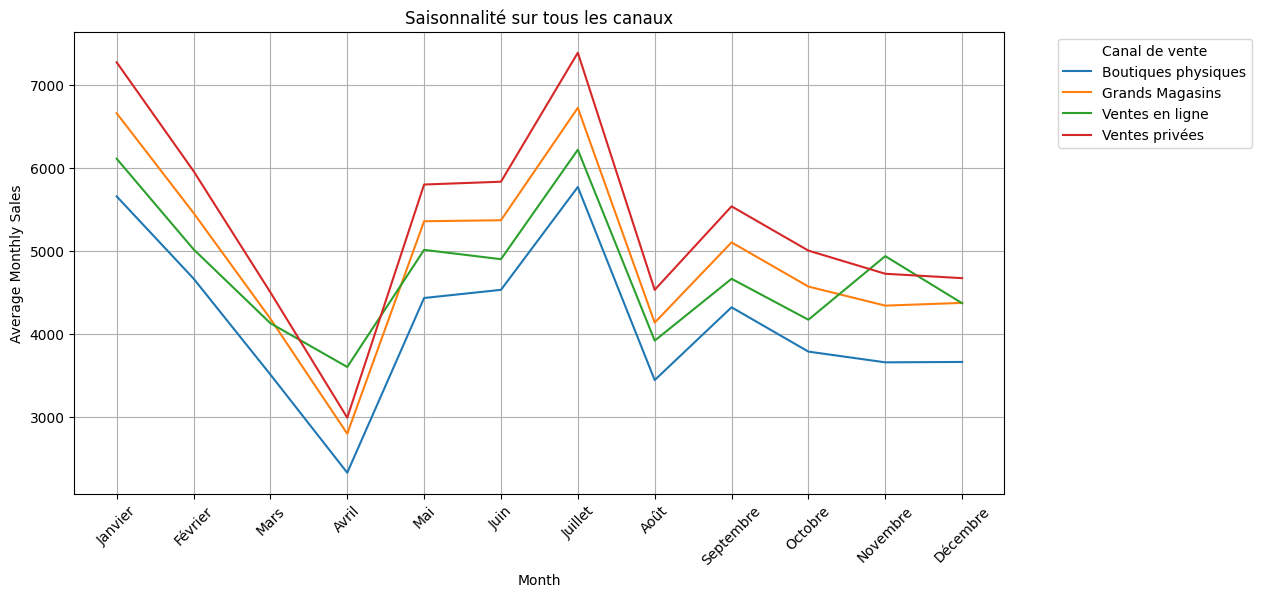

In [ ]:
monthly_avg_sales_by_channel = data.groupby([data['Date'].dt.month, 'Canal de vente'])['Montant des ventes'].mean().unstack()

monthly_avg_sales_by_channel.plot(figsize=(12, 6), title='Saisonnalité sur tous les canaux')
plt.ylabel('Average Monthly Sales')
plt.xlabel('Month')
plt.xticks(ticks=range(1, 13), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin",
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.legend(title='Canal de vente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


**Analyse des Pics et Creux Saisonniers des Ventes par Canal**

**1. Pics Saisonniers :**

* Juin : Mariages, lancements de collections estivales, et promotions d'été.
Tous les canaux montrent une hausse, avec une forte participation des ventes privées et des grands magasins.

* Décembre :
Lié aux fêtes de fin d'année (Noël, Nouvel An) et aux campagnes promotionnelles majeures.
Les ventes privées et les grands magasins dominent, tandis que les ventes en ligne bénéficient du Black Friday et du Cyber Monday.

**2. Variations par Canal :**

* Ventes en ligne (courbe verte) :
Performances relativement régulières sur l'année, avec de légères hausses autour des événements numériques (Black Friday, Cyber Monday).
Reflète une capacité à maintenir l'activité hors périodes saisonnières grâce à l'accessibilité et à la flexibilité du canal numérique.
* Boutiques physiques et Grands magasins (courbes bleue et orange) :
Variabilité plus marquée, avec des hausses significatives lors des périodes festives et promotionnelles.
Montres une dépendance plus forte aux événements et aux campagnes saisonnières.
* Ventes privées (courbe rouge) :
Niveaux systématiquement supérieurs aux autres canaux, notamment lors d'événements exclusifs qui attirent une clientèle spécifique.

**3. Creux Saisonniers :**

* Avril (printemps) :
Période de transition après les fêtes de fin d'année et avant les promotions estivales.
Reflète un ralentissement général des campagnes commerciales dans le luxe.
* Août (vacances d'été) :
Baisse notable en raison des déplacements et des congés, avec une activité réduite sur tous les canaux, sauf peut-être pour les ventes en ligne qui restent légèrement actives.

**4. Insights stratégiques :**

* Optimisation des ventes privées :
Renforcer ces campagnes lors des photos saisonniers et considérer des événements exclusifs pendant les périodes creuses (avril, août) pour stimuler l'activité.
* Accent sur le numérique :
Les ventes en ligne présentent un potentiel de croissance continue grâce à leur régularité et leur résilience pendant les creux. Investir dans des expériences interactives (consultations virtuelles, personnalisation) pourrait comprendre l'absence d'événements physiques.
* Répartition des campagnes :
Rééquilibrer les efforts marketing pour dynamiser les mois calmes (avril, août) par des initiatives spécifiques, notamment sur les canaux numériques et les ventes privées.

## **Analyse des anomalies des ventes à zéro**

In [ ]:
zero_sales = data[data['Montant des ventes'] == 0]

max_sales = data[data['Montant des ventes'] == data['Montant des ventes'].max()]

zero_sales_count = zero_sales.shape[0]

zero_sales_summary = zero_sales.groupby(['Événement spécial', 'Catégorie', 'Canal de vente']).size()
max_sales_summary = max_sales.groupby(['Événement spécial', 'Catégorie', 'Canal de vente']).size()

print("Nombre total de ventes à 0 :", zero_sales_count)
print("\nRésumé des ventes à 0 (par catégorie, canal, et événement spécial) :")
print(zero_sales_summary)

print("\nValeur maximale des ventes :", max_sales['Montant des ventes'].iloc[0])
print("\nRésumé des ventes maximales (par catégorie, canal, et événement spécial) :")
print(max_sales_summary)

Nombre total de ventes à 0 : 2412

Résumé des ventes à 0 (par catégorie, canal, et événement spécial) :
Événement spécial  Catégorie     Canal de vente     
0                  Accessoires   Boutiques physiques     28
                                 Grands Magasins         28
                                 Ventes privées          28
                   Joaillerie    Boutiques physiques     28
                                 Grands Magasins         28
                                 Ventes privées          28
                   Maroquinerie  Boutiques physiques     28
                                 Grands Magasins         28
                                 Ventes privées          28
                   Mode          Boutiques physiques     28
                                 Grands Magasins         28
                                 Ventes privées          28
                   Montres       Boutiques physiques     28
                                 Grands Magasins         28
   

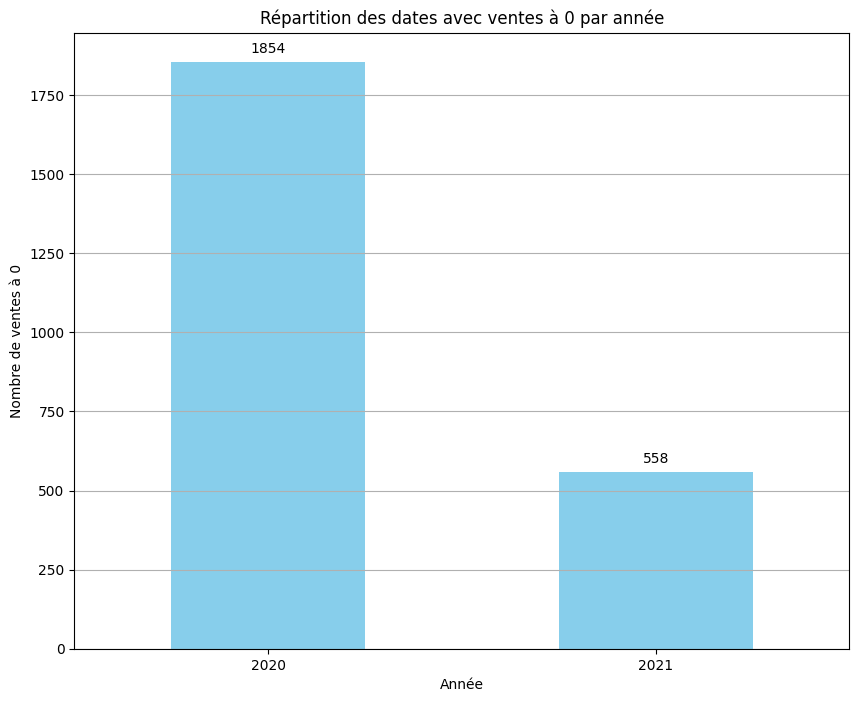

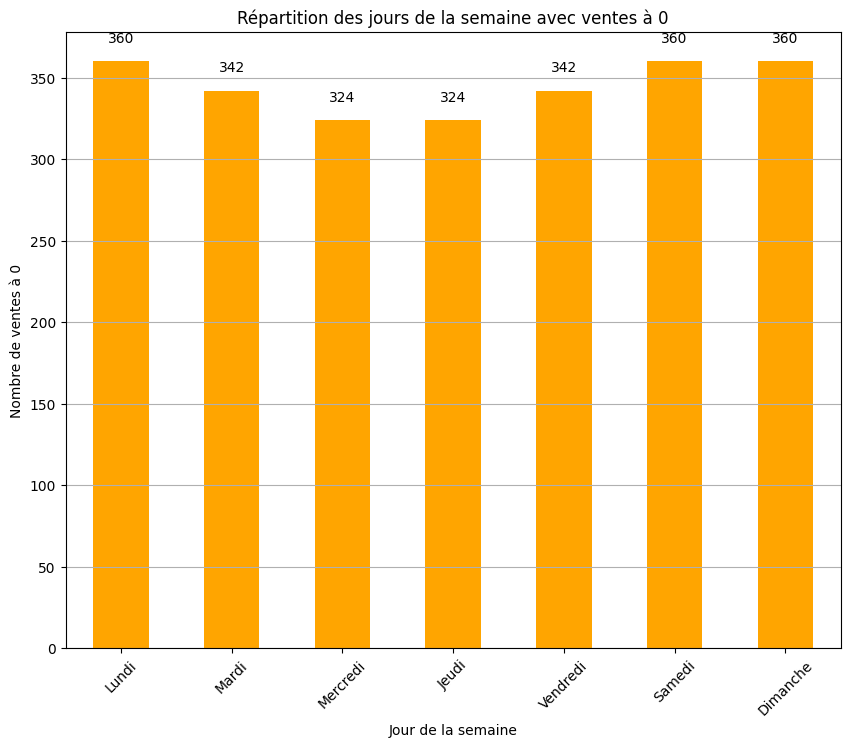


Dates avec événements spéciaux et ventes à 0 :
Date        Événement spécial
2020-03-17  1                    18
2020-03-18  1                    18
2020-03-19  1                    18
2020-03-20  1                    18
2020-03-21  1                    18
                                 ..
2021-04-29  0                    18
2021-04-30  0                    18
2021-05-01  1                    18
2021-05-02  1                    18
2021-05-03  1                    18
Length: 134, dtype: int64


In [ ]:
zero_sales_dates = zero_sales['Date'].unique()

zero_sales_by_year = zero_sales.groupby(zero_sales['Date'].dt.year).size()

zero_sales_dayofweek = zero_sales.groupby(zero_sales['Date'].dt.dayofweek).size()

zero_sales_events = zero_sales.groupby(['Date', 'Événement spécial']).size()

plt.figure(figsize=(10, 8))
zero_sales_by_year.plot(kind='bar', color='skyblue', title="Répartition des dates avec ventes à 0 par année")
plt.xlabel("Année")
plt.ylabel("Nombre de ventes à 0")
plt.xticks(rotation=0)
for i, v in enumerate(zero_sales_by_year):
    plt.text(i, v + 20, str(v), ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.show()

days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
plt.figure(figsize=(10, 8))
zero_sales_dayofweek.plot(kind='bar', color='orange', title="Répartition des jours de la semaine avec ventes à 0")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre de ventes à 0")
plt.xticks(ticks=range(7), labels=days, rotation=45)
for i, v in enumerate(zero_sales_dayofweek):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.show()


print("\nDates avec événements spéciaux et ventes à 0 :")
print(zero_sales_events)

**1. Répartition des dates avec ventes à 0 par année**
* 2020 : 1 854 occurrences
La majorité des ventes à 0 sont enregistrées en 2020, ce qui correspond à l’impact massif de la pandémie de COVID-19. La fermeture des boutiques physiques et des grands magasins, ainsi que les restrictions sanitaires, ont drastiquement réduit l’activité dans plusieurs segments du luxe.
* 2021 : 558 occurrences
Bien que la situation se soit améliorée, le nombre important de ventes à 0 en 2021 s’explique par : des restrictions locales persistantes, une reprise économique lente, l’adaptation graduelle des canaux de vente et de la consommation.

**2. Répartition des jours de la semaine avec ventes à 0**

Les occurrences de ventes à 0 sont réparties uniformément sur tous les jours de la semaine, oscillant entre 324 et 360 occurrences. Ces données indiquent que les anomalies ne sont pas liées à des jours spécifiques, comme les week-ends.
 Cela reflète une perturbation généralisée des activités pendant des périodes prolongées, probablement en raison de la fermeture des boutiques et des canaux pysiques.

**3. Dates spécifiques avec ventes à 0 lors d’événements spéciaux**

Certaines périodes clés présentent des ventes à 0, même pendant des événements importants : Exemple : 17 mars 2020 - 21 mars 2020

Ces dates coïncident avec les premiers confinements stricts liés à la pandémie. Durant ces périodes : Les boutiques physiques et grands magasins étaient fermés.
Les événements commerciaux ou festifs n’ont pas réussi à stimuler les ventes, notamment dans les segments dépendants des canaux physiques.

**Conclusion**

Les ventes à 0, particulièrement marquées en 2020 et 2021, traduisent les effets directs de la pandémie de COVID-19 sur le secteur du luxe. La répartition uniforme par jour de la semaine reflète une perturbation globale et durable des activités. Enfin, même lors d’événements spéciaux, la fermeture des boutiques physiques a empêché tout rebond significatif des ventes sur ces périodes.

## **Segmentation par catégorie : Saisonnalité**

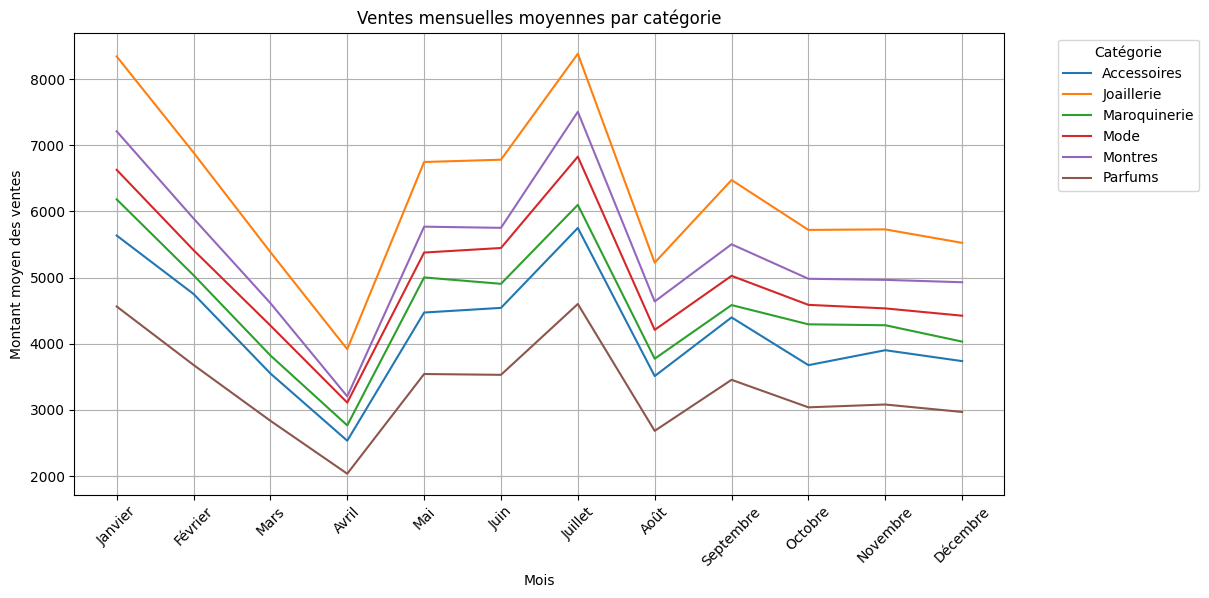

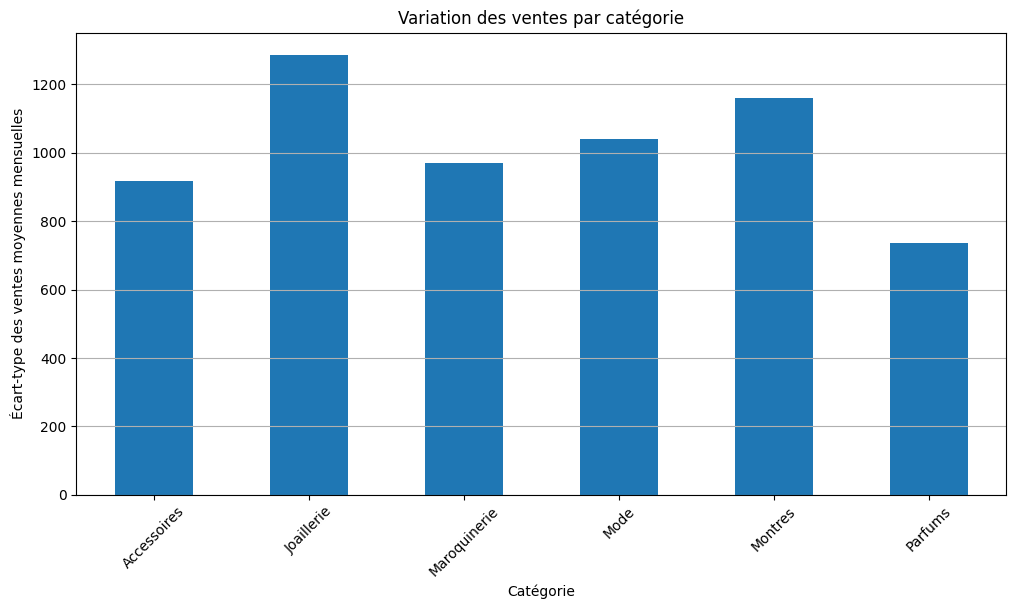

In [ ]:
monthly_sales_by_category = data.groupby([data['Date'].dt.month, 'Catégorie'])['Montant des ventes'].mean().unstack()

sales_variation_by_category = monthly_sales_by_category.std()

monthly_sales_by_category.plot(figsize=(12, 6), title="Ventes mensuelles moyennes par catégorie")
plt.ylabel("Montant moyen des ventes")
plt.xlabel("Mois")
plt.xticks(ticks=range(1, 13), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin",
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.legend(title="Catégorie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

sales_variation_by_category.plot(kind='bar', figsize=(12, 6), title="Variation des ventes par catégorie")
plt.ylabel("Écart-type des ventes moyennes mensuelles")
plt.xlabel("Catégorie")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


**Analyse des ventes mensuelles moyennes par catégorie**

Tendance générale

Toutes les catégories de produits (Accessoires, Joaillerie, Maroquinerie, Mode, Montres, Parfums) suivent des tendances saisonnières similaires :
* Creux en avril : Faible activité, probablement liée à une période sans événements majeurs.
* Pics en juillet et décembre : Dynamique estivale (soldes, mariages) et saison des fêtes (Noël, fin d’année).
* Diminution progressive en fin d’année : Une stabilisation ou légère baisse après les fêtes.

**Analyse par catégorie**

* Accessoires (bleu clair) :Ventes stables tout au long de l’année, sans variations extrêmes.Une catégorie dans la moyenne en termes de volume.

* Joaillerie (orange) :Catégorie avec les ventes les plus élevées, particulièrement en juillet (campagnes estivales, mariages).Montre une sensibilité marquée à la saisonnalité, avec des pics nets et des creux prononcés.

* Maroquinerie (vert) :Suivi similaire à la Joaillerie, mais avec un volume légèrement inférieur.Forte augmentation des ventes entre mai et juillet.

* Mode (rouge) :Relativement stable, avec une légère hausse estivale.Moins sensible aux creux saisonniers, notamment en avril.

* Montres (violet) :Ventes modérées, avec un comportement proche de celui de la Mode.Sensible aux pics saisonniers comme la Joaillerie.

* Parfums (marron) :La catégorie avec les ventes les plus faibles.
Variations limitées tout au long de l’année, mais un creux notable en avril.


**Saisonnalité par périodes clés**
* Janvier à avril :Diminution générale des ventes, avec un point bas en avril.Reflète une période calme après les fêtes de fin d’année, sans événements majeurs pour stimuler la demande.
* Mai à juillet :Pic marqué, surtout pour la Joaillerie et la Maroquinerie.Correspond à une saison de forte consommation liée aux mariages, événements estivaux et promotions.
* Août à décembre :Diminution progressive après l’été.Contrairement aux attentes, les ventes de décembre n’affichent pas de hausse significative, indiquant un potentiel inexploité pour la saison des fêtes.

## Synthèse EDA

Sur la base des analyses réalisées et des insights extraits, plusieurs modèles prédictifs peuvent être construits pour répondre à différentes problématiques. Voici une liste des modèles pertinents avec des objectifs clairs :

---
 **1. Modèle de prévision des ventes globales**
   - **Objectif :** Prédire les ventes totales (tous canaux et catégories confondus) pour des périodes futures.
   - **Approche :**
     - Utiliser des techniques de séries temporelles (ARIMA, Prophet, LSTM, ou autres modèles de régression) pour capturer les tendances, la saisonnalité et les variations.
   - **Données nécessaires :**
     - Historique des ventes totales par mois ou jour.
     - Variables explicatives comme les mois, les événements spéciaux, ou les jours de la semaine.

---

**2. Modèle de prévision par catégorie**
   - **Objectif :** Prédire les ventes pour chaque catégorie ("Mode", "Accessoires", "Joaillerie", etc.).
   - **Approche :**
     - Construire un modèle de régression multiple ou un modèle par séries temporelles pour chaque catégorie.
     - Intégrer des facteurs spécifiques, comme la saisonnalité et les événements, pour capturer les fluctuations propres à chaque catégorie.
   - **Données nécessaires :**
     - Historique des ventes par catégorie et par mois.
     - Variables comme les événements spéciaux, la période de l'année, et les tendances passées.

---
**3. Modèle de prévision par canal**
   - **Objectif :** Identifier les canaux dominants et prédire les ventes pour chaque canal (en ligne, boutiques physiques, grands magasins, etc.).
   - **Approche :**
     - Réaliser des modèles de séries temporelles ou des modèles basés sur des régressions pour chaque canal.
     - Intégrer des variables liées à l'activité spécifique de chaque canal, comme les fermetures pendant les confinements ou les campagnes spécifiques.
   - **Données nécessaires :**
     - Historique des ventes par canal, segmenté par date.
     - Données sur les fermetures et événements influençant l'activité.

---

**4 Modèle de prévision de la saisonnalité**
   - **Objectif :** Prédire les pics et creux saisonniers pour ajuster les stocks et les stratégies de vente.
   - **Approche :**
     - Exploiter des modèles spécifiques à la saisonnalité (STL decomposition, Prophet) pour prédire les variations liées aux mois et événements.
   - **Données nécessaires :**
     - Historique des ventes segmenté par mois.
     - Identification des périodes clés comme les vacances, promotions, etc.

---

## **Etudier la saisonnalité**

Les graphiques des ventes montrent des variations saisonnières relativement constantes en amplitude. Par exemple, les pics de ventes pendant les périodes comme décembre ou juin semblent suivre une variation fixe plutôt que proportionnelle à la tendance générale. Donc nous allons utiliser le modèle addictif pour la décomposition

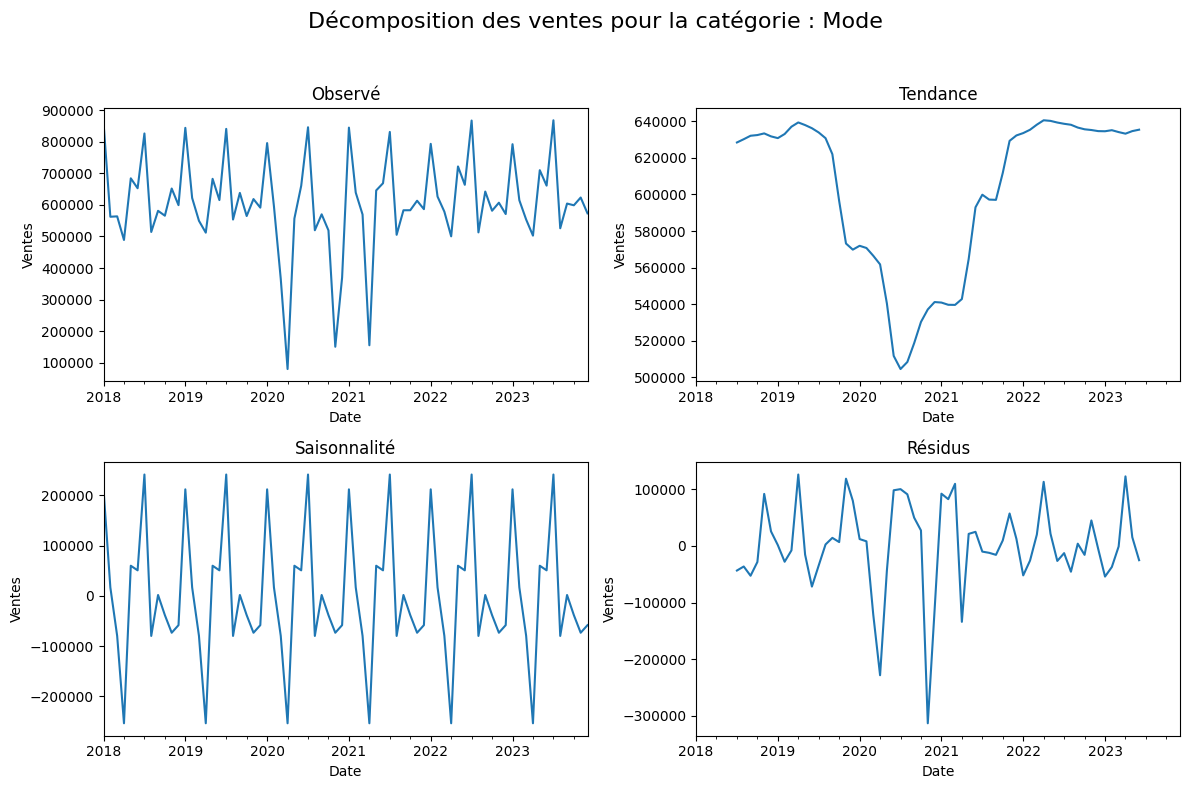

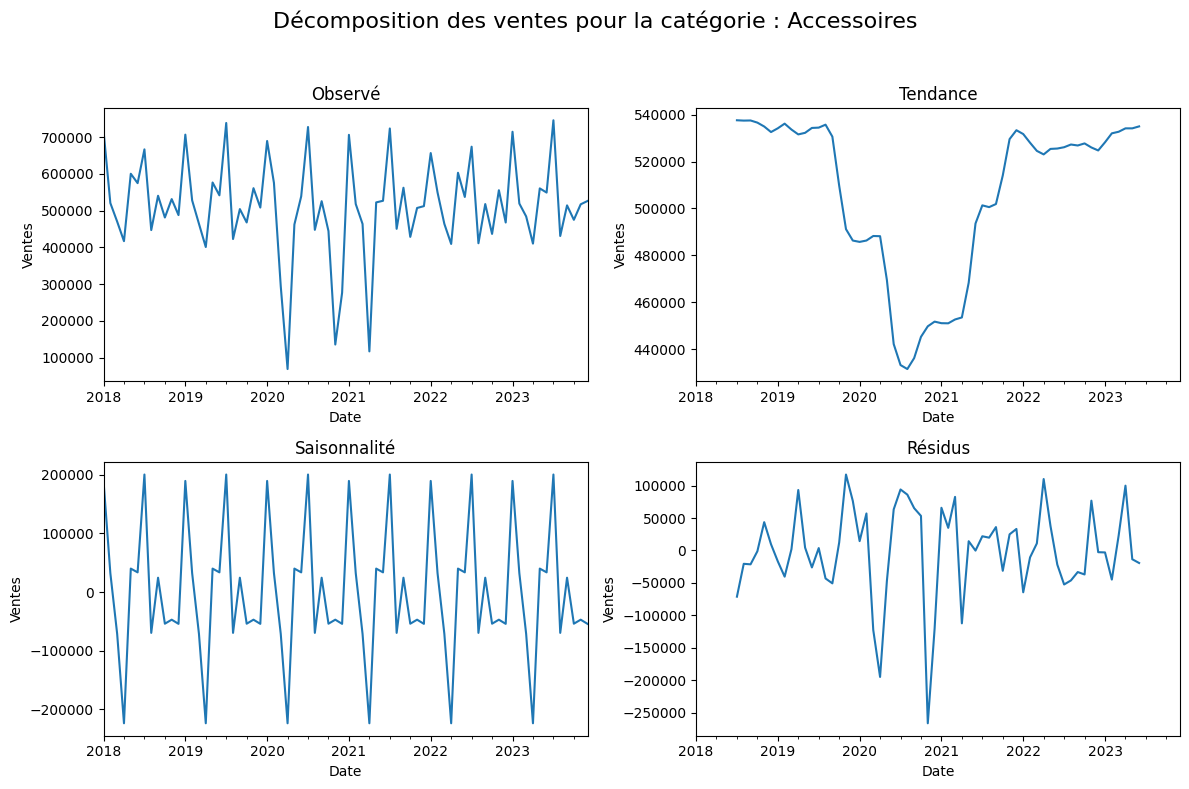

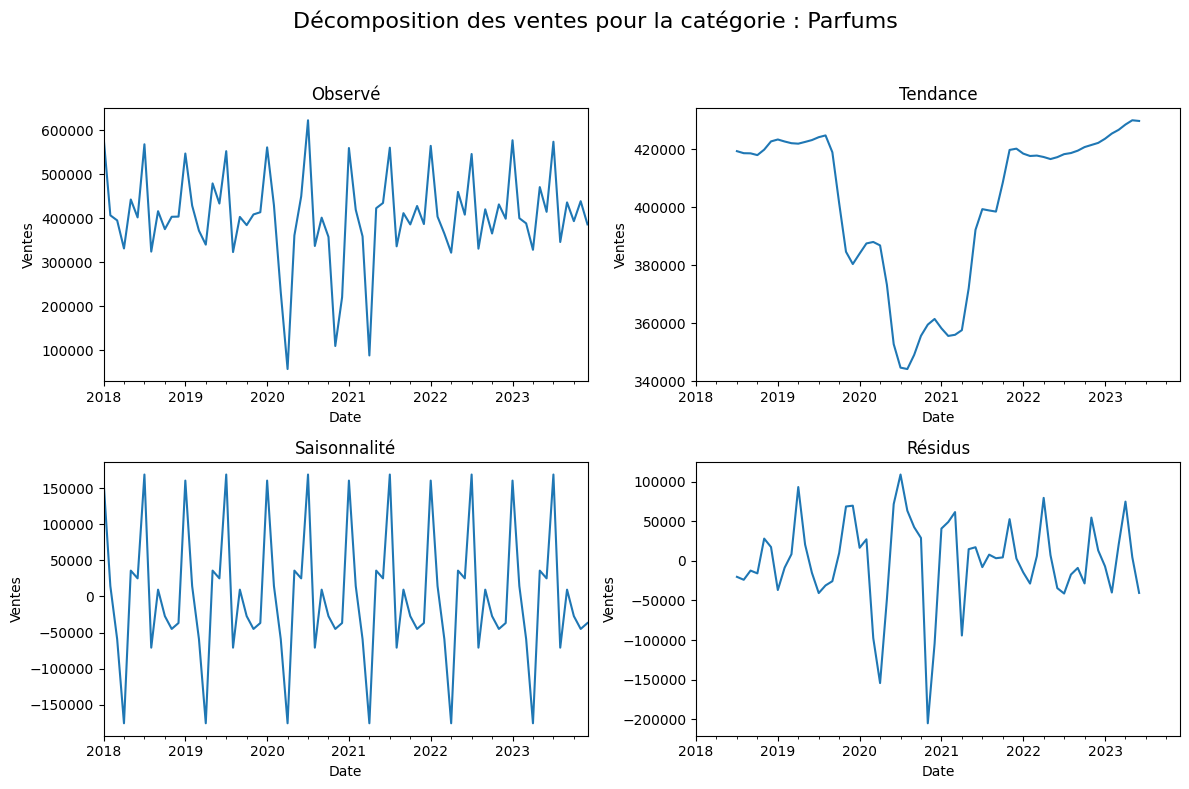

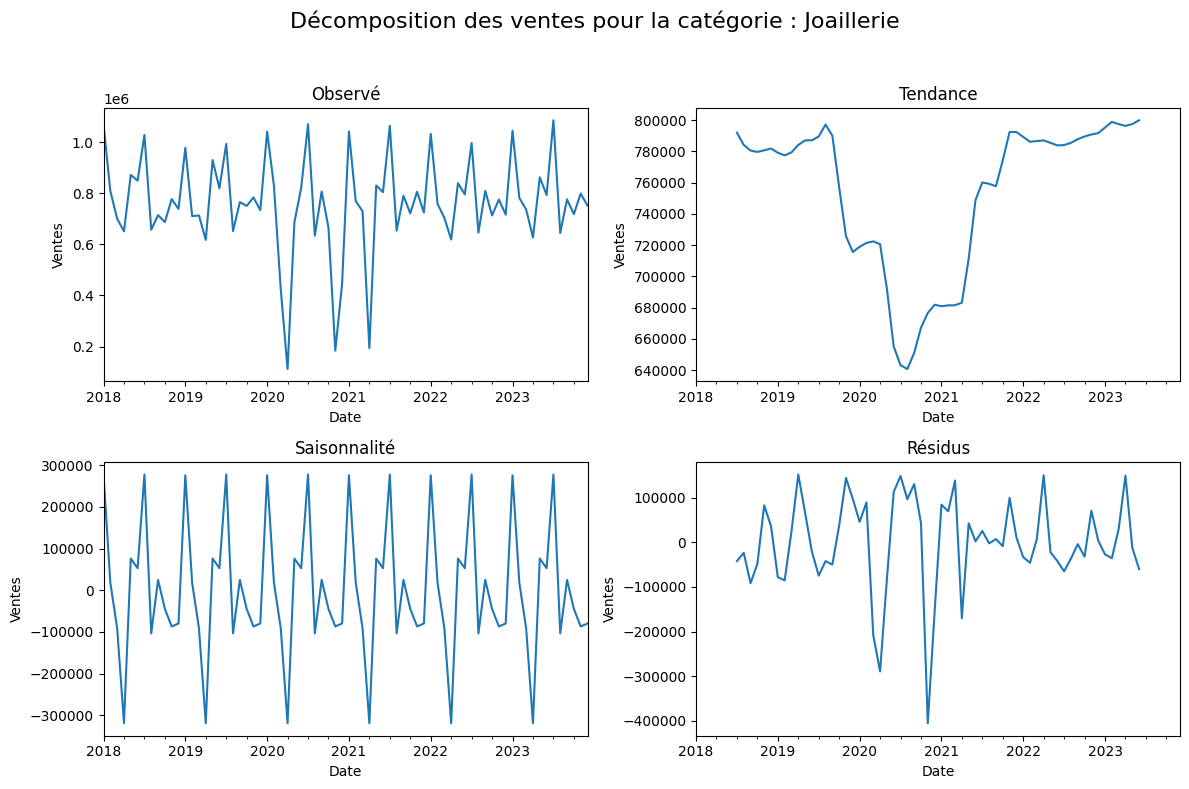

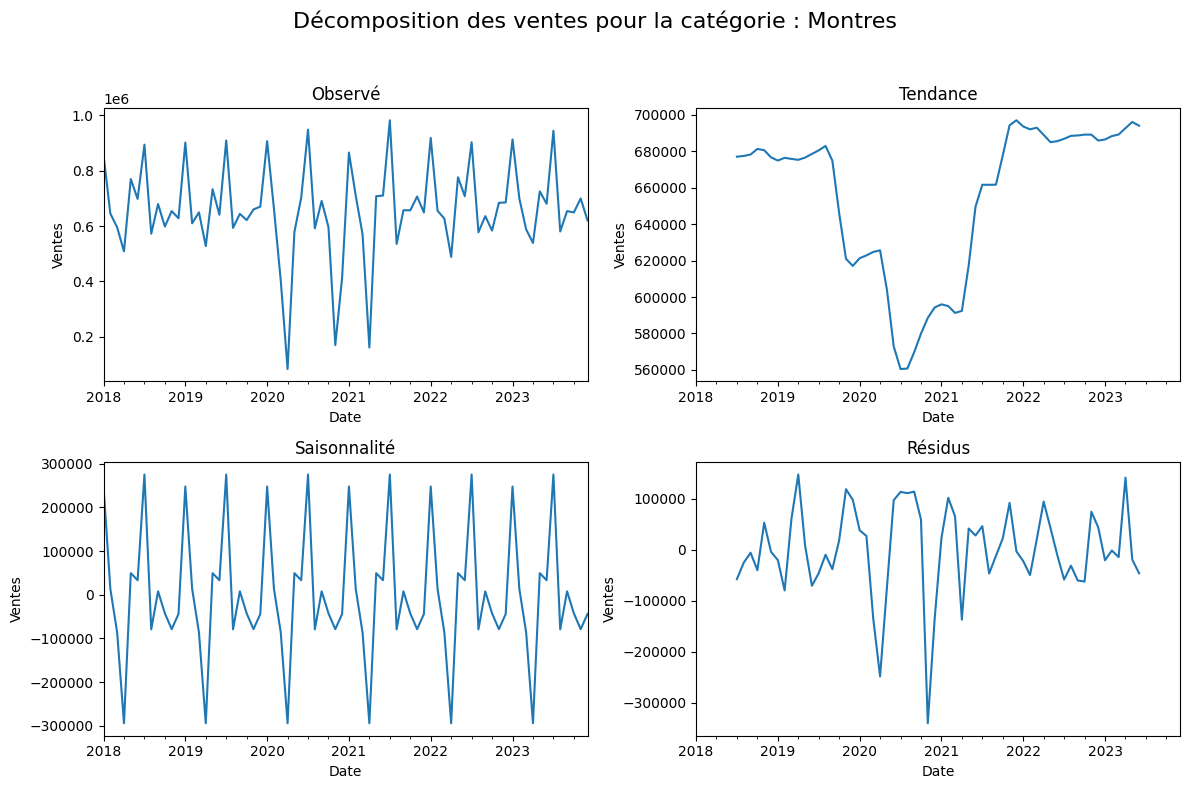

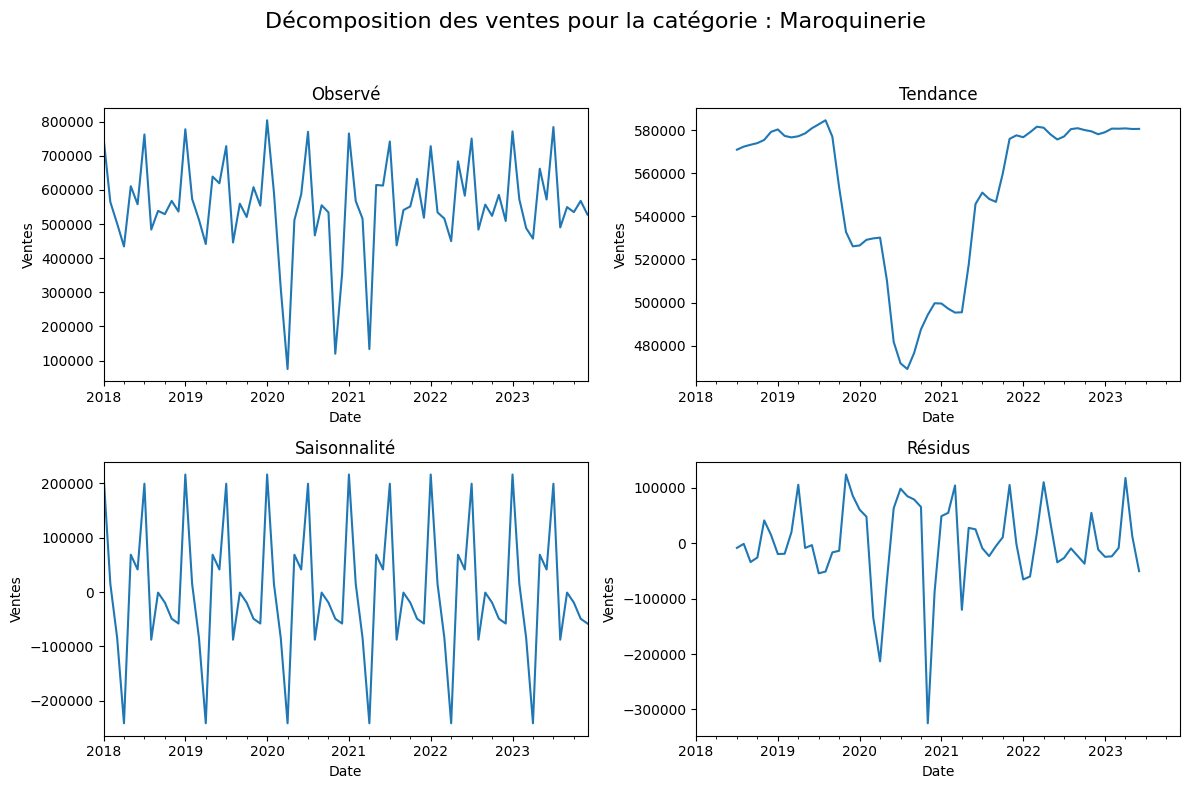

In [ ]:
def analyze_seasonality(category):
    category_sales = data[data['Catégorie'] == category].groupby(data['Date'].dt.to_period('M'))['Montant des ventes'].sum()
    category_sales = category_sales.to_timestamp()

    decomposition = sm.tsa.seasonal_decompose(category_sales, model='additive')

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Décomposition des ventes pour la catégorie : {category}", fontsize=16)

    decomposition.observed.plot(ax=axes[0, 0], title='Observé')
    axes[0, 0].set_ylabel("Ventes")

    decomposition.trend.plot(ax=axes[0, 1], title='Tendance')
    axes[0, 1].set_ylabel("Ventes")

    decomposition.seasonal.plot(ax=axes[1, 0], title='Saisonnalité')
    axes[1, 0].set_ylabel("Ventes")

    decomposition.resid.plot(ax=axes[1, 1], title='Résidus')
    axes[1, 1].set_ylabel("Ventes")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

categories = data['Catégorie'].unique()
for category in categories:
    analyze_seasonality(category)


**1. Tendance commune :**

Toutes les catégories ont connu une baisse marquée en raison des effets de la pandémie mondiale.
Fermeture des boutiques physiques et baisse de la consommation générale.
La reprise en 2021 montre une résilience progressive mais à des rythmes différents selon les catégories.

**2. Saisonnalité :**

Les catégories Joaillerie, Montres, et Mode montrent une forte dépendance à des périodes spécifiques comme décembre (fêtes) et juin (mariages ou événements estivaux).
Les Parfums et Accessoires sont plus stables, avec des pics plus modérés.

**3. Résidus :**

Les catégories comme Joaillerie et Montres montrent des variations résiduelles significatives, indiquant des événements ou perturbations spécifiques tels que :
* Mariages : Forte influence culturelle et émotionnelle.
* Lancements exclusifs : Nouveaux produits ou collections limitées.
* Événements économiques : Changements de prix des matériaux comme l'or ou les métaux précieux.

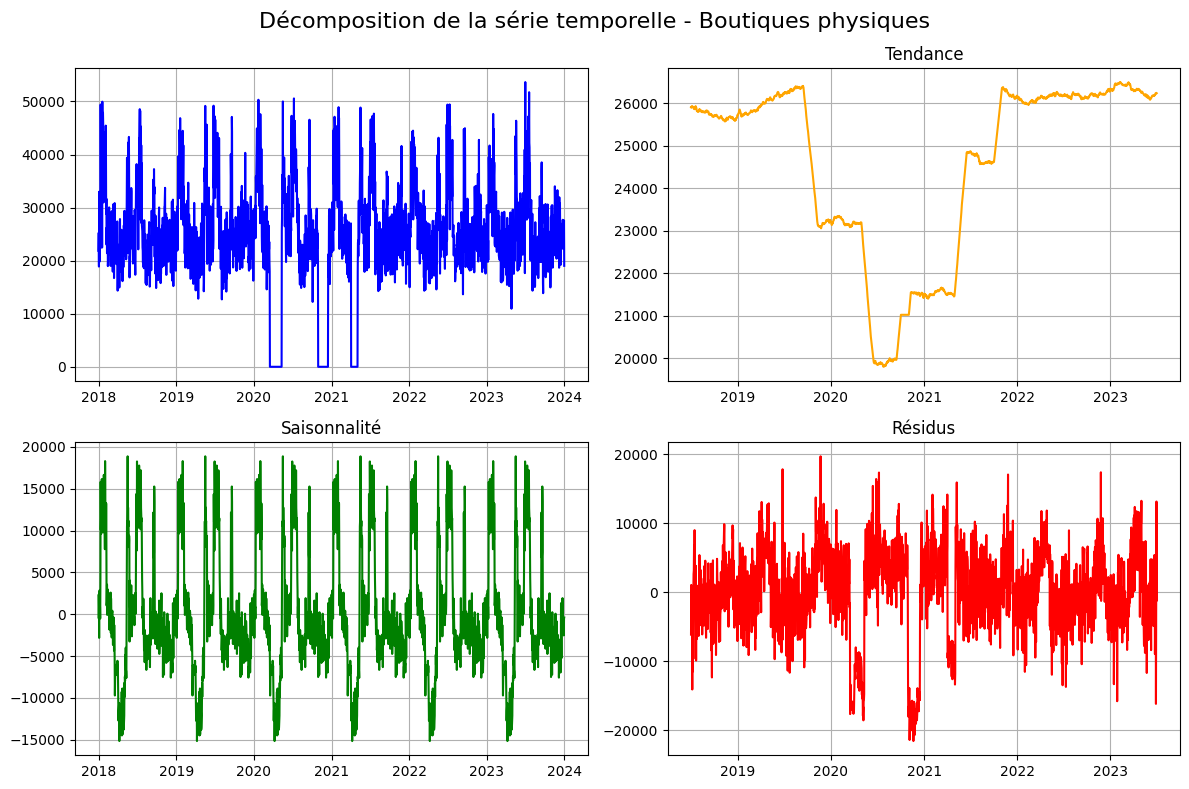

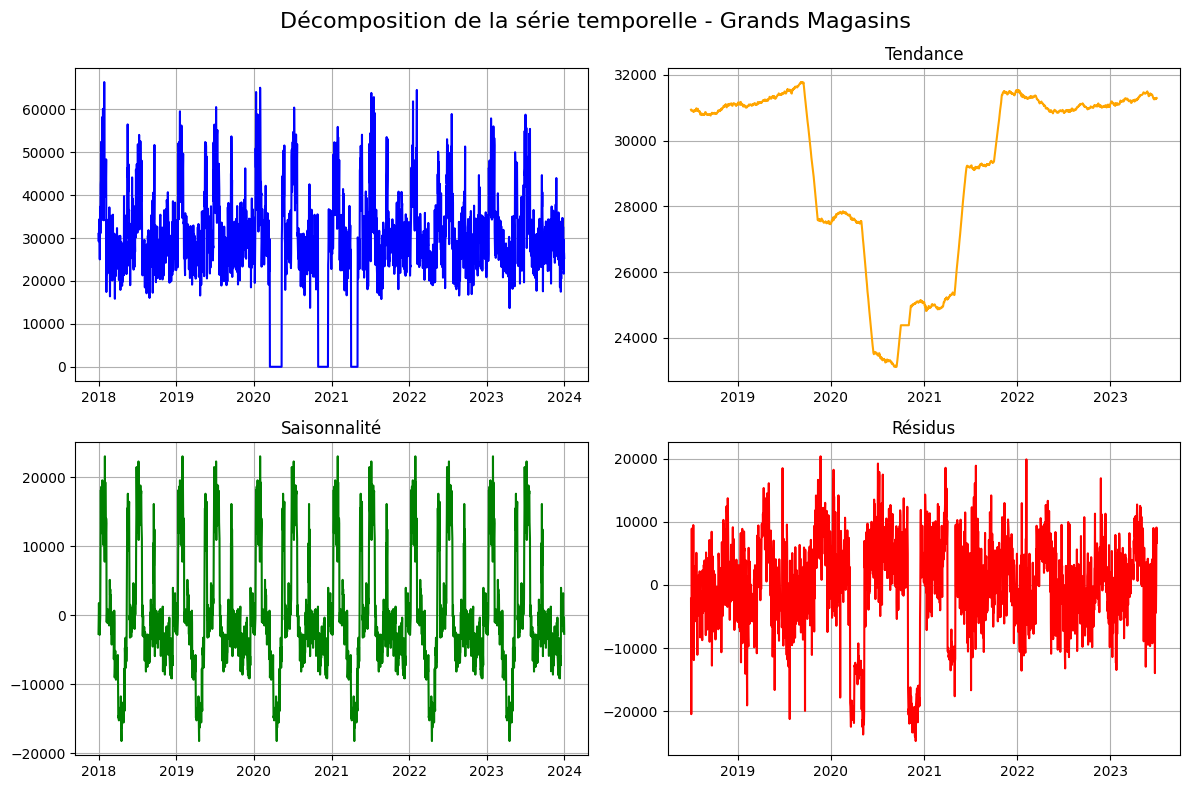

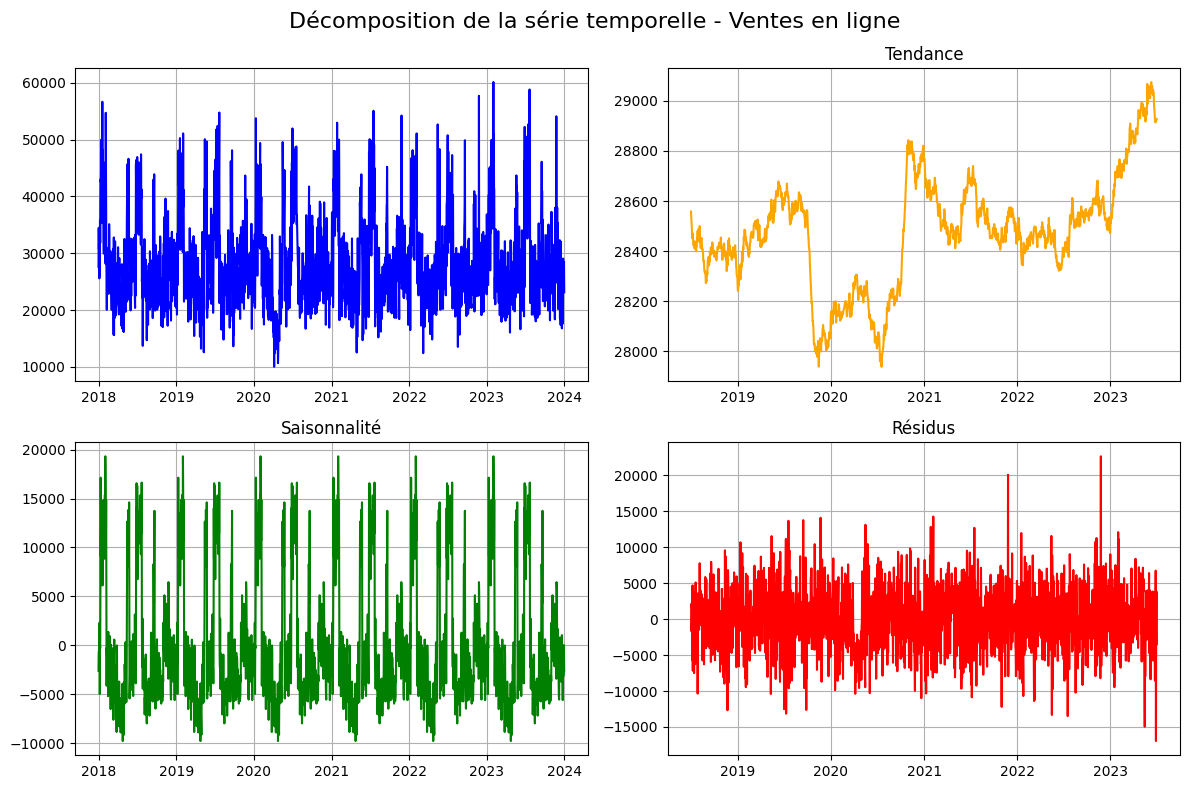

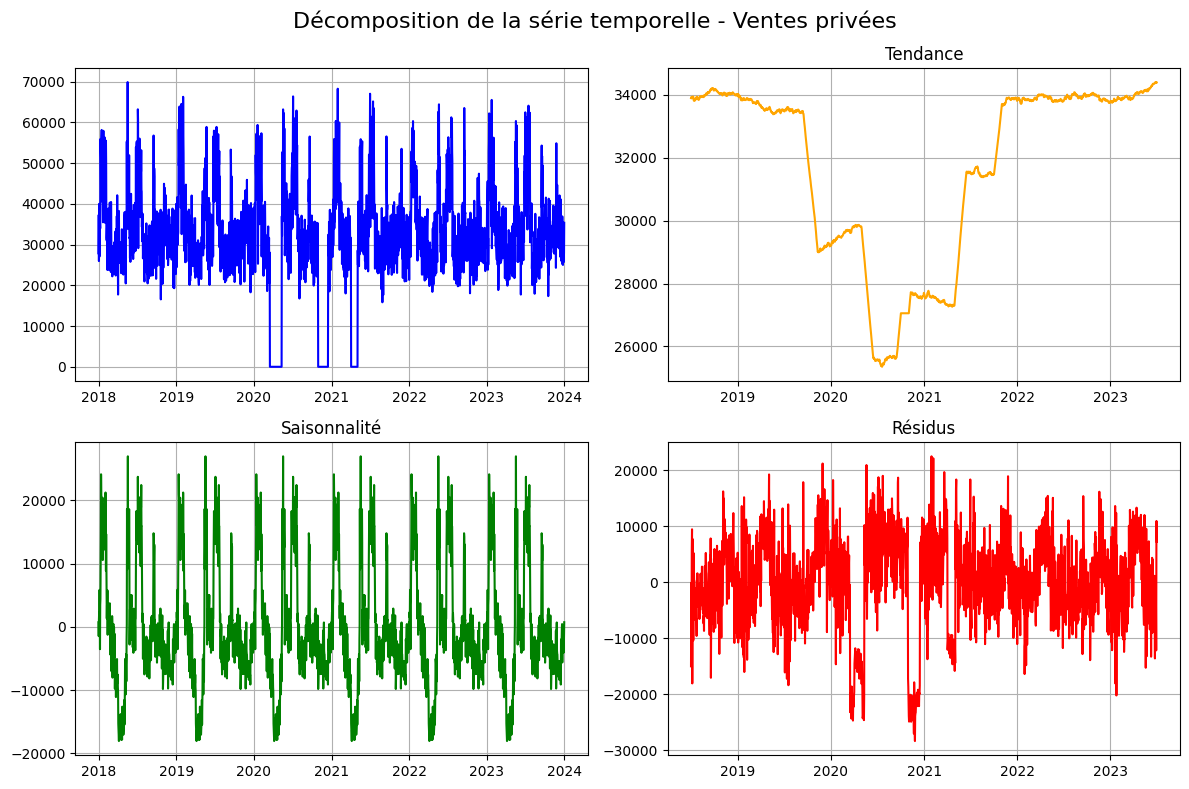

In [ ]:
aggregated_data = data.groupby(['Date', 'Canal de vente'])['Montant des ventes'].sum().reset_index()

sales_per_channel = aggregated_data.pivot(index='Date', columns='Canal de vente', values='Montant des ventes')

channels = sales_per_channel.columns

def plot_decomposition(ts, channel):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=365)

    observed = decomposition.observed
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

    axes[0, 0].plot(observed, label='Observé', color='blue')
    axes[0, 0].grid(True)

    axes[0, 1].plot(trend, label='Tendance', color='orange')
    axes[0, 1].set_title('Tendance')
    axes[0, 1].grid(True)

    axes[1, 0].plot(seasonal, label='Saisonnalité', color='green')
    axes[1, 0].set_title('Saisonnalité')
    axes[1, 0].grid(True)

    axes[1, 1].plot(resid, label='Résidus', color='red')
    axes[1, 1].set_title('Résidus')
    axes[1, 1].grid(True)

    fig.suptitle(f"Décomposition de la série temporelle - {channel}", fontsize=16)
    plt.show()

for channel in channels:
  ts = sales_per_channel[channel].dropna()
  plot_decomposition(ts, channel)


**1. Canal dominant : Ventes en ligne**

La tendance montre une croissance continue, avec une résilience remarquable face aux perturbations de 2020.
Ce canal est moins dépendant des fluctuations saisonnières que les canaux physiques.

**2. Canaux physiques (Boutiques, Grands Magasins, Ventes privées) :**

Tous ces canaux ont été fortement impactés par les perturbations de 2020.
La reprise est visible, mais la dépendance aux cycles saisonniers (pics en décembre et juin) reste très marquée.

**3. Stabilité :**

Les ventes en ligne offrent une stabilité, tandis que les canaux physiques sont plus sensibles aux événements extérieurs et saisonniers.


# **Machine Learning**


## **Stationnarité**


--- Analyse de la stationnarité pour le canal : Boutiques physiques ---



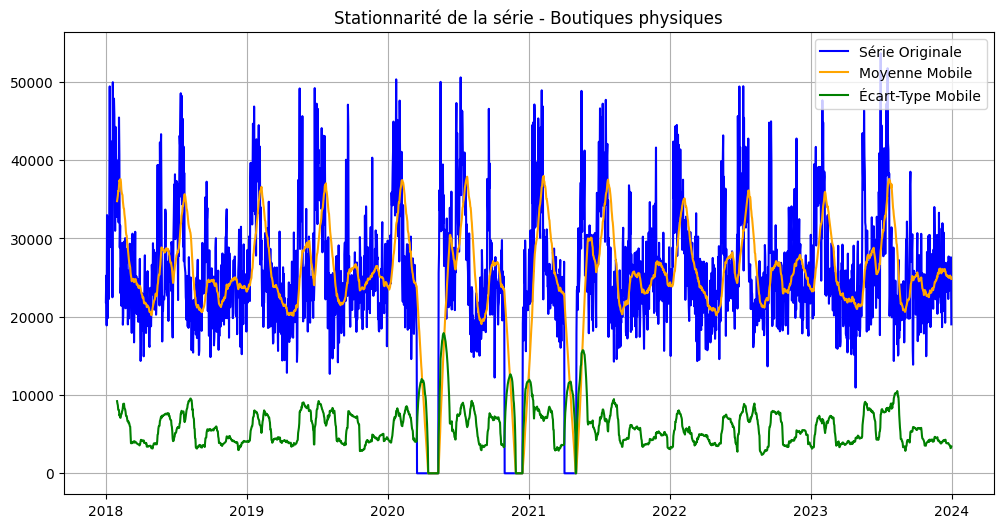

Test ADF :
  - Statistique de test : -6.7361
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.433344965914077, '5%': -2.8628630765096195, '10%': -2.567474338973205}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Grands Magasins ---



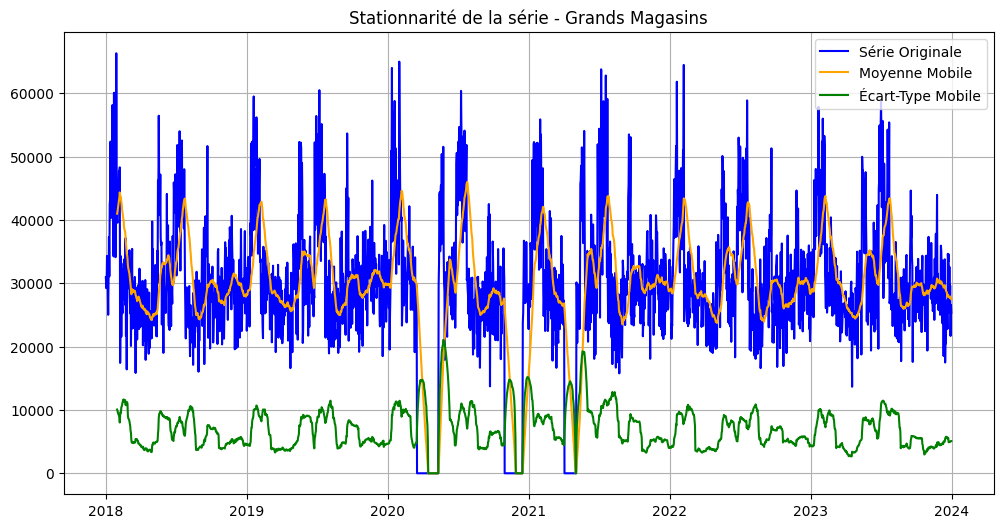

Test ADF :
  - Statistique de test : -7.0097
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.433344965914077, '5%': -2.8628630765096195, '10%': -2.567474338973205}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Ventes en ligne ---



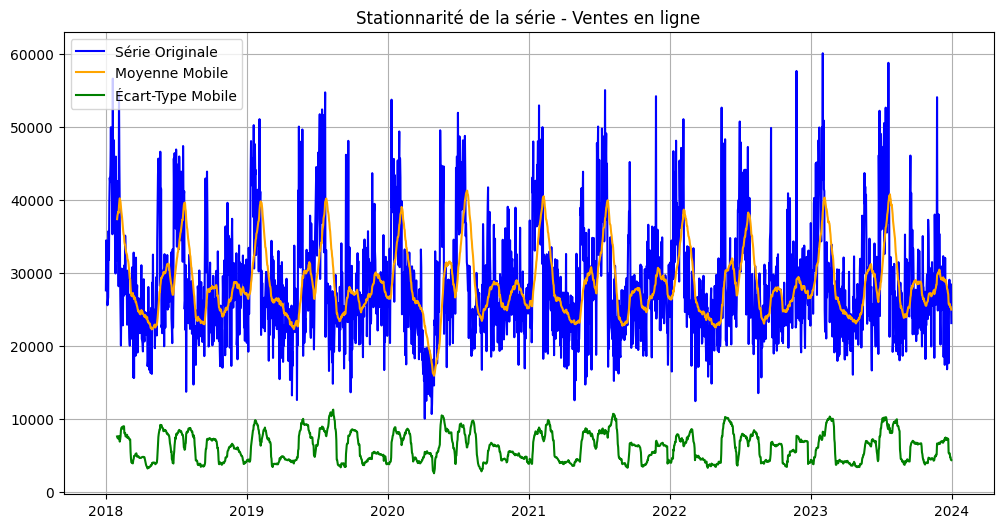

Test ADF :
  - Statistique de test : -9.1244
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.4333740509447717, '5%': -2.8628759187993382, '10%': -2.567481176655697}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Ventes privées ---



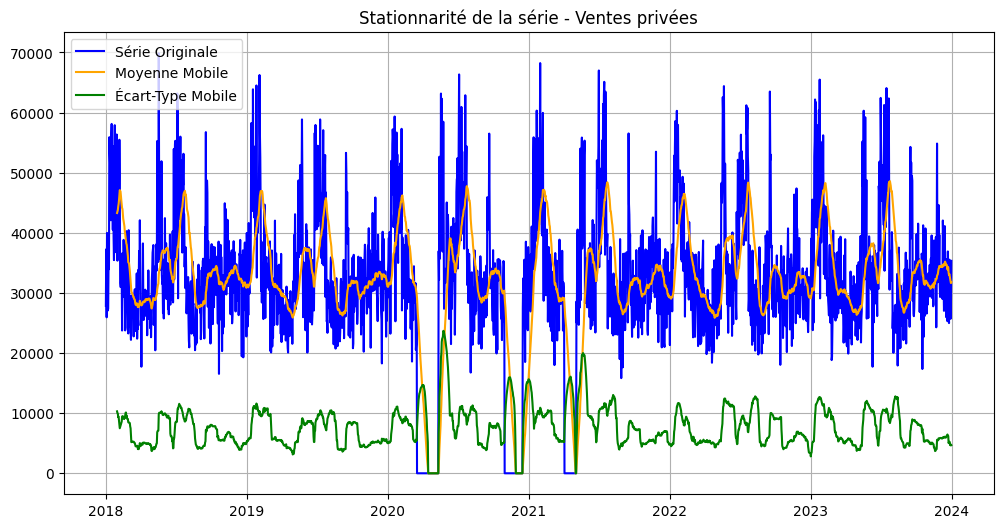

Test ADF :
  - Statistique de test : -6.5639
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.4333477117905487, '5%': -2.8628642889373044, '10%': -2.5674749845110627}
=> La série est stationnaire (p-valeur <= 0.05).


In [ ]:
def check_stationarity(ts, channel):
    print(f"\n--- Analyse de la stationnarité pour le canal : {channel} ---\n")

    rolling_mean = ts.rolling(window=30).mean()
    rolling_std = ts.rolling(window=30).std()

    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Série Originale', color='blue')
    plt.plot(rolling_mean, label='Moyenne Mobile', color='orange')
    plt.plot(rolling_std, label='Écart-Type Mobile', color='green')
    plt.title(f"Stationnarité de la série - {channel}")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    adf_result = adfuller(ts.dropna())
    print("Test ADF :")
    print(f"  - Statistique de test : {adf_result[0]:.4f}")
    print(f"  - P-valeur : {adf_result[1]:.4f}")
    print(f"  - Valeurs critiques : {adf_result[4]}")

    if adf_result[1] <= 0.05:
        print("=> La série est stationnaire (p-valeur <= 0.05).")
    else:
        print("=> La série n'est pas stationnaire (p-valeur > 0.05).")

for channel in channels:
    ts = sales_per_channel[channel].dropna()
    check_stationarity(ts, channel)


Le test de stationnarité des séries révèlent que les séries sont stationnaire mais ils sont pas stationnaire en variance en raison des fluctuations importantes et répétées dans l'amplitude des données observées. Sur le graphique, on remarque que les pics de ventes, bien qu'ils suivent une saisonnalité régulière, présentent des amplitudes variables selon les périodes. Ces variations ne sont pas constantes, ce qui reflète une hétéroscédasticité dans les données. De plus, l'écart-type mobile (courbe verte), qui est censé refléter la dispersion autour de la moyenne, montre des oscillations significatives et non constantes au fil du temps. Ces variations indiquent que les données sont influencées par des facteurs saisonniers ou événementiels, rendant la variance dépendante du temps. Ce comportement empêche la série d'être stationnaire en variance, car une série stationnaire devrait avoir une dispersion constante autour de sa moyenne sur l'ensemble de la période. Ceci pose déjà un problème. Mais nous allons garder la série ainsi et modèliser un arima pour voir les résultats

## **ACF et PACF**

* p : Ordre AR (Autoregressive) - basé sur le PACF.
* q : Ordre MA (Moving Average) - basé sur l'ACF.
* d : Différenciation - ici, déjà déterminé comme 0 puisque nos séries sont stationnaires.


--- ACF et PACF pour le canal : Boutiques physiques ---


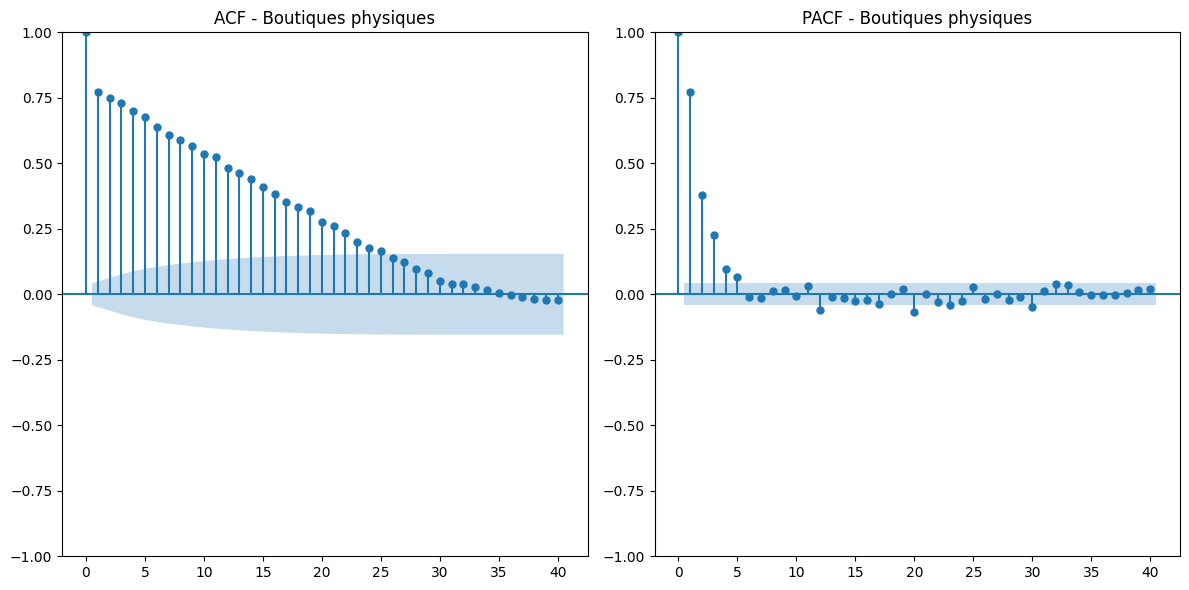


--- ACF et PACF pour le canal : Grands Magasins ---


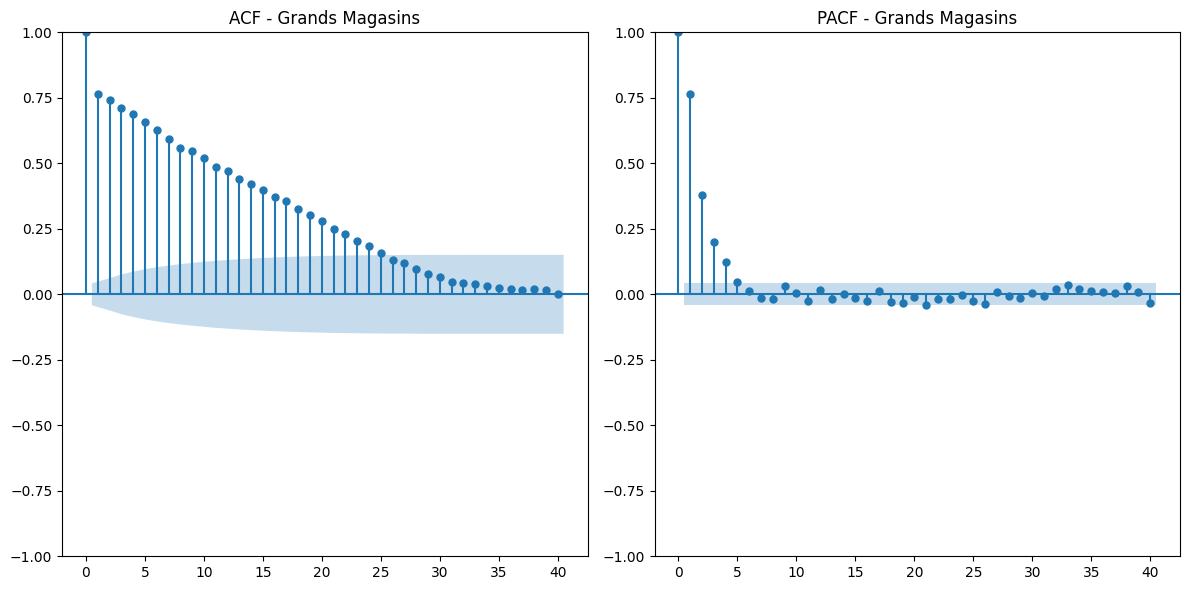


--- ACF et PACF pour le canal : Ventes en ligne ---


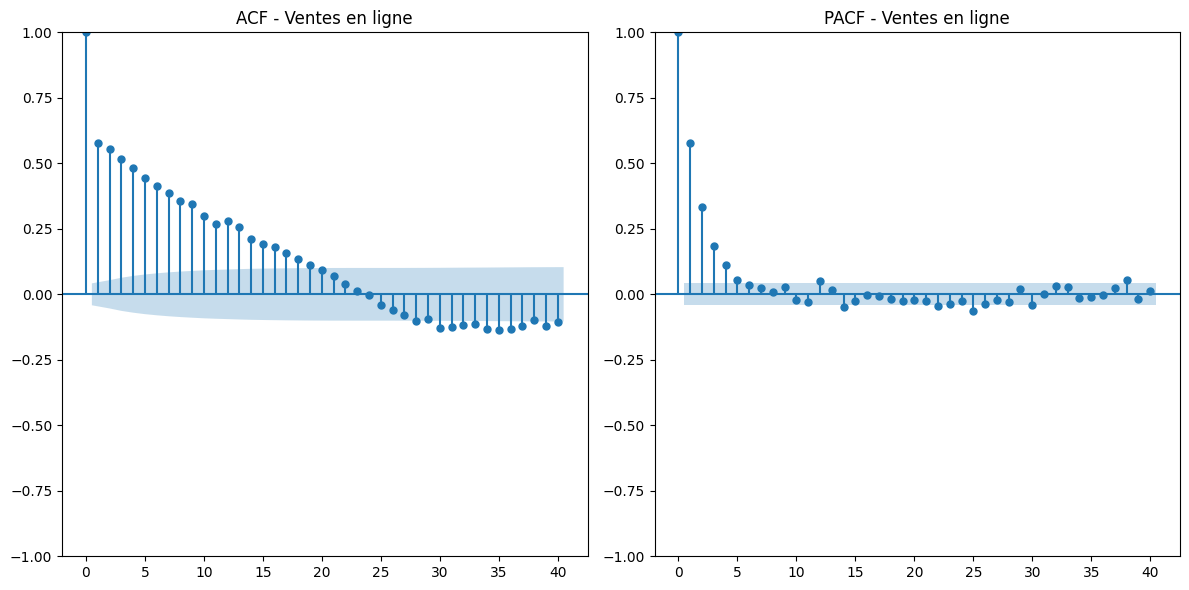


--- ACF et PACF pour le canal : Ventes privées ---


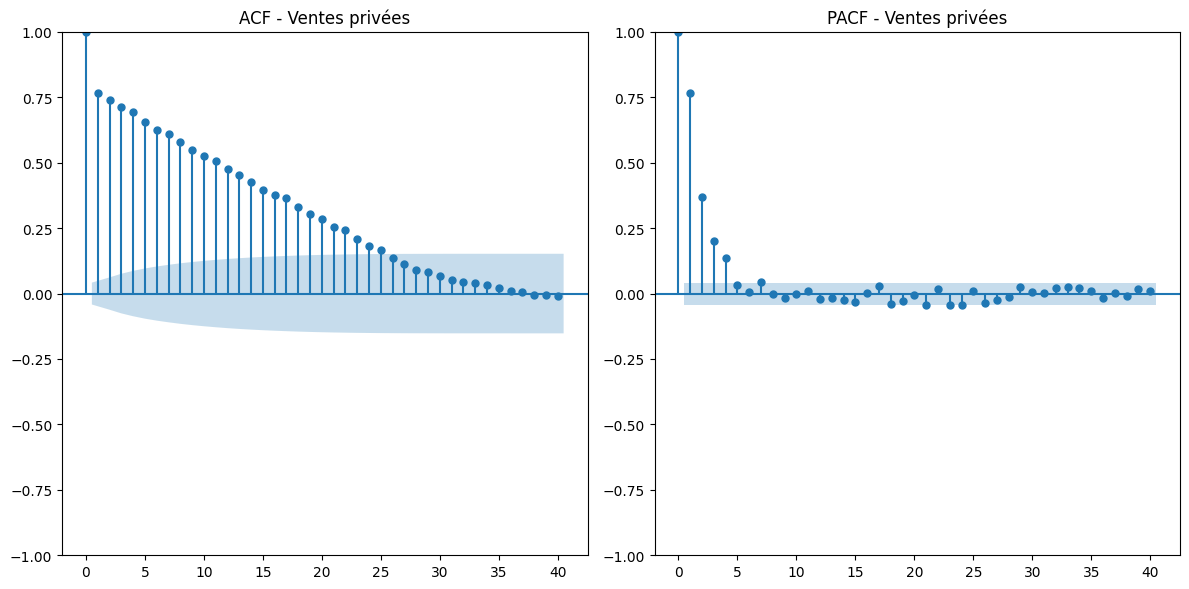

In [ ]:
def plot_acf_pacf(ts, channel):
    """
    Fonction pour tracer les ACF et PACF d'une série temporelle.
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_acf(ts, lags=40, ax=plt.gca(), title=f"ACF - {channel}")

    plt.subplot(1, 2, 2)
    plot_pacf(ts, lags=40, ax=plt.gca(), method='ywm', title=f"PACF - {channel}")

    plt.tight_layout()
    plt.show()

for channel in channels:
    ts = sales_per_channel[channel].dropna()
    print(f"\n--- ACF et PACF pour le canal : {channel} ---")
    plot_acf_pacf(ts, channel)


De l'analyse de ces graphiques, on peut remarquer qu'il n'y a pas de coupure nette de l'ACF après le premier retard. L'ACF montre une décroissance progressive sur plusieurs retards (lags), ce qui suggère la présence de dépendances à long terme ou une tendance non stationnaire. Mais les séries étant stationnaire, on peut attribuer ces retards à la présence de dépendance de long terme. Nous avons donc la possibilité de tester plusieurs valeurs de **q** jusqu'à 10. Le PACF par contre, montre une chute rapide après le premier ou deuxième décalage (lags 1 et 2). Cette chute rapide est caractéristique d’un processus auto-régressif (AR) d’ordre faible. Mais nous allons tester plusieurs valeurs de **p** entre 1 et 5 grâce à un gridSearch

## **ARIMA**

### **Canal : Boutiques physiques**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,0,1) - AIC : 43857.70
ARIMA(1,0,2) - AIC : 43856.52
ARIMA(1,0,3) - AIC : 43854.70
ARIMA(1,0,4) - AIC : 43856.71
ARIMA(1,0,5) - AIC : 43858.33
ARIMA(1,0,6) - AIC : 43857.64
ARIMA(1,0,7) - AIC : 43859.65
ARIMA(1,0,8) - AIC : 43859.89
ARIMA(1,0,9) - AIC : 43860.38
ARIMA(2,0,1) - AIC : 43857.04
ARIMA(2,0,2) - AIC : 43844.74
ARIMA(2,0,3) - AIC : 43856.73
ARIMA(2,0,4) - AIC : 43858.63
ARIMA(2,0,5) - AIC : 43856.09
ARIMA(2,0,6) - AIC : 43860.53
ARIMA(2,0,7) - AIC : 43861.80
ARIMA(2,0,8) - AIC : 43863.77
ARIMA(2,0,9) - AIC : 43858.32
ARIMA(3,0,1) - AIC : 43855.35
ARIMA(3,0,2) - AIC : 43857.22
ARIMA(3,0,3) - AIC : 43854.51
ARIMA(3,0,4) - AIC : 43856.02
ARIMA(3,0,5) - AIC : 43856.23
ARIMA(3,0,6) - AIC : 43857.52
ARIMA(3,0,7) - AIC : 43858.37
ARIMA(3,0,8) - AIC : 43864.79
ARIMA(3,0,9) - AIC : 43860.40
ARIMA(4,0,1) - AIC : 43857.14
ARIMA(4,0,2) - AIC : 43846.57
ARIMA(4,0,3) - AIC : 43847.38
ARIMA(4,0,4) - AIC : 43846.62
ARIMA(4,0,

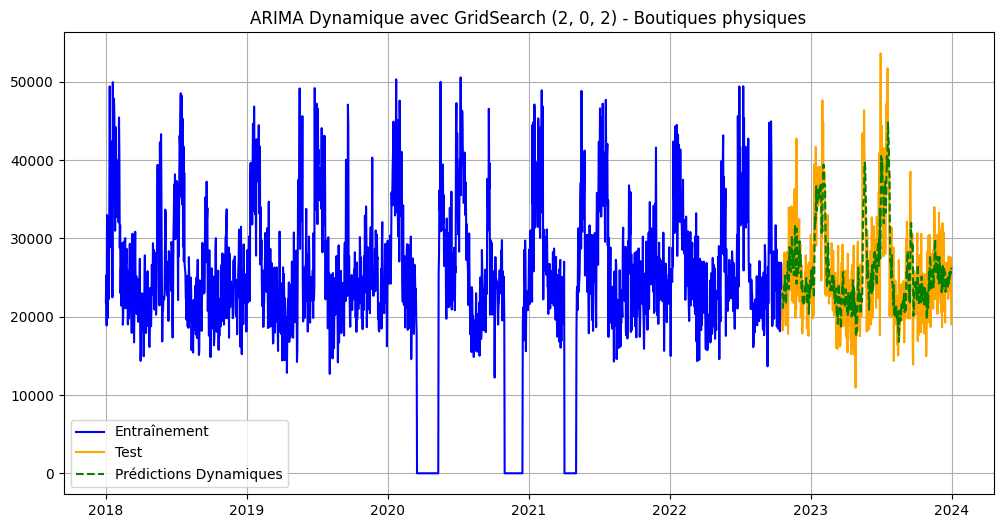

In [ ]:
def gridsearch_arima(ts, p_range, q_range, d=0):
    """
    Effectue une recherche par grille pour trouver les meilleurs paramètres p et q.
    """
    print("\n--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---")
    best_aic = float('inf')
    best_order = None
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(ts, order=(p, d, q))
                model_fit = model.fit()

                aic = model_fit.aic
                results.append(((p, d, q), aic))
                print(f"ARIMA({p},{d},{q}) - AIC : {aic:.2f}")

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) - Échec : {e}")
                continue

    print(f"\nMeilleur modèle : ARIMA{best_order} - AIC : {best_aic:.2f}")
    return best_order

def fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel):
    """
    Modélisation ARIMA dynamique avec sélection automatique des paramètres p et q.
    """
    best_order = gridsearch_arima(ts, p_range, q_range, d)

    model = ARIMA(ts, order=best_order)
    best_model_fit = model.fit()

    print(best_model_fit.summary())

    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]

    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=1)[0]
        predictions.append(forecast)

        history.append(test.iloc[t])

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE sur les données de test : {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Entraînement', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, predictions, label='Prédictions Dynamiques', color='green', linestyle='--')
    plt.title(f"ARIMA Dynamique avec GridSearch ({best_order[0]}, {best_order[1]}, {best_order[2]}) - {channel}")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


p_range = range(1, 5)
q_range = range(1, 10)
d = 0

channel = 'Boutiques physiques'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel)


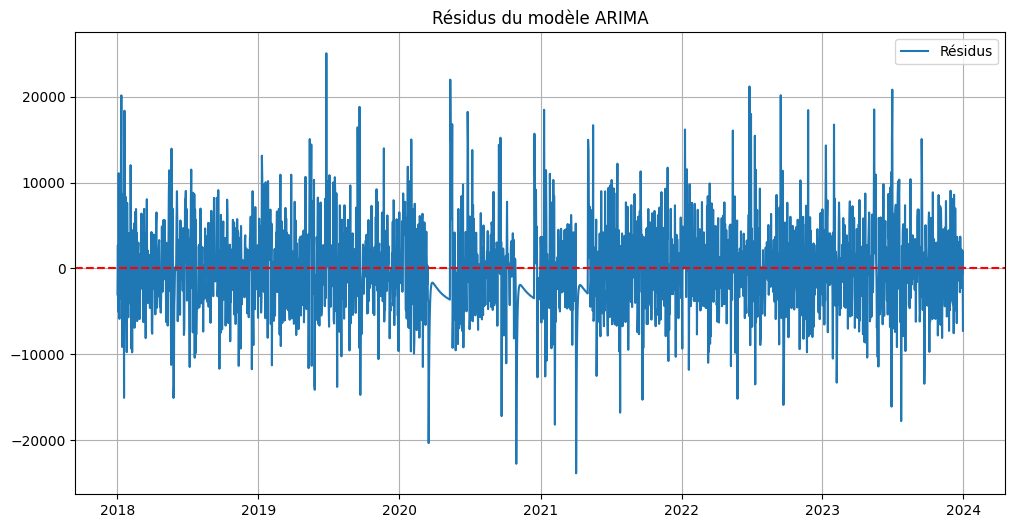

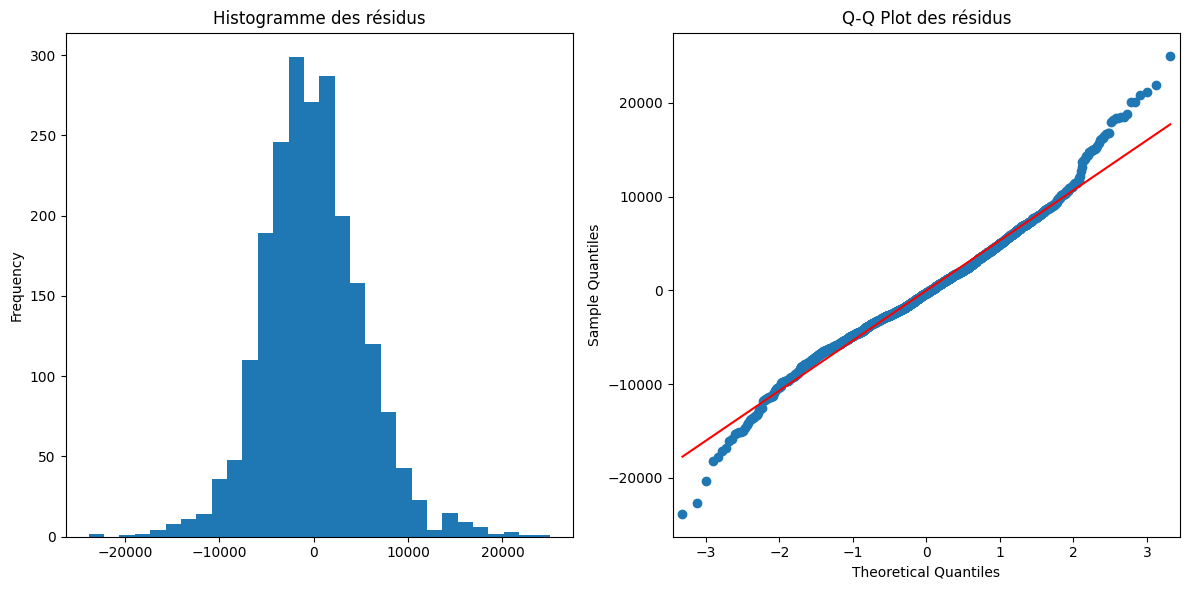

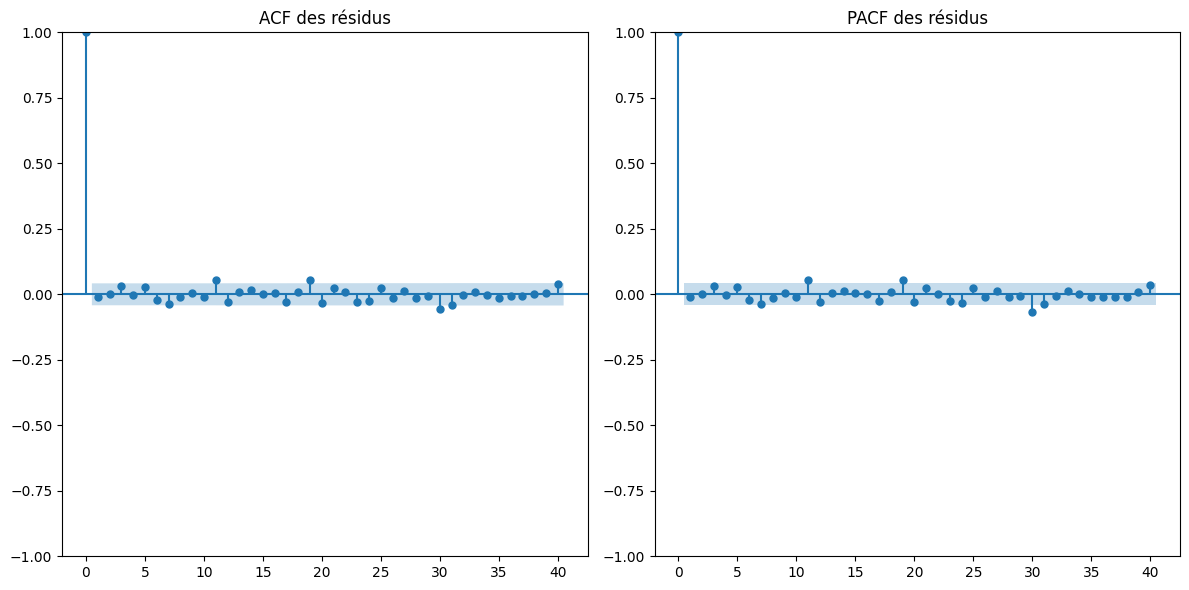


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
def analyze_residuals(model_fit):
    """
    Analyse les résidus d'un modèle ARIMA pour vérifier les hypothèses.
    """
    residuals = model_fit.resid

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Résidus")
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Résidus du modèle ARIMA")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    residuals.plot(kind='hist', bins=30, ax=axes[0], title="Histogramme des résidus")
    sm.qqplot(residuals, line='s', ax=axes[1])
    axes[1].set_title("Q-Q Plot des résidus")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[0], title="ACF des résidus")
    sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axes[1], title="PACF des résidus")
    plt.tight_layout()
    plt.show()

    print("\n--- Interprétation ACF/PACF ---")
    print("=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).")


model = ARIMA(ts, order=(2, 0, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)


**Interprètation**

Le modèle ARIMA(2,0,2), sélectionné via une recherche par grille sur le critère AIC (43844.74), montre une capacité raisonnable à capturer les dynamiques de la série temporelle pour les "Boutiques physiques". Les coefficients des termes AR et MA sont significatifs, reflétant des dépendances importantes à court terme. Le modèle produit des prédictions dynamiques avec un RMSE de 5268.11, ce qui indique une performance moyenne, avec certaines variations non totalement capturées donc une incertitude dans les prédictions pour les valeurs futures. Les tests diagnostiques (Ljung-Box et Jarque-Bera) suggèrent des résidus indépendants mais non parfaitement normaux, avec une leptokurtose marquée. Bien que le modèle ARIMA(2,0,2) soit fonctionnel, une amélioration potentielle pourrait être obtenue.

### **Canal : Grands Magasins**



--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,0,1) - AIC : 44695.73
ARIMA(1,0,2) - AIC : 44694.75
ARIMA(1,0,3) - AIC : 44695.46
ARIMA(1,0,4) - AIC : 44695.32
ARIMA(1,0,5) - AIC : 44697.31
ARIMA(1,0,6) - AIC : 44699.26
ARIMA(1,0,7) - AIC : 44700.72
ARIMA(1,0,8) - AIC : 44702.70
ARIMA(1,0,9) - AIC : 44700.97
ARIMA(2,0,1) - AIC : 44695.28
ARIMA(2,0,2) - AIC : 44694.34
ARIMA(2,0,3) - AIC : 44696.29
ARIMA(2,0,4) - AIC : 44697.32
ARIMA(2,0,5) - AIC : 44699.31
ARIMA(2,0,6) - AIC : 44701.33
ARIMA(2,0,7) - AIC : 44703.27
ARIMA(2,0,8) - AIC : 44704.43
ARIMA(2,0,9) - AIC : 44702.95
ARIMA(3,0,1) - AIC : 44696.38
ARIMA(3,0,2) - AIC : 44696.24
ARIMA(3,0,3) - AIC : 44697.97
ARIMA(3,0,4) - AIC : 44698.10
ARIMA(3,0,5) - AIC : 44699.60
ARIMA(3,0,6) - AIC : 44700.58
ARIMA(3,0,7) - AIC : 44703.79
ARIMA(3,0,8) - AIC : 44700.80
ARIMA(3,0,9) - AIC : 44701.59
ARIMA(4,0,1) - AIC : 44695.75
ARIMA(4,0,2) - AIC : 44696.97
ARIMA(4,0,3) - AIC : 44700.27
ARIMA(4,0,4) - AIC : 44699.63
ARIMA(4,0,

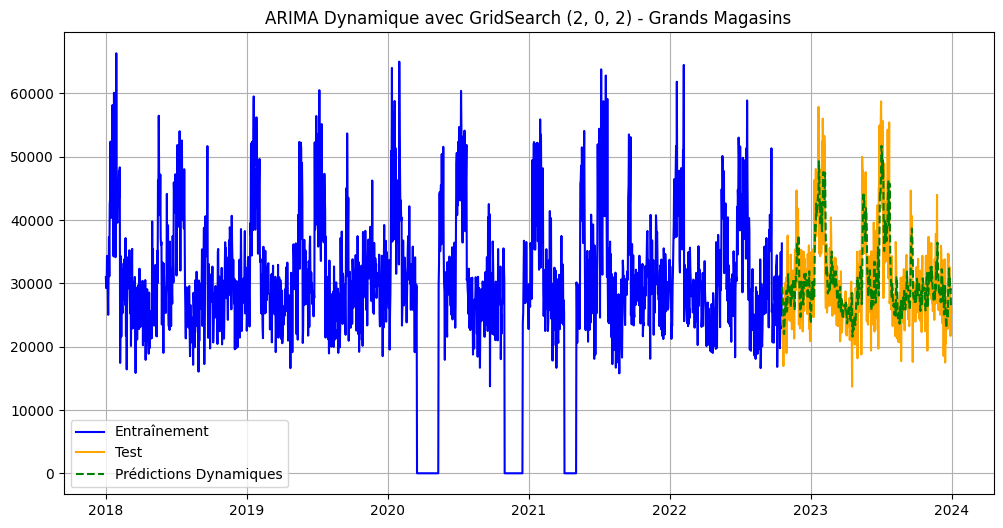

In [ ]:
channel = 'Grands Magasins'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel)

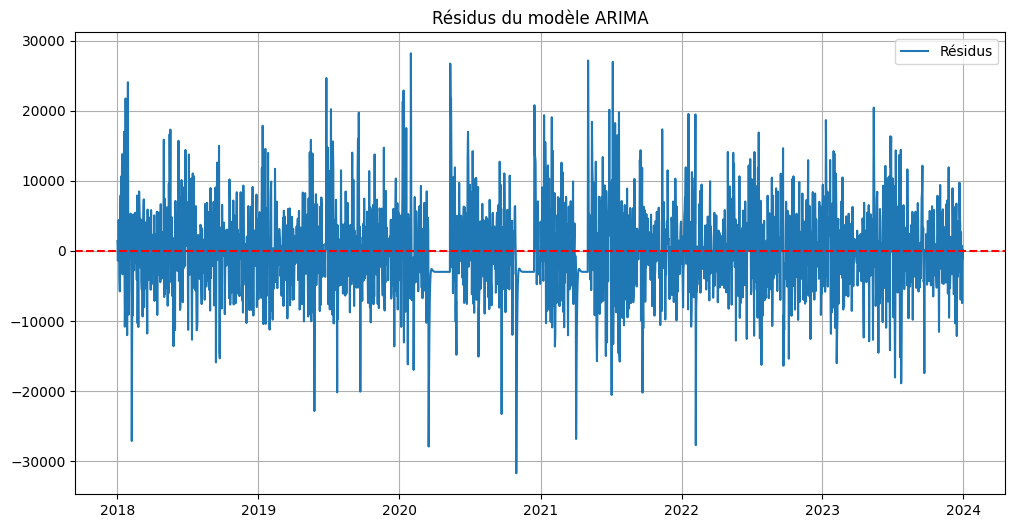

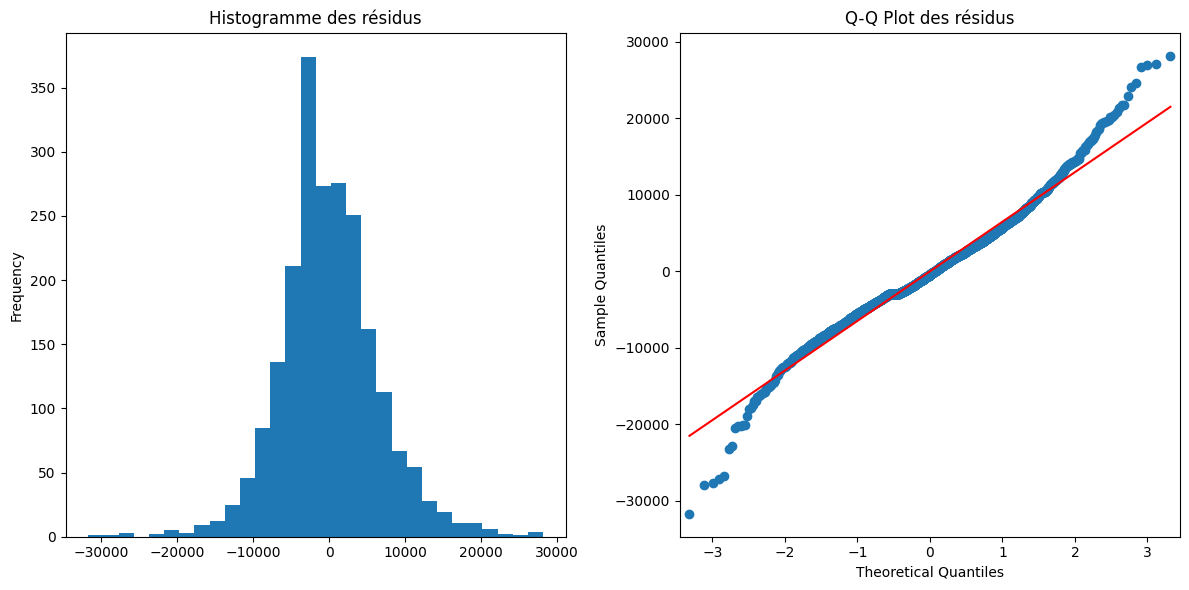

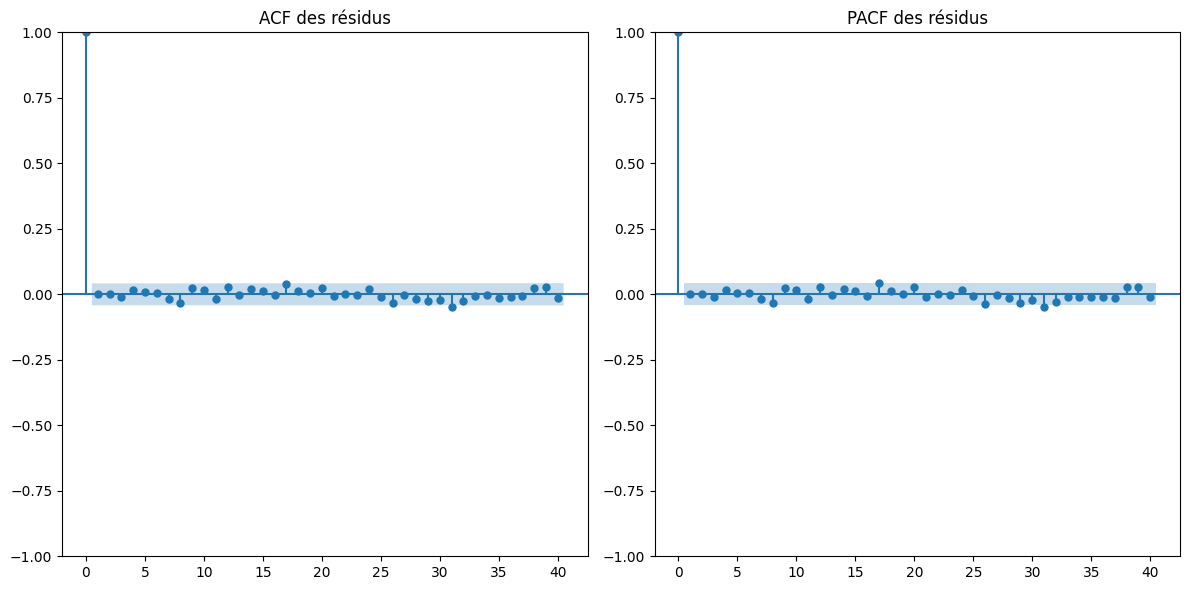


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
model = ARIMA(ts, order=(2, 0, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

**Interprètation**

Le modèle ARIMA(2,0,2), sélectionné avec le critère AIC (44694.34), capture raisonnablement les dynamiques des ventes pour les "Grands Magasins", avec des termes AR(1) et AR(2) significatifs, ainsi que des termes MA(1) et MA(2). Les diagnostics montrent des résidus indépendants (test Ljung-Box), mais non parfaitement normaux (Jarque-Bera), avec une leptokurtose marquée (kurtosis de 4.85). Bien que les prédictions dynamiques suivent globalement la série test, la forte volatilité des données conduit à un RMSE élevé (~6023.44).

### **Canal : Ventes en ligne**



--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,0,1) - AIC : 44249.61
ARIMA(1,0,2) - AIC : 44249.00
ARIMA(1,0,3) - AIC : 44250.97
ARIMA(1,0,4) - AIC : 44252.94
ARIMA(1,0,5) - AIC : 44254.89
ARIMA(1,0,6) - AIC : 44256.70
ARIMA(1,0,7) - AIC : 44258.60
ARIMA(1,0,8) - AIC : 44260.51
ARIMA(1,0,9) - AIC : 44261.90
ARIMA(2,0,1) - AIC : 44249.37
ARIMA(2,0,2) - AIC : 44250.97
ARIMA(2,0,3) - AIC : 44252.98
ARIMA(2,0,4) - AIC : 44254.94
ARIMA(2,0,5) - AIC : 44256.90
ARIMA(2,0,6) - AIC : 44258.74
ARIMA(2,0,7) - AIC : 44260.62
ARIMA(2,0,8) - AIC : 44262.59
ARIMA(2,0,9) - AIC : 44263.32
ARIMA(3,0,1) - AIC : 44251.34
ARIMA(3,0,2) - AIC : 44253.01
ARIMA(3,0,3) - AIC : 44255.42
ARIMA(3,0,4) - AIC : 44251.48
ARIMA(3,0,5) - AIC : 44252.68
ARIMA(3,0,6) - AIC : 44256.34
ARIMA(3,0,7) - AIC : 44257.00
ARIMA(3,0,8) - AIC : 44254.24
ARIMA(3,0,9) - AIC : 44257.79
ARIMA(4,0,1) - AIC : 44252.97
ARIMA(4,0,2) - AIC : 44254.89
ARIMA(4,0,3) - AIC : 44251.32
ARIMA(4,0,4) - AIC : 44252.86
ARIMA(4,0,

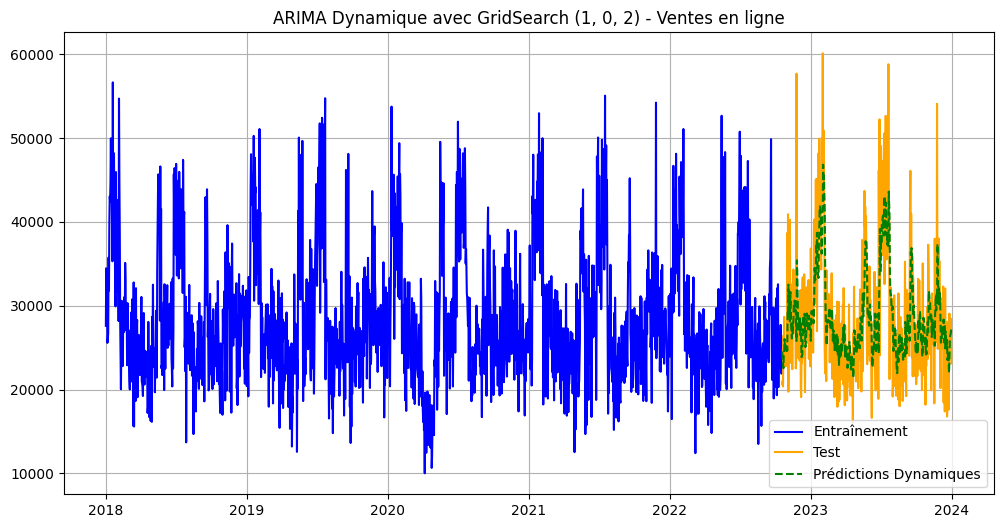

In [ ]:
channel = 'Ventes en ligne'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel)

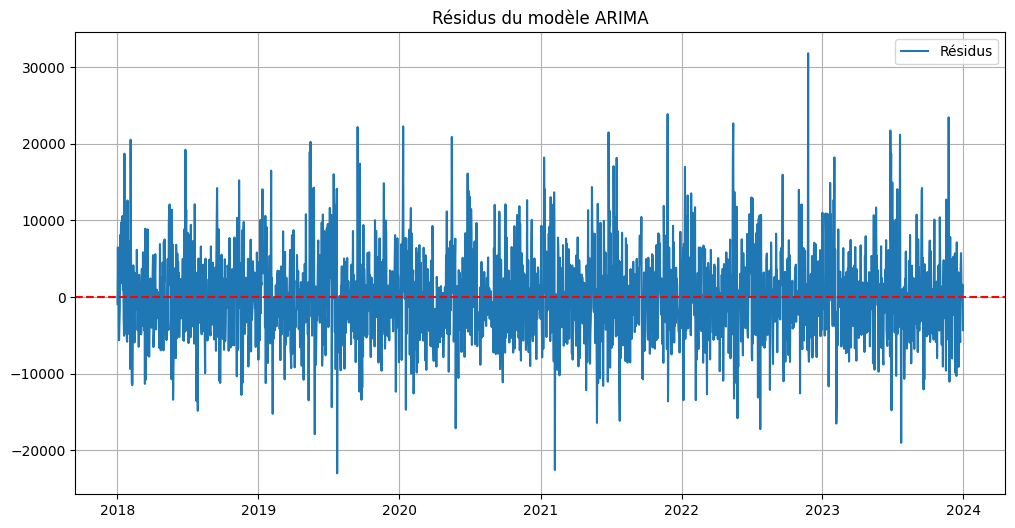

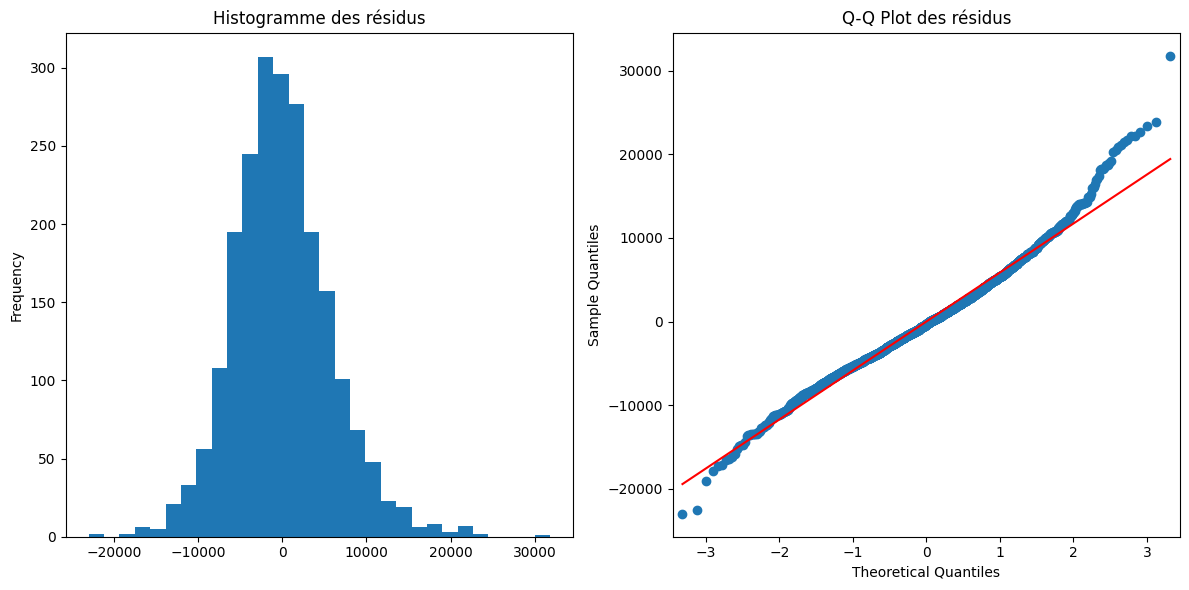

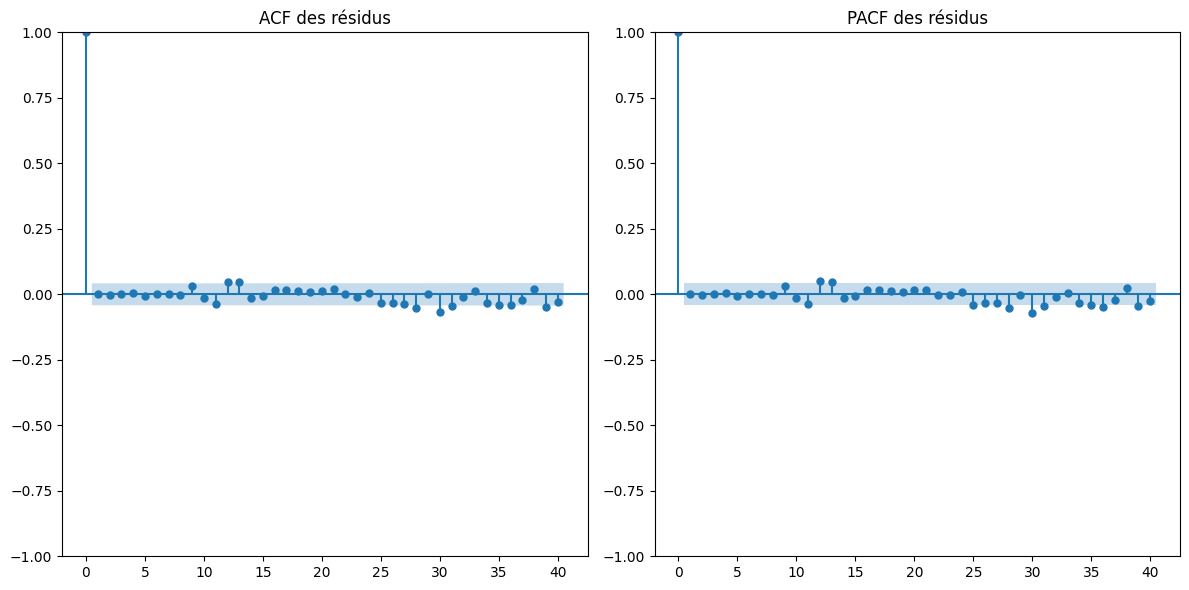


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
model = ARIMA(ts, order=(1, 0, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

**Interprétation**

Le modèle ARIMA(1,0,2) a été sélectionné comme le meilleur modèle selon le critère AIC (44249.00). Ce modèle intègre une dépendance auto-régressive d'ordre 1 AR(1) et deux termes de moyenne mobile MA(1)et MA(2). Les diagnostics montrent des résidus indépendants (Ljung-Box \(p = 0.99\)), mais non parfaitement normaux (Jarque-Bera \(p < 0.001\)), avec une légère leptokurtose (kurtosis = 4.39). Le graphique des prédictions dynamiques révèle que le modèle suit la tendance générale, mais les fortes variations des ventes restent mal capturées, comme en témoigne un RMSE élevé (\(5972.38\)).




### **Canal : Ventes privées**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,0,1) - AIC : 45064.10
ARIMA(1,0,2) - AIC : 45065.08
ARIMA(1,0,3) - AIC : 45066.25
ARIMA(1,0,4) - AIC : 45066.60
ARIMA(1,0,5) - AIC : 45067.46
ARIMA(1,0,6) - AIC : 45069.45
ARIMA(1,0,7) - AIC : 45067.71
ARIMA(1,0,8) - AIC : 45069.71
ARIMA(1,0,9) - AIC : 45071.71
ARIMA(2,0,1) - AIC : 45065.48
ARIMA(2,0,2) - AIC : 45067.29
ARIMA(2,0,3) - AIC : 45057.08
ARIMA(2,0,4) - AIC : 45067.99
ARIMA(2,0,5) - AIC : 45069.66
ARIMA(2,0,6) - AIC : 45070.60
ARIMA(2,0,7) - AIC : 45069.70
ARIMA(2,0,8) - AIC : 45071.73
ARIMA(2,0,9) - AIC : 45073.71
ARIMA(3,0,1) - AIC : 45066.79
ARIMA(3,0,2) - AIC : 45057.07
ARIMA(3,0,3) - AIC : 45068.36
ARIMA(3,0,4) - AIC : 45064.01
ARIMA(3,0,5) - AIC : 45060.25
ARIMA(3,0,6) - AIC : 45063.73
ARIMA(3,0,7) - AIC : 45071.70
ARIMA(3,0,8) - AIC : 45069.58
ARIMA(3,0,9) - AIC : 45069.05
ARIMA(4,0,1) - AIC : 45065.81
ARIMA(4,0,2) - AIC : 45067.61
ARIMA(4,0,3) - AIC : 45064.33
ARIMA(4,0,4) - AIC : 45057.74
ARIMA(4,0,

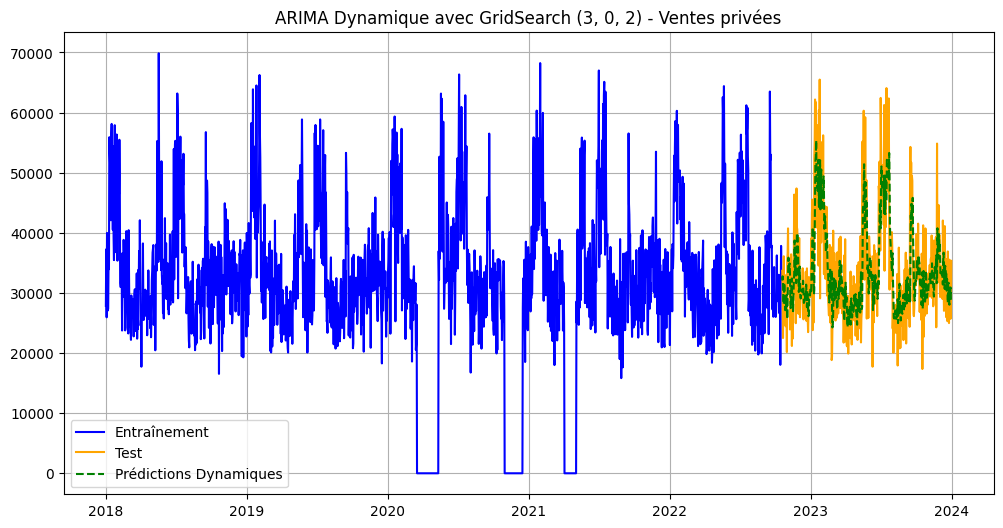

In [ ]:
channel = 'Ventes privées'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel)

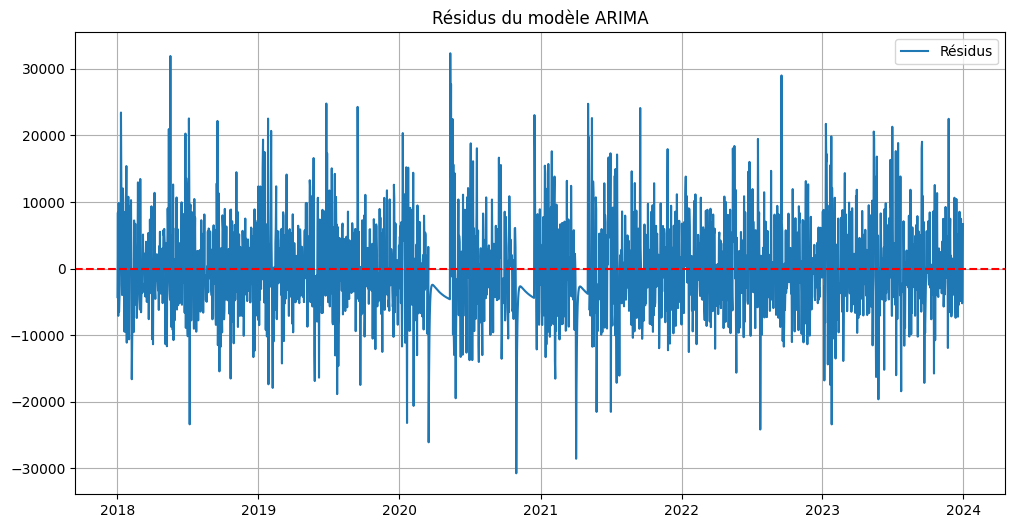

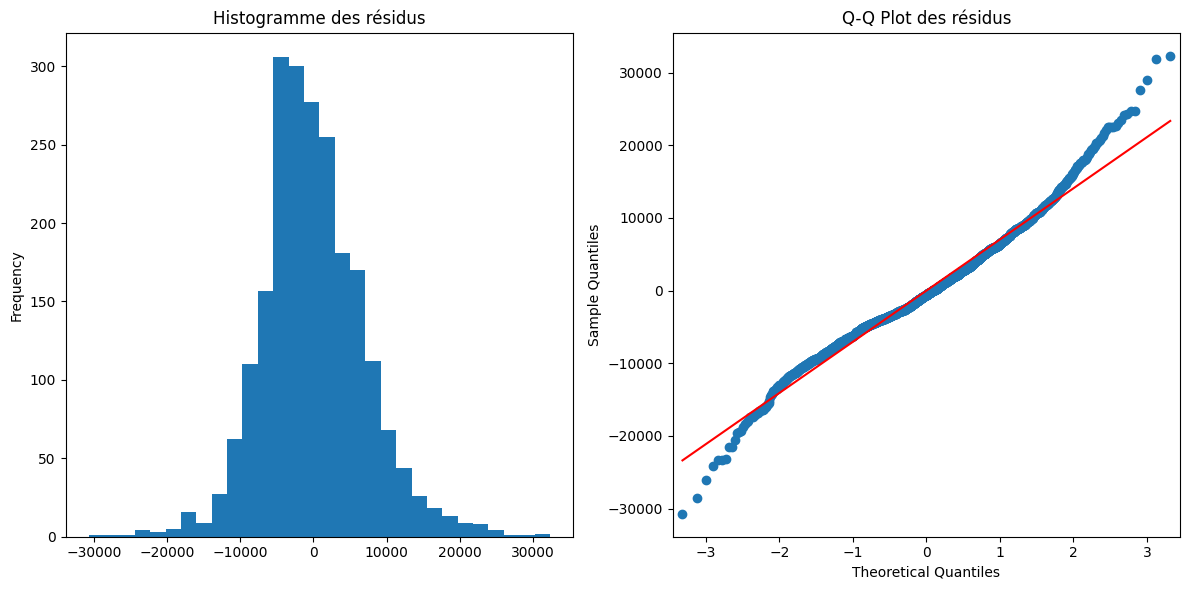

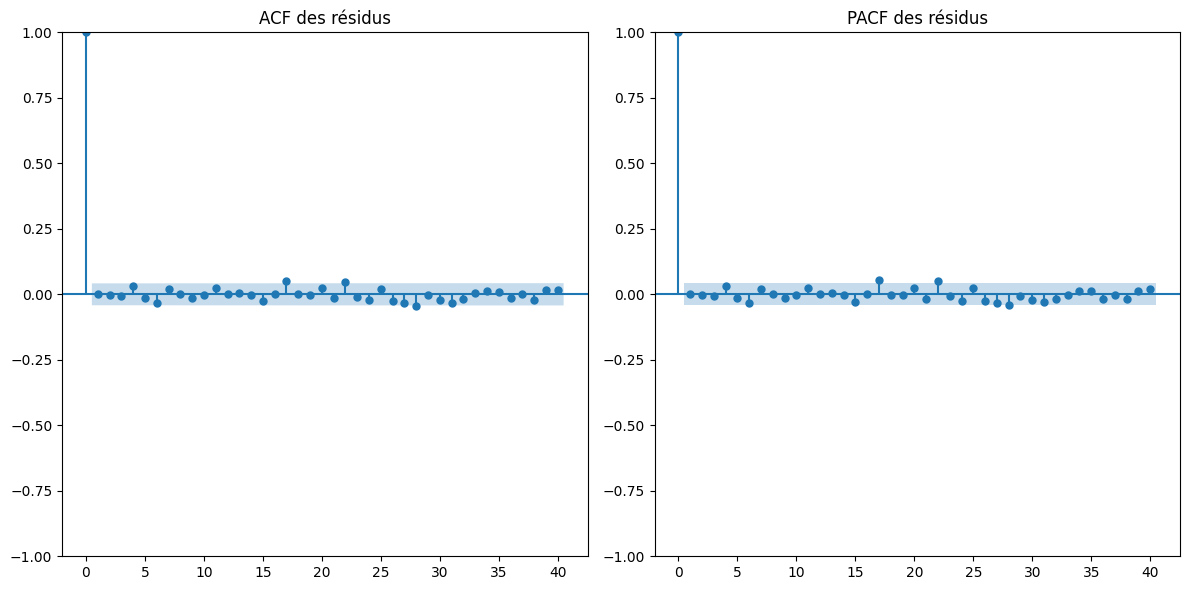


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
model = ARIMA(ts, order=(3, 0, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

**Interprétation**

Le modèle ARIMA(3,0,2) a été sélectionné comme le meilleur modèle avec un AIC de 45057.07, ce qui indique un équilibre optimal entre ajustement et complexité. Ce modèle inclut trois termes auto-régressifs AR(3) et deux termes de moyenne mobile MA(2). Les diagnostics révèlent des résidus indépendants (Ljung-Box \(p = 0.99\)), mais non parfaitement normaux (Jarque-Bera \(p < 0.001\)), avec une légère leptokurtose (kurtosis = 4.47). Le graphique des prédictions dynamiques montre que le modèle capture la tendance globale des ventes, mais les grandes variations restent mal modélisées, comme le confirme un RMSE élevé \(7044.25\).

Les modèles ARIMA ajustés pour les quatre canaux ("Boutiques physiques", "Grands Magasins", "Ventes en ligne" et "Ventes privées") montrent une capacité raisonnable à capturer les tendances globales, mais présentent des limites face aux fortes variations des séries, comme en témoignent les RMSE élevés (entre 5268 et 7044). Les diagnostics révèlent des résidus indépendants mais souvent non normaux, avec une leptokurtose, indiquant des fluctuations extrêmes non modélisées. Bien que les modèles sélectionnés (ARIMA(2,0,2), ARIMA(3,0,2), etc.) minimisent l’AIC, ils pourraient bénéficier de raffinements supplémentaires. Avant de tester un autre modèle, nous allons appliquer un lissage exponentiel simple pour essayer de réduire le bruit et le nombre de lags sur l'ACF/PACF et différencier les séries pour les rendre stationnaire en variance.

## **Approche de lissage et différenciation**

### **Choix de span optimal**

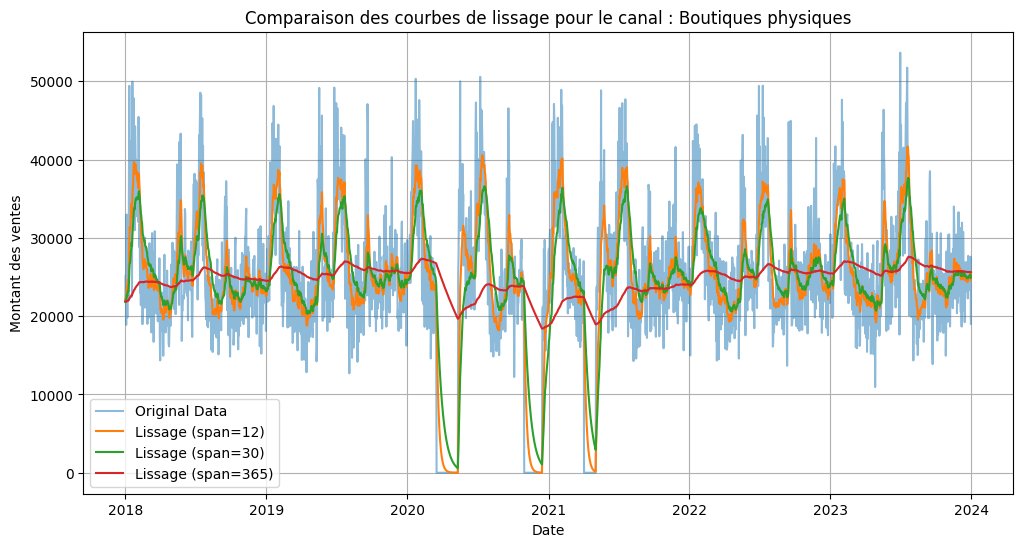

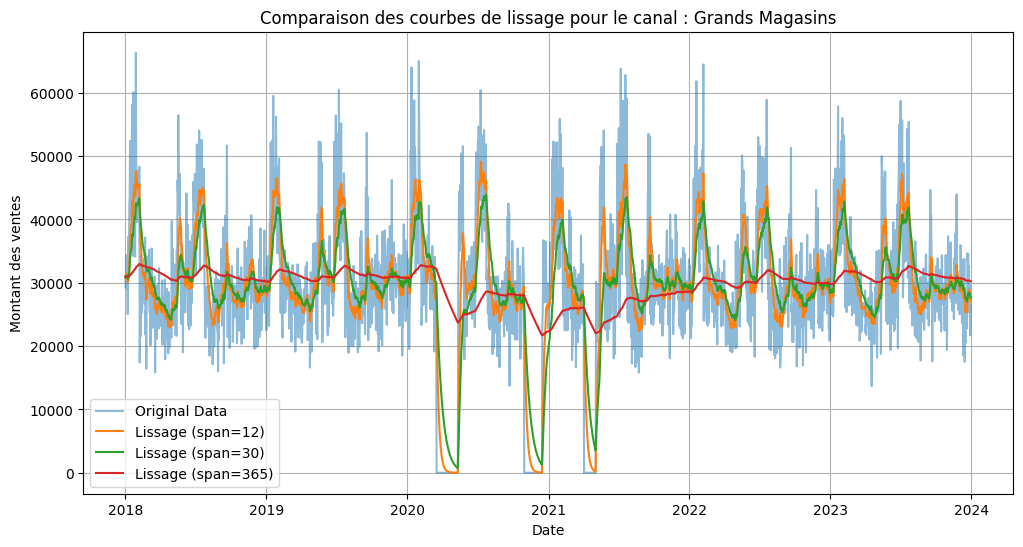

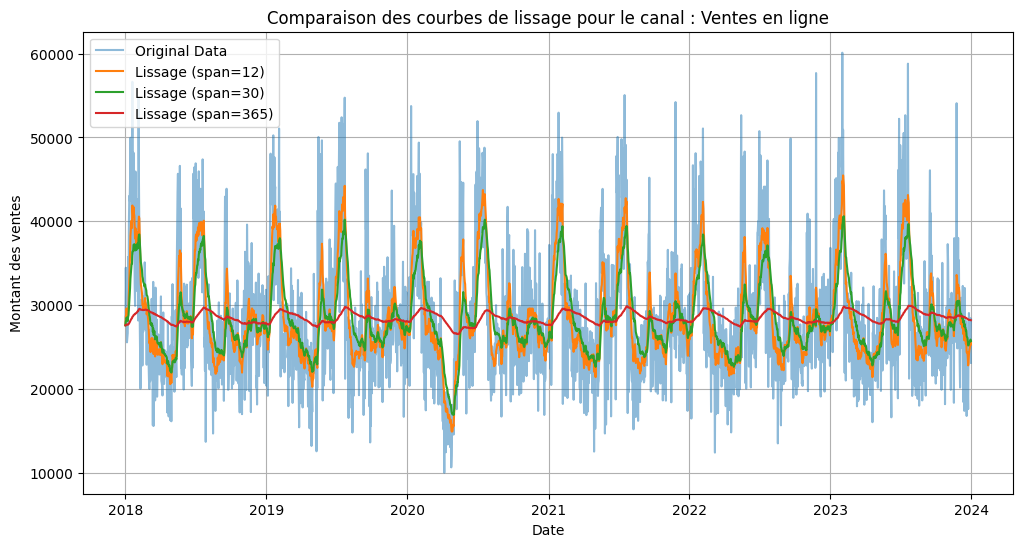

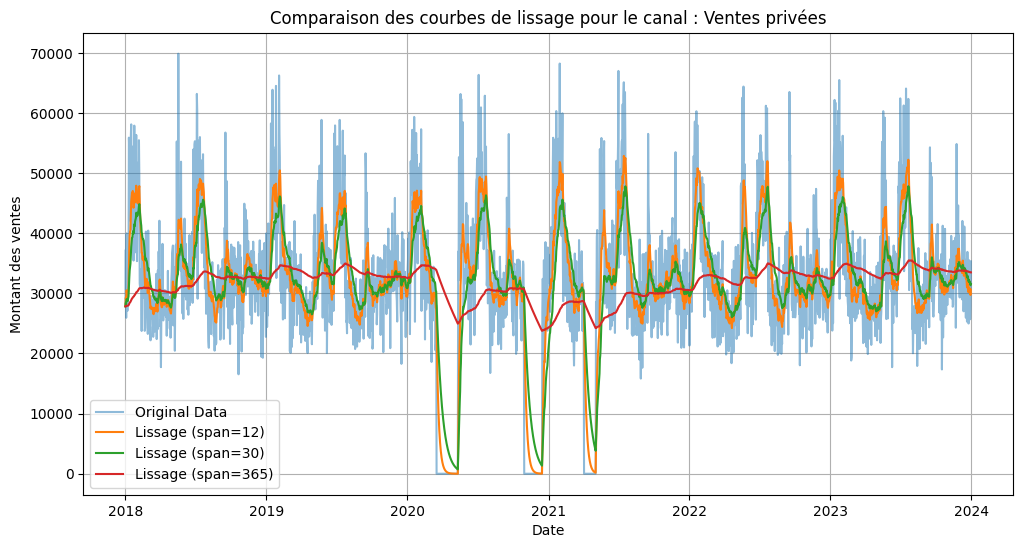

In [ ]:
spans = [12, 30, 365]

for channel in channels:
    sales_by_date = sales_per_channel[channel]
    smoothed_data = {}
    for span in spans:
        smoothed_data[span] = sales_by_date.ewm(span=span, adjust=False).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(sales_by_date.index, sales_by_date.values, label="Original Data", alpha=0.5)

    for span in spans:
        plt.plot(smoothed_data[span].index, smoothed_data[span].values, label=f"Lissage (span={span})")

    plt.title(f"Comparaison des courbes de lissage pour le canal : {channel}")
    plt.xlabel("Date")
    plt.ylabel("Montant des ventes")
    plt.legend()
    plt.grid(True)
    plt.show()


L’analyse des graphiques révèle que des spans plus courts (comme 12 ou 30) suivent davantage les fluctuations rapides des données, capturant des variations de court terme, mais au détriment d’une vision claire de la tendance globale. À l’inverse, un span plus long (365) lisse fortement les données, mettant en évidence la tendance à long terme tout en masquant les variations saisonnières ou irrégulières. La sélection optimale de span dépend de l’objectif : pour des analyses de tendance globale, un span de 365 est pertinent, tandis que des spans plus courts sont mieux adaptés pour analyser les variations périodiques ou détecter des anomalies. Pour ces canaux, un span 12 comme  semble approprié pour équilibrer réactivité et lissage.

### **Stationnarité**


--- Analyse de la stationnarité pour le canal : Boutiques physiques ---



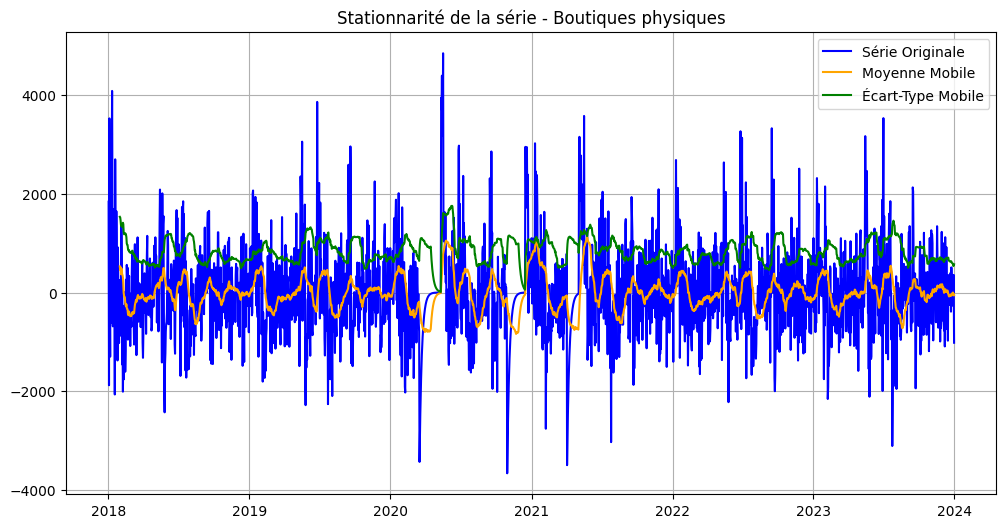

Test ADF :
  - Statistique de test : -13.6699
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.4333463382232248, '5%': -2.86286368244583, '10%': -2.5674746615942903}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Grands Magasins ---



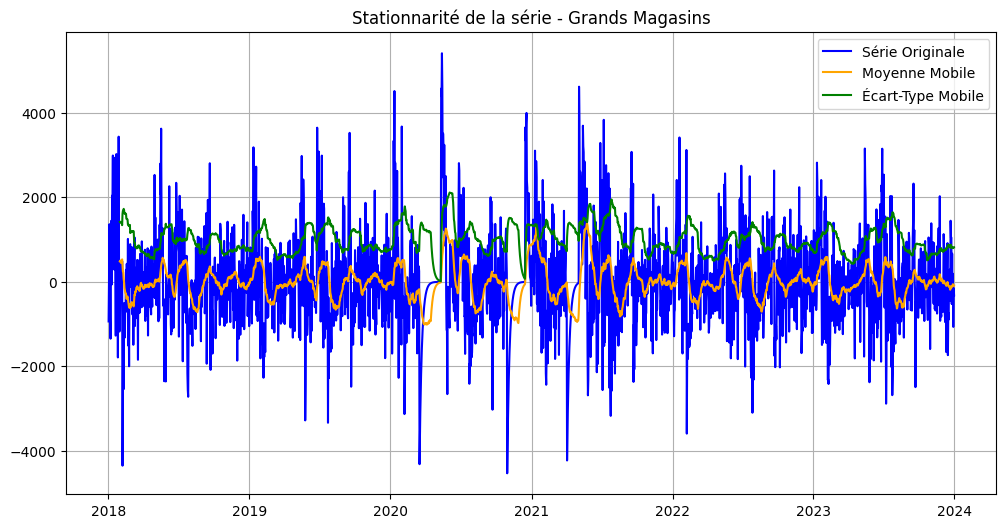

Test ADF :
  - Statistique de test : -15.2417
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.433344965914077, '5%': -2.8628630765096195, '10%': -2.567474338973205}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Ventes en ligne ---



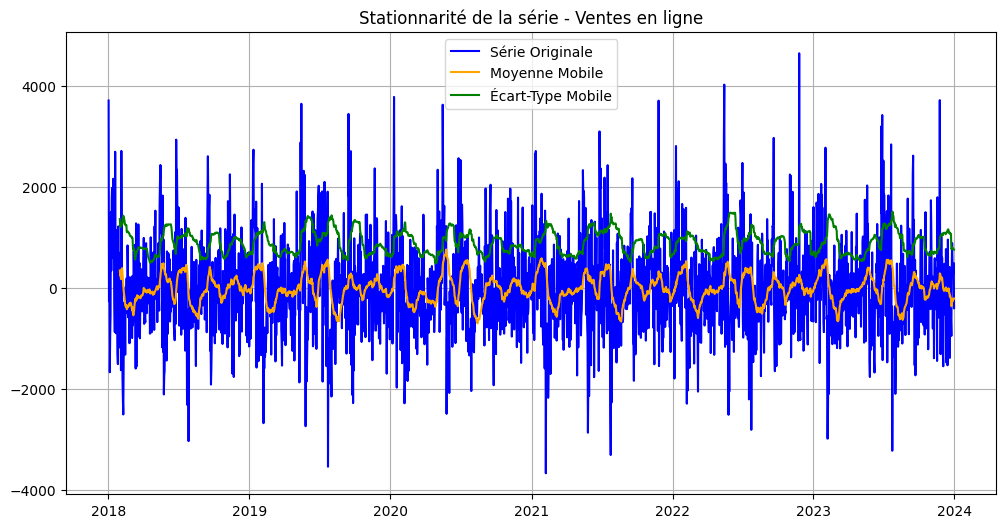

Test ADF :
  - Statistique de test : -17.7910
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.433344965914077, '5%': -2.8628630765096195, '10%': -2.567474338973205}
=> La série est stationnaire (p-valeur <= 0.05).

--- Analyse de la stationnarité pour le canal : Ventes privées ---



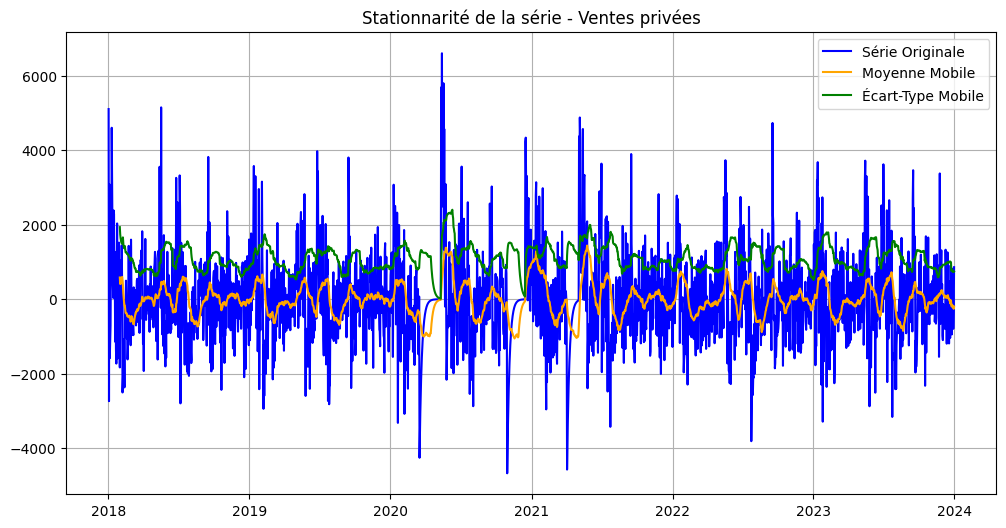

Test ADF :
  - Statistique de test : -15.3431
  - P-valeur : 0.0000
  - Valeurs critiques : {'1%': -3.433344965914077, '5%': -2.8628630765096195, '10%': -2.567474338973205}
=> La série est stationnaire (p-valeur <= 0.05).


In [ ]:
for channel in channels:
  ts = sales_per_channel[channel].dropna()
  ts_smoothed = ts.ewm(span=12).mean()
  ts_smoothed_diff = ts_smoothed.diff().dropna()
  check_stationarity(ts_smoothed.diff(), channel)


Après avoir appliqué une différenciation et un lissage exponentiel simple, les séries semble plus stable, mais ne sont pas encore parfaitement stationnaire en variance. Même après l’application de la différenciation et du lissage exponentiel simple, des variations résiduelles en variance persistent. Cela peut être dû à des facteurs externes ou aux événements liés au covid. Mais ces séries sont plus stables pour une nouvelle modélisation.

### **ACF et PACF**


--- ACF et PACF pour le canal : Boutiques physiques ---


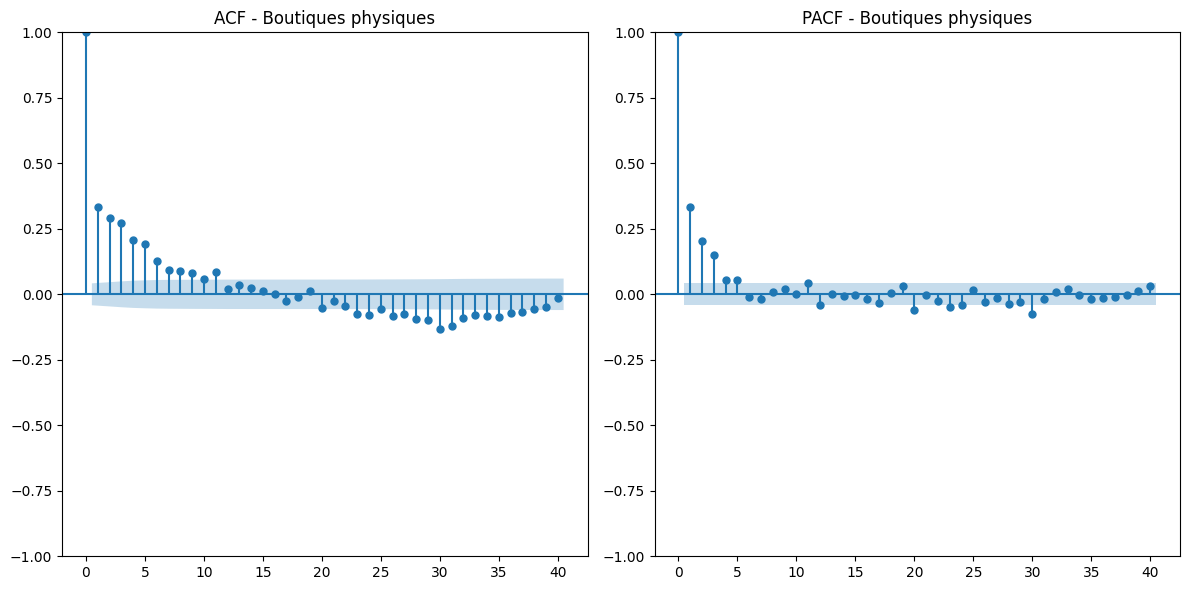


--- ACF et PACF pour le canal : Grands Magasins ---


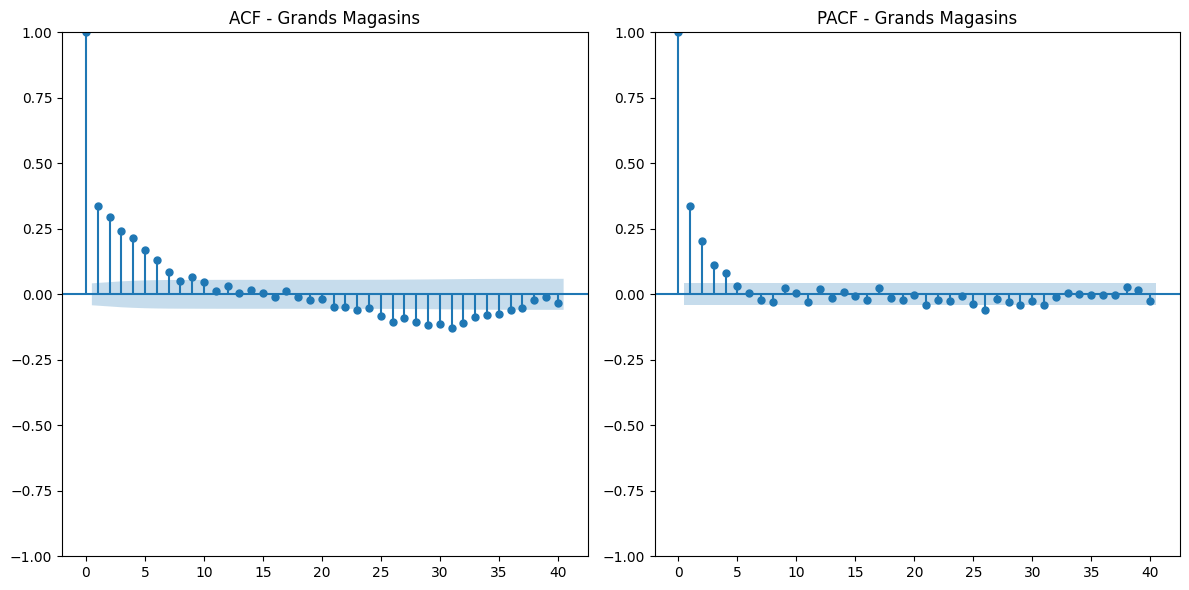


--- ACF et PACF pour le canal : Ventes en ligne ---


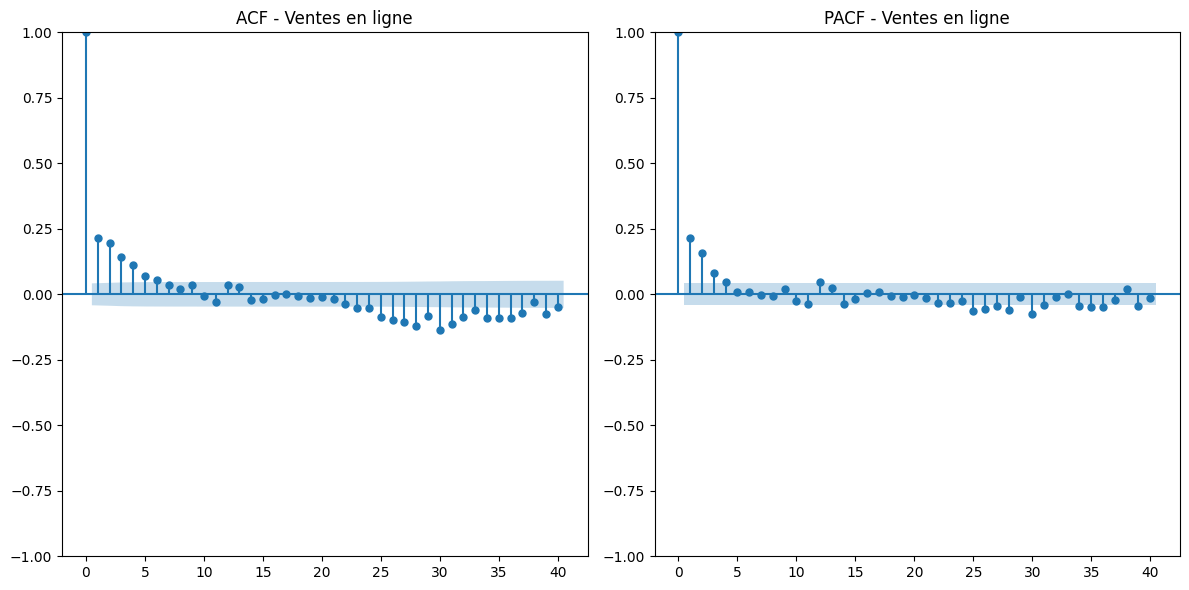


--- ACF et PACF pour le canal : Ventes privées ---


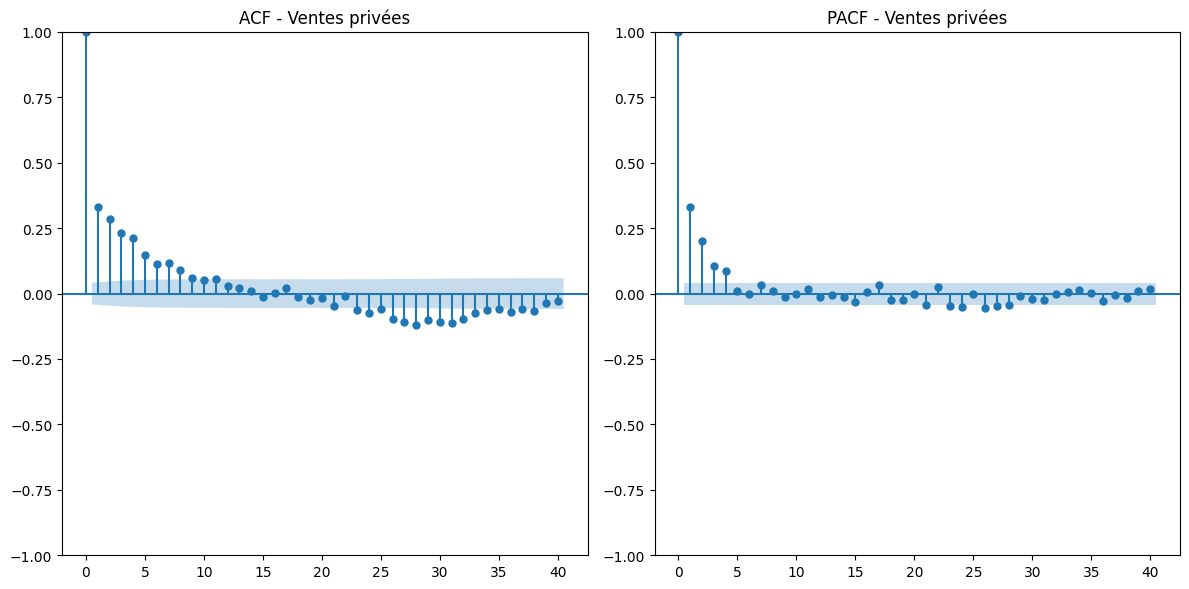

In [ ]:
for channel in channels:
    ts = sales_per_channel[channel].dropna()
    ts_smoothed = ts.ewm(span=12).mean()
    ts_smoothed_diff = ts_smoothed.diff().dropna()
    print(f"\n--- ACF et PACF pour le canal : {channel} ---")
    plot_acf_pacf(ts_smoothed_diff, channel)

Ces graphiques ACF et PACF, obtenus après avoir appliqué un lissage exponentiel simple et différenciation permettent d'observer que l'ACF diminue rapidement et devient non significative après environ 5 à 6 lags. Cette décroissance rapide indique que la série a été bien stationnarisée après l'application du lissage et de la différenciation. Les corrélations au-delà de ces premiers lags sont faibles, suggérant que les dépendances à long terme ont été correctement éliminées par la différenciation. Le PACF montre un pic significatif au lag 1 et quelques autres lags mineurs significatifs jusqu'à environ 3 à 4 lags, puis décroît rapidement. Appliquons à nouveau le même modèle ARIMA avec les mêmes paramètres du gridSearch et vérifions les résultats.

### **ARIMA**

### **Canal : Boutiques physiques**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,1,1) - AIC : 35815.54
ARIMA(1,1,2) - AIC : 35815.09
ARIMA(1,1,3) - AIC : 35712.75
ARIMA(1,1,4) - AIC : 35712.40
ARIMA(2,1,1) - AIC : 35766.93
ARIMA(2,1,2) - AIC : 35814.20
ARIMA(2,1,3) - AIC : 35712.35
ARIMA(2,1,4) - AIC : 35711.11
ARIMA(3,1,1) - AIC : 35719.58
ARIMA(3,1,2) - AIC : 35711.48
ARIMA(3,1,3) - AIC : 35709.93
ARIMA(3,1,4) - AIC : 35711.63
ARIMA(4,1,1) - AIC : 35714.95
ARIMA(4,1,2) - AIC : 35721.01
ARIMA(4,1,3) - AIC : 35713.12
ARIMA(4,1,4) - AIC : 35714.83
ARIMA(5,1,1) - AIC : 35710.58
ARIMA(5,1,2) - AIC : 35712.13
ARIMA(5,1,3) - AIC : 35719.67
ARIMA(5,1,4) - AIC : 35717.10
ARIMA(6,1,1) - AIC : 35712.28
ARIMA(6,1,2) - AIC : 35711.19
ARIMA(6,1,3) - AIC : 35713.42
ARIMA(6,1,4) - AIC : 35717.77
ARIMA(7,1,1) - AIC : 35713.54
ARIMA(7,1,2) - AIC : 35713.19
ARIMA(7,1,3) - AIC : 35709.65
ARIMA(7,1,4) - AIC : 35713.50
ARIMA(8,1,1) - AIC : 35716.80
ARIMA(8,1,2) - AIC : 35712.72
ARIMA(8,1,3) - AIC : 35711.53
ARIMA(8,1,

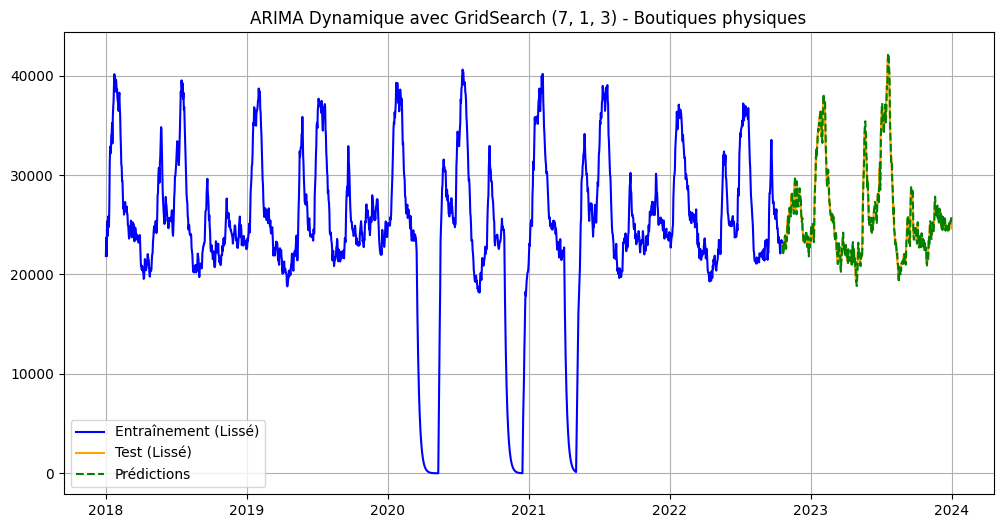

In [ ]:
def gridsearch_arima(ts, p_range, q_range, d=1):
    """
    Effectue une recherche par grille pour trouver les meilleurs paramètres p et q.
    """
    print("\n--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---")
    best_aic = float('inf')
    best_order = None
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(ts, order=(p, d, q))
                model_fit = model.fit()

                aic = model_fit.aic
                results.append(((p, d, q), aic))
                print(f"ARIMA({p},{d},{q}) - AIC : {aic:.2f}")

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) - Échec : {e}")
                continue

    print(f"\nMeilleur modèle : ARIMA{best_order} - AIC : {best_aic:.2f}")
    return best_order

def fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel, span=10):
    """
    Modélisation ARIMA dynamique avec sélection automatique des paramètres p et q
    et lissage exponentiel avant la modélisation.
    """
    ts_smoothed = ts.ewm(span=12).mean()
    ts_smoothed_diff = ts_smoothed.diff().dropna()

    best_order = gridsearch_arima(ts_smoothed_diff, p_range, q_range, d)

    model = ARIMA(ts_smoothed, order=best_order)
    best_model_fit = model.fit()

    print("\n--- Résumé du modèle ---\n")
    print(best_model_fit.summary())

    train_size = int(len(ts_smoothed) * 0.8)
    train, test = ts_smoothed[:train_size], ts_smoothed[train_size:]

    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=1)[0]
        predictions.append(forecast)

        history.append(test.iloc[t])

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"\nRMSE sur les données de test : {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Entraînement (Lissé)', color='blue')
    plt.plot(test.index, test, label='Test (Lissé)', color='orange')
    plt.plot(test.index, predictions, label='Prédictions', color='green', linestyle='--')
    plt.title(f"ARIMA Dynamique avec GridSearch ({best_order[0]}, {best_order[1]}, {best_order[2]}) - {channel}")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


p_range = range(1, 10)
q_range = range(1, 5)
d = 1

channel = 'Boutiques physiques'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel, span=12)


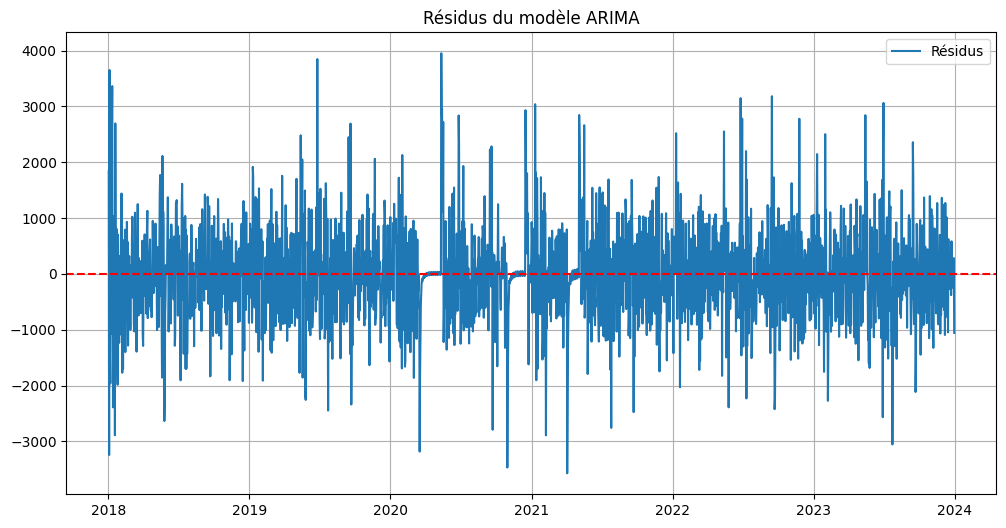

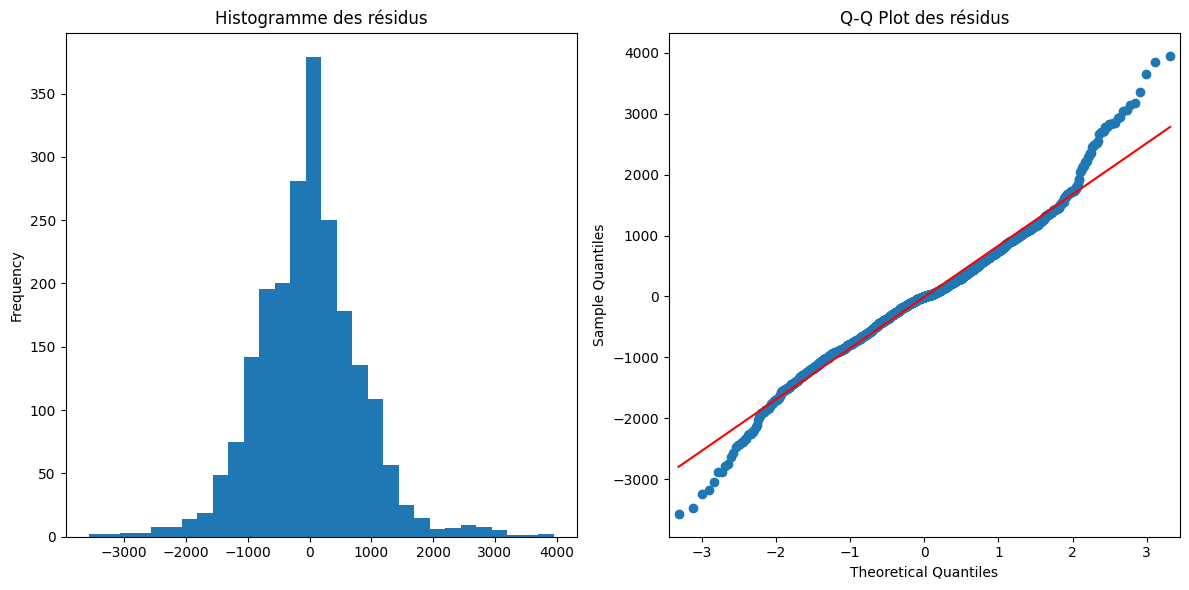

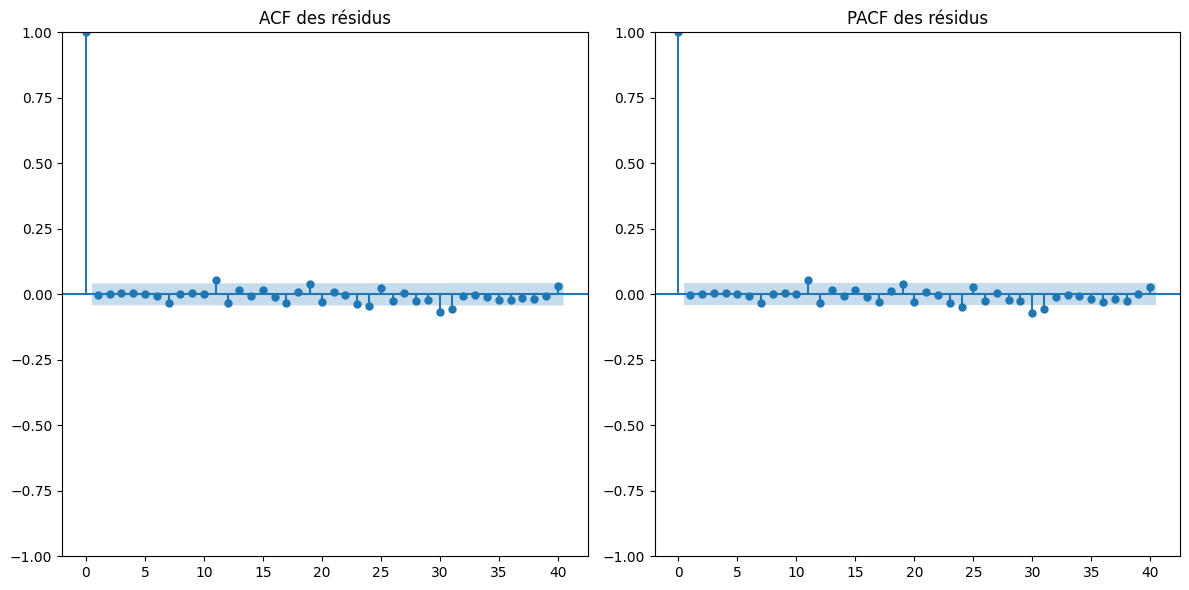


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
def analyze_residuals(model_fit):
    """
    Analyse les résidus d'un modèle ARIMA pour vérifier les hypothèses.
    """
    residuals = model_fit.resid

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Résidus")
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Résidus du modèle ARIMA")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    residuals.plot(kind='hist', bins=30, ax=axes[0], title="Histogramme des résidus")
    sm.qqplot(residuals, line='s', ax=axes[1])
    axes[1].set_title("Q-Q Plot des résidus")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[0], title="ACF des résidus")
    sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axes[1], title="PACF des résidus")
    plt.tight_layout()
    plt.show()

    print("\n--- Interprétation ACF/PACF ---")
    print("=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).")


ts_smoothed = ts.ewm(span=12).mean()
ts_smoothed_diff = ts_smoothed.diff().dropna()
model = ARIMA(ts_smoothed_diff , order=(7, 1, 3))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)


Le modèle ARIMA(7,1,3), sélectionné comme le meilleur modèle via GridSearch avec un AIC de 35709.65, capture efficacement les dynamiques des données pour les "Boutiques physiques" après un lissage exponentiel (span=12) et une différenciation (\(d=1\)). Les coefficients des termes auto-régressifs (AR) et de moyenne mobile (MA) sont significatifs, suggérant une modélisation robuste des relations temporelles complexes. Les termes AR montrent des variations entre positifs et négatifs, indiquant une interaction dynamique entre les observations passées. Les diagnostics révèlent des résidus indépendants (Ljung-Box, \(p = 0.77\)) mais non parfaitement normaux (Jarque-Bera, \(p < 0.001\)), avec une légère leptokurtose (kurtosis = 4.85), suggérant des extrêmes encore présents dans les données. Le graphique montre une bonne correspondance entre les prédictions et les données lissées sur l'ensemble de test, validée par un RMSE très faible (\(823.73\)), ce qui indique une précision élevée dans les prévisions. Bien que ce modèle soit performant, des variations extrêmes dans les données originales pourraient nécessiter une transformation logarithmique pour une meilleure robustesse.

### **Canal : Grands Magasins**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,1,1) - AIC : 36627.56
ARIMA(1,1,2) - AIC : 36516.13
ARIMA(1,1,3) - AIC : 36516.72
ARIMA(1,1,4) - AIC : 36517.82
ARIMA(2,1,1) - AIC : 36557.01
ARIMA(2,1,2) - AIC : 36516.82
ARIMA(2,1,3) - AIC : 36520.14
ARIMA(2,1,4) - AIC : 36523.97
ARIMA(3,1,1) - AIC : 36530.47
ARIMA(3,1,2) - AIC : 36561.00
ARIMA(3,1,3) - AIC : 36521.22
ARIMA(3,1,4) - AIC : 36522.24
ARIMA(4,1,1) - AIC : 36517.82
ARIMA(4,1,2) - AIC : 36518.22
ARIMA(4,1,3) - AIC : 36524.40
ARIMA(4,1,4) - AIC : 36525.75
ARIMA(5,1,1) - AIC : 36517.72
ARIMA(5,1,2) - AIC : 36524.76
ARIMA(5,1,3) - AIC : 36529.60
ARIMA(5,1,4) - AIC : 36525.60
ARIMA(6,1,1) - AIC : 36519.68
ARIMA(6,1,2) - AIC : 36527.58
ARIMA(6,1,3) - AIC : 36524.93
ARIMA(6,1,4) - AIC : 36538.29
ARIMA(7,1,1) - AIC : 36520.60
ARIMA(7,1,2) - AIC : 36523.66
ARIMA(7,1,3) - AIC : 36529.11
ARIMA(7,1,4) - AIC : 36521.03
ARIMA(8,1,1) - AIC : 36520.76
ARIMA(8,1,2) - AIC : 36528.88
ARIMA(8,1,3) - AIC : 36525.32
ARIMA(8,1,

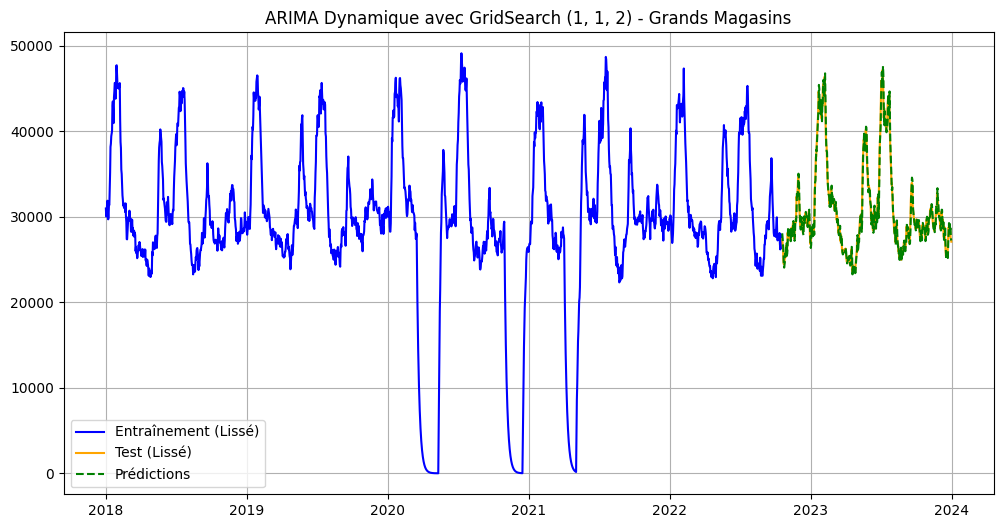

In [ ]:
channel = 'Grands Magasins'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel, span=12)

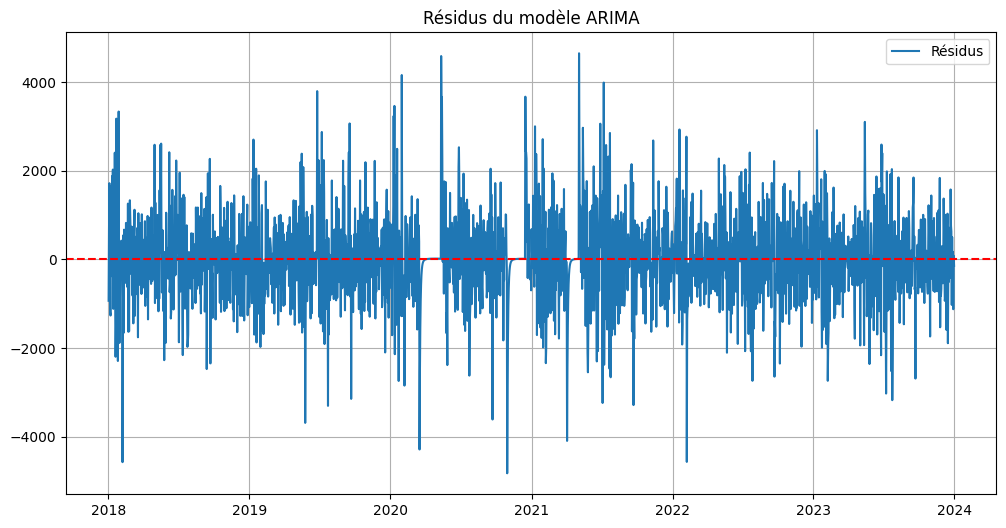

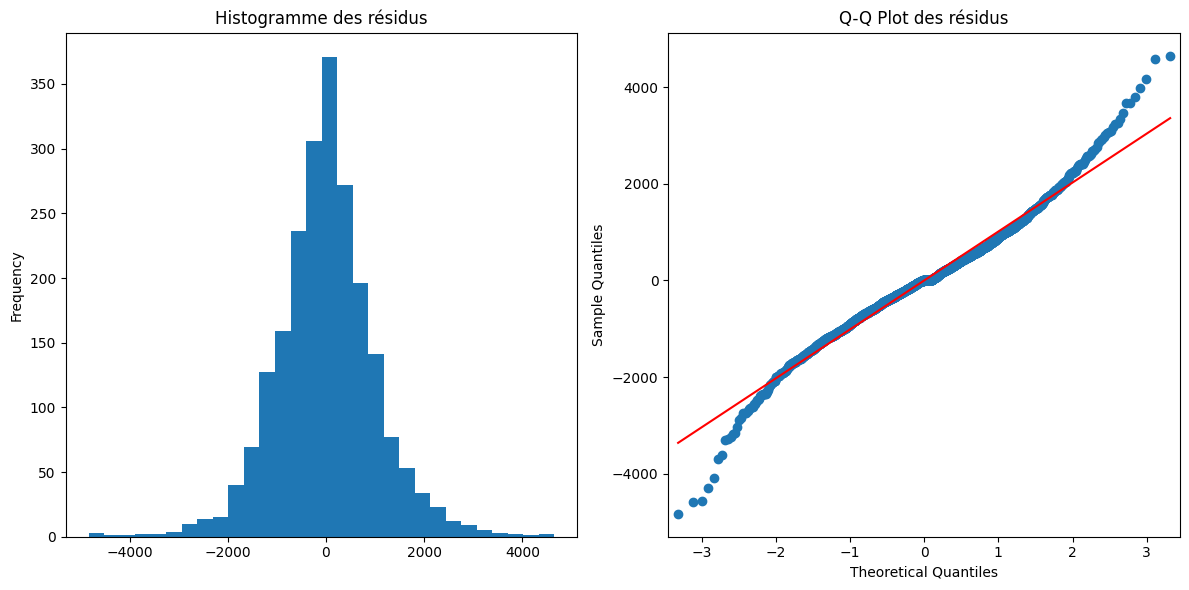

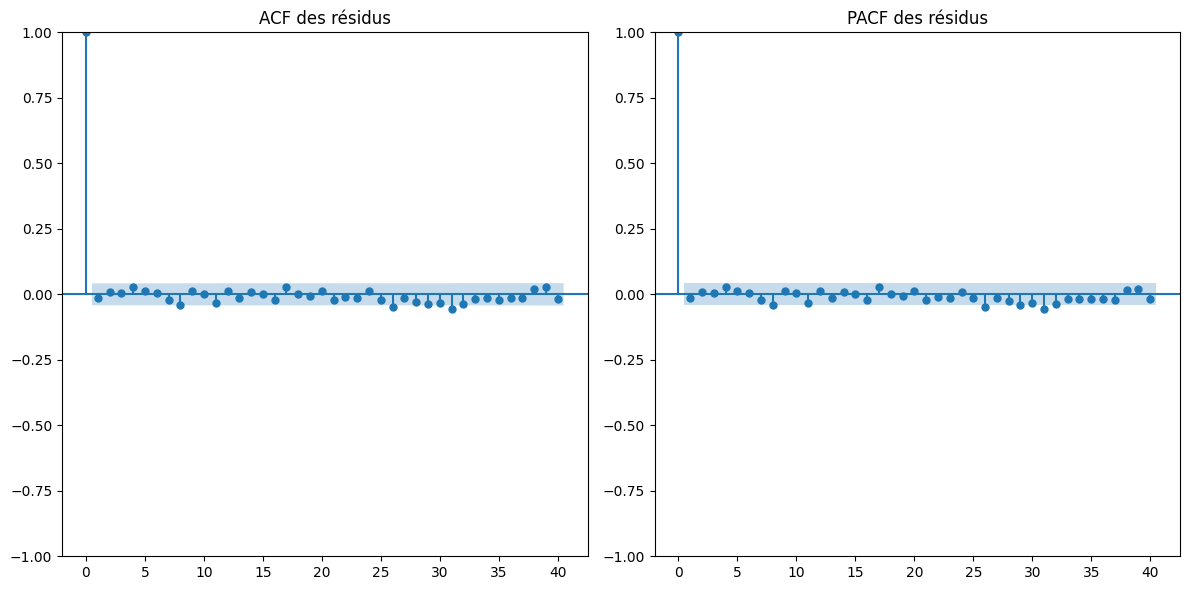


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
ts_smoothed = ts.ewm(span=12).mean()
ts_smoothed_diff = ts_smoothed.diff().dropna()
model = ARIMA(ts_smoothed_diff , order=(1, 1, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

Le modèle ARIMA(1,1,2), sélectionné comme meilleur modèle avec un AIC de 36516.13, montre une capacité à capturer les dynamiques de la série temporelle "Grands Magasins" après lissage (span=12) et différenciation (\(d=1\)). Le terme \(AR(1) = 0.7916\) indique une forte dépendance temporelle entre les observations consécutives, tandis que \(MA(1) = -0.5942\) ajuste efficacement les erreurs passées. Le second terme \(MA(2) = 0.0333\) est faiblement significatif (p-value = 0.067), ce qui suggère un impact limité. Les diagnostics révèlent des résidus légèrement corrélés (Ljung-Box \(p = 0.04\)) et une distribution non parfaitement normale (Jarque-Bera \(p < 0.001\)) avec une leptokurtose (kurtosis = 5.20), suggérant la présence d’extrêmes. Le graphique montre que les prédictions suivent globalement les tendances des données lissées, bien que certaines variations ne soient pas complètement capturées. Avec un RMSE de 932.90, ce modèle est performant pour les prévisions à court terme.

### **Canal : Ventes en ligne**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,1,1) - AIC : 36167.63
ARIMA(1,1,2) - AIC : 36221.09
ARIMA(1,1,3) - AIC : 36098.56
ARIMA(1,1,4) - AIC : 36100.50
ARIMA(2,1,1) - AIC : 36115.11
ARIMA(2,1,2) - AIC : 36098.63
ARIMA(2,1,3) - AIC : 36103.54
ARIMA(2,1,4) - AIC : 36205.79
ARIMA(3,1,1) - AIC : 36103.05
ARIMA(3,1,2) - AIC : 36100.73
ARIMA(3,1,3) - AIC : 36165.56
ARIMA(3,1,4) - AIC : 36106.44
ARIMA(4,1,1) - AIC : 36100.51
ARIMA(4,1,2) - AIC : 36108.07
ARIMA(4,1,3) - AIC : 36115.04
ARIMA(4,1,4) - AIC : 36106.88
ARIMA(5,1,1) - AIC : 36102.34
ARIMA(5,1,2) - AIC : 36104.74
ARIMA(5,1,3) - AIC : 36107.68
ARIMA(5,1,4) - AIC : 36110.33
ARIMA(6,1,1) - AIC : 36104.18
ARIMA(6,1,2) - AIC : 36112.95
ARIMA(6,1,3) - AIC : 36103.44
ARIMA(6,1,4) - AIC : 36109.77
ARIMA(7,1,1) - AIC : 36106.18
ARIMA(7,1,2) - AIC : 36113.47
ARIMA(7,1,3) - AIC : 36108.14
ARIMA(7,1,4) - AIC : 36107.68
ARIMA(8,1,1) - AIC : 36108.09
ARIMA(8,1,2) - AIC : 36114.09
ARIMA(8,1,3) - AIC : 36108.99
ARIMA(8,1,

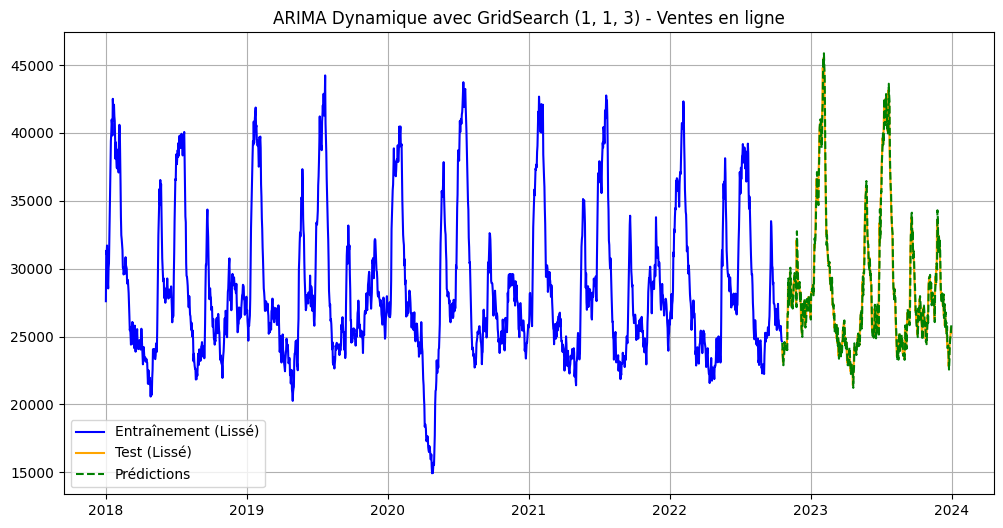

In [ ]:
channel = 'Ventes en ligne'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel, span=12)

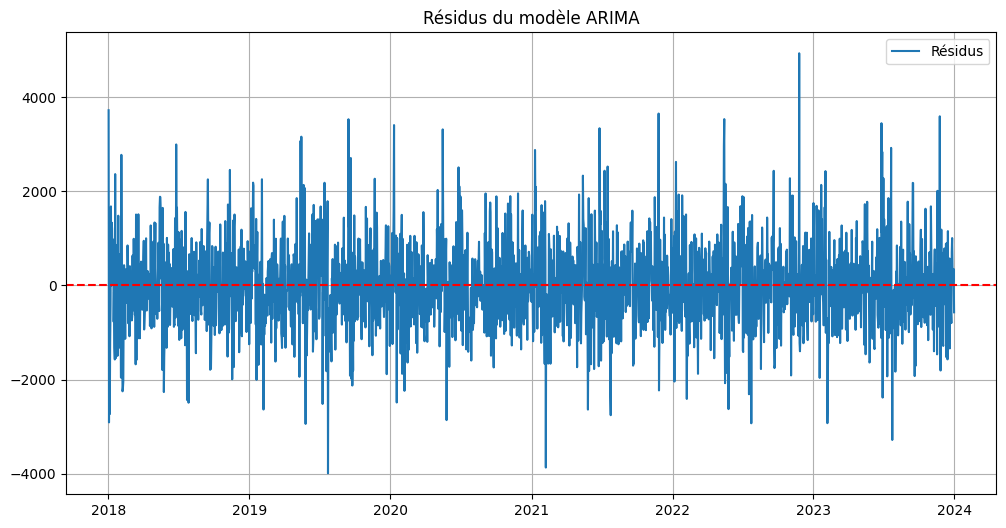

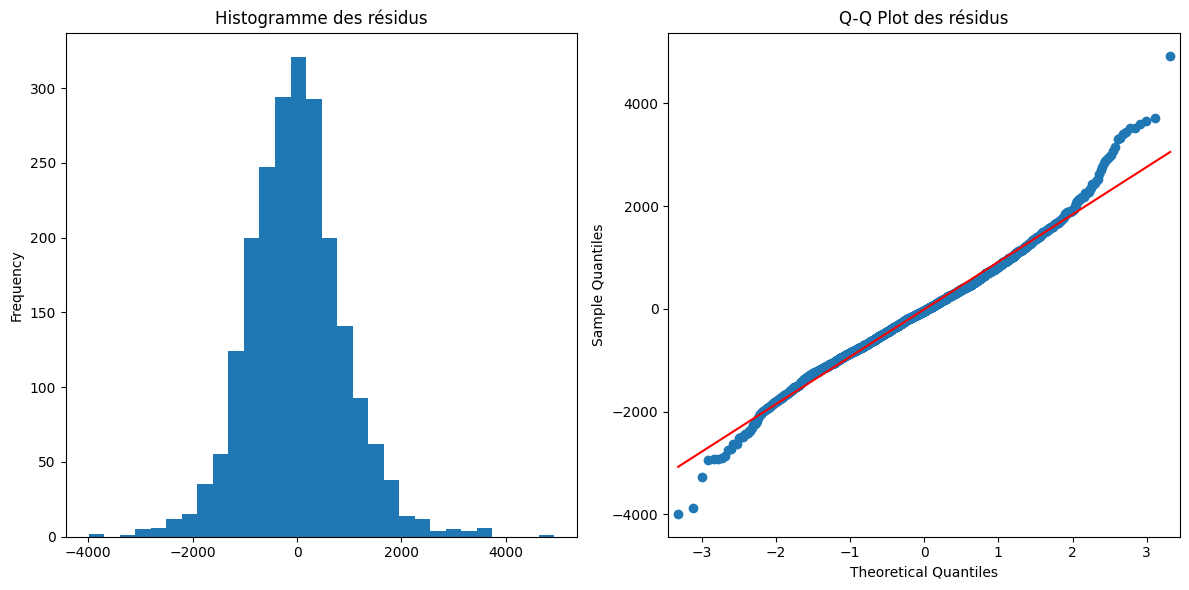

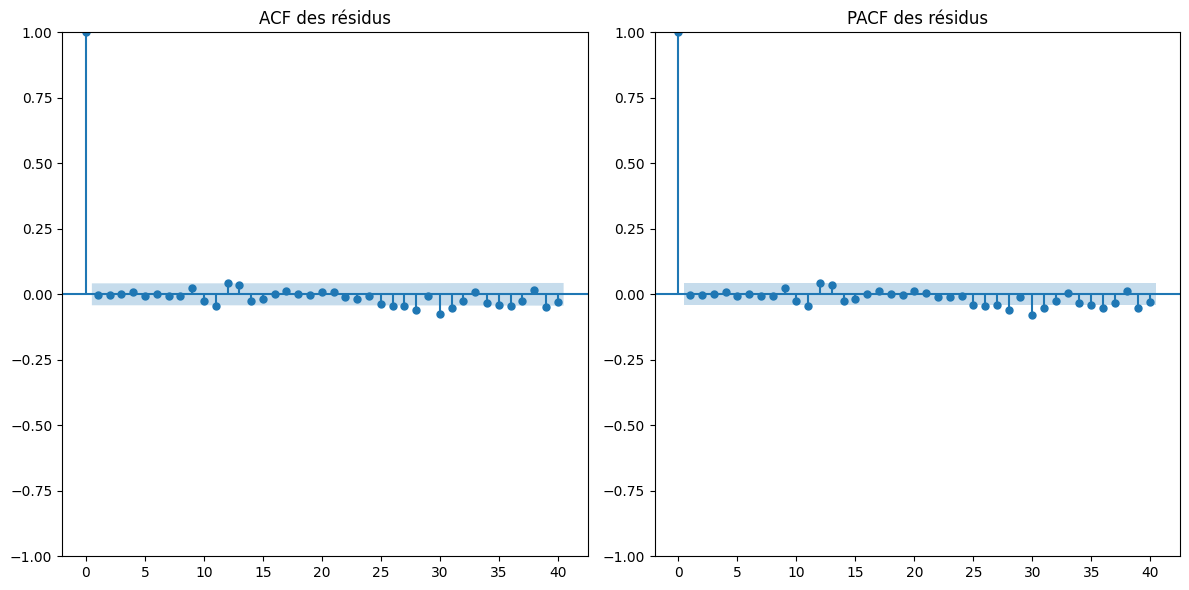


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
ts_smoothed = ts.ewm(span=12).mean()
ts_smoothed_diff = ts_smoothed.diff().dropna()
model = ARIMA(ts_smoothed_diff , order=(1, 1, 3))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

Le modèle ARIMA(1,1,3), sélectionné avec un AIC de 36098.56, modélise efficacement les dynamiques de la série temporelle "Ventes en ligne" après un lissage (span=12) et une différenciation (\(d=1\)). Le coefficient \(AR(1) = 0.6668\) montre une dépendance modérée avec les valeurs précédentes, tandis que les coefficients \(MA(1) = -0.4943\), \(MA(2) = 0.0331\) et \(MA(3) = 0.0134\) ajustent les erreurs passées, bien que \(MA(2)\) et \(MA(3)\) ne soient pas significatifs. Les diagnostics révèlent des résidus indépendants (Ljung-Box \(p = 0.82\)) mais non parfaitement normaux (Jarque-Bera \(p < 0.001\)), avec une légère leptokurtose (kurtosis = 4.45), ce qui peut indiquer la persistance de quelques extrêmes. Le graphique montre que le modèle capture bien les tendances globales des données lissées, avec une légère sous-estimation de certaines variations rapides. Avec un RMSE de 933.54, ce modèle est performant pour les prévisions à court terme.

### **Canal : Ventes privées**


--- Recherche des meilleurs paramètres ARIMA (p, d, q) ---
ARIMA(1,1,1) - AIC : 37018.36
ARIMA(1,1,2) - AIC : 36915.20
ARIMA(1,1,3) - AIC : 36917.47
ARIMA(1,1,4) - AIC : 37012.43
ARIMA(2,1,1) - AIC : 36953.41
ARIMA(2,1,2) - AIC : 36916.57
ARIMA(2,1,3) - AIC : 37020.47
ARIMA(2,1,4) - AIC : 37014.37
ARIMA(3,1,1) - AIC : 36931.33
ARIMA(3,1,2) - AIC : 36957.64
ARIMA(3,1,3) - AIC : 37011.94
ARIMA(3,1,4) - AIC : 36922.87
ARIMA(4,1,1) - AIC : 36916.27
ARIMA(4,1,2) - AIC : 36918.96
ARIMA(4,1,3) - AIC : 36950.16
ARIMA(4,1,4) - AIC : 36916.41
ARIMA(5,1,1) - AIC : 36918.03
ARIMA(5,1,2) - AIC : 36922.11
ARIMA(5,1,3) - AIC : 36931.16
ARIMA(5,1,4) - AIC : 36931.90
ARIMA(6,1,1) - AIC : 36920.01
ARIMA(6,1,2) - AIC : 36923.99
ARIMA(6,1,3) - AIC : 36917.82
ARIMA(6,1,4) - AIC : 36927.67
ARIMA(7,1,1) - AIC : 36921.48
ARIMA(7,1,2) - AIC : 36925.48
ARIMA(7,1,3) - AIC : 36920.78
ARIMA(7,1,4) - AIC : 36927.70
ARIMA(8,1,1) - AIC : 36923.00
ARIMA(8,1,2) - AIC : 36925.00
ARIMA(8,1,3) - AIC : 36920.02
ARIMA(8,1,

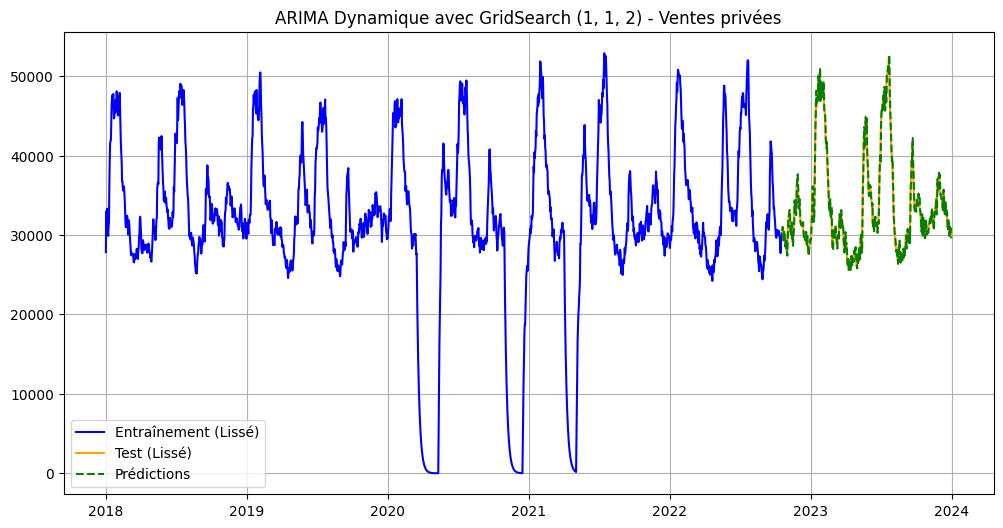

In [ ]:
channel = 'Ventes privées'
ts = sales_per_channel[channel].dropna()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')

fit_arima_dynamic_with_gridsearch(ts, p_range, q_range, d, channel, span=12)

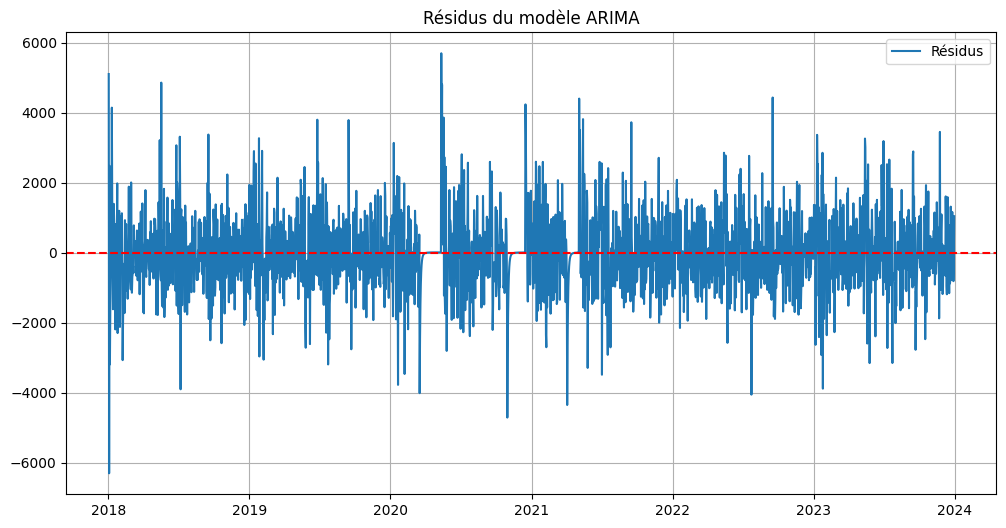

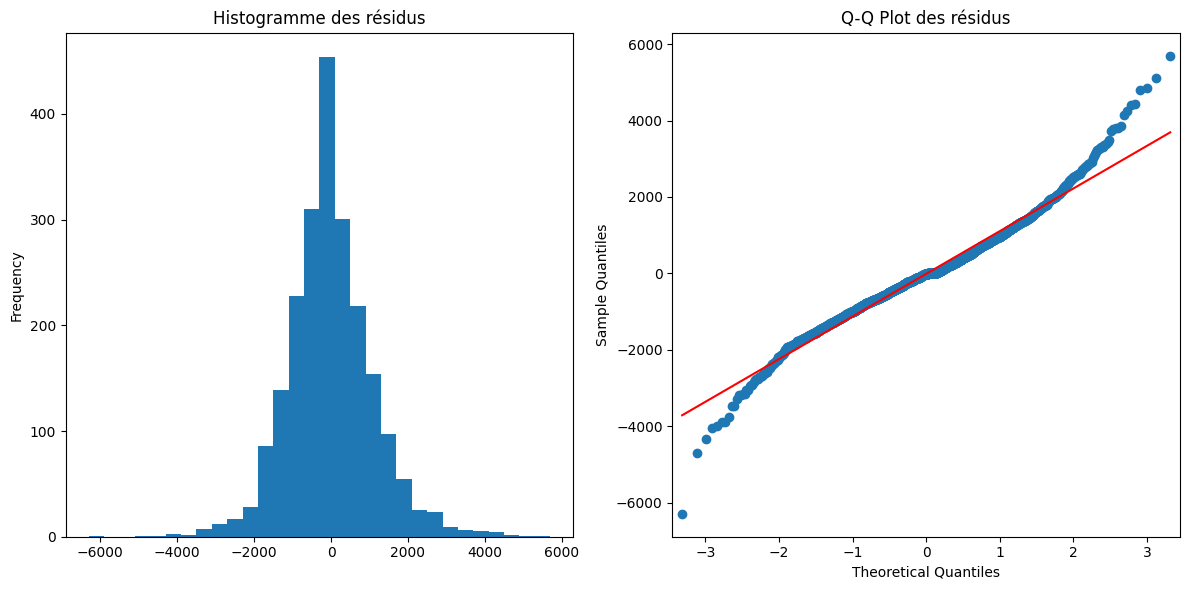

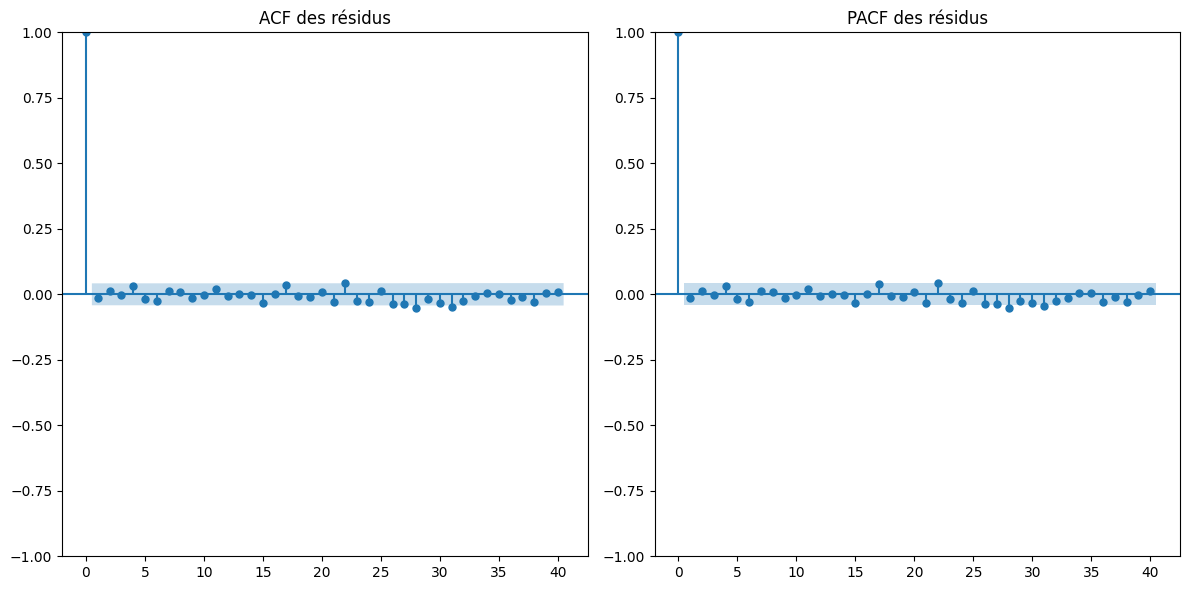


--- Interprétation ACF/PACF ---
=> Vérifiez que les résidus n'ont pas d'autocorrélation significative (les points doivent être dans la bande de confiance).


In [ ]:
ts_smoothed = ts.ewm(span=12).mean()
ts_smoothed_diff = ts_smoothed.diff().dropna()
model = ARIMA(ts_smoothed_diff , order=(1, 1, 2))
best_model_fit = model.fit()
analyze_residuals(best_model_fit)

Le modèle ARIMA(1,1,2), sélectionné comme meilleur modèle pour les "Ventes privées" avec un AIC de 36915.20, capture les dynamiques après lissage (span=12) et différenciation (\(d=1\)). Le coefficient \(AR(1) = 0.8105\) indique une forte dépendance temporelle, tandis que \(MA(1) = -0.5726\) ajuste efficacement les erreurs passées. Cependant, \(MA(2) = -0.0113\) n'est pas significatif (\(p = 0.531\)), ce qui suggère qu'il n'apporte pas de valeur ajoutée au modèle. Les diagnostics révèlent des résidus indépendants (Ljung-Box \(p = 0.85\)) mais une distribution non normale (Jarque-Bera \(p < 0.001\)), avec une leptokurtose marquée (kurtosis = 5.29), suggérant des extrêmes persistants dans les données. Le graphique montre une bonne correspondance entre les prédictions et les données lissées, bien que certaines variations rapides soient sous-estimées. Avec un RMSE de 1091.09, le modèle est relativement plus performant.

### **Conclusion Générale et Recommandations**

Ce projet a permis d’analyser et de modéliser les séries temporelles des ventes selon différents canaux ("Boutiques physiques", "Grands magasins", "Ventes en ligne", et "Ventes privées") à l’aide de techniques avancées, incluant le lissage exponentiel et les modèles ARIMA. Les principales conclusions sont les suivantes :

1. **Qualité des Modèles** :
   - Les modèles ARIMA utilisés après lissage (span=12) et différenciation (\(d=1\)) ont globalement montré de bonnes performances dans la capture des dynamiques des séries temporelles, avec des RMSE variant selon les canaux.
   - Certains modèles, comme ARIMA(7,1,3) pour les "Boutiques physiques" et ARIMA(1,1,2) pour les "Ventes privées", ont affiché une forte capacité à reproduire les tendances générales.

2. **Lissage exponentiel** :
   - Le lissage exponentiel a été utile pour réduire la volatilité des séries brutes, permettant aux modèles ARIMA de mieux capturer les dynamiques sous-jacentes.
   - Cependant, le lissage introduit une perte d’information sur les variations rapides, qui pourrait être critique pour certains canaux.

3. **Limites identifiées** :
   - Certains canaux montrent une saisonnalité évidente, qui n’a pas été directement intégrée dans les modèles ARIMA utilisés. Cela a limité leur capacité à prédire certaines fluctuations saisonnières importantes.
   - Les distributions des résidus montrent une leptokurtose (extrêmes fréquents), suggérant qu’il pourrait être nécessaire d’explorer d’autres approches pour améliorer les prévisions.

**Recommandations**

1. **Intégration de la Saisonnalité** :
   - Utiliser des modèles SARIMA ou SARIMAX pour inclure explicitement des termes saisonniers (\(S\)), car la saisonnalité est visible dans certains canaux, en particulier pour les ventes en ligne et en boutiques physiques.

2. **Transformation des Données** :
   - Tester des transformations logarithmiques ou des techniques robustes pour réduire l’impact des extrêmes et améliorer la normalité des résidus.

3. **Approches Alternatives** :
   - Explorer des approches basées sur le machine learning (ex. prophet) ou des réseaux neuronaux récurrents (LSTM, GRU), particulièrement si les données montrent des interactions complexes non capturées par ARIMA.

   En somme, bien que les techniques employées offrent des résultats intéressants, des améliorations sont possibles grâce à une meilleure prise en compte des spécificités des données et à l'exploration de méthodes plus modernes et adaptées aux cas complexes.


   En conclusion, ce projet sur l'analyse des ventes dans le secteur du luxe a permis de mettre en lumière les dynamiques complexes et les facteurs influençant les performances commerciales. Grâce à une base de données complète et cohérente, nous avons pu réaliser une exploration approfondie des tendances, des variations saisonnières, et des perturbations exceptionnelles, telles que celles liées à la pandémie.
  L'application de modèles statistiques et prédictifs, comme l'ARIMA, a enrichi notre compréhension des comportements de vente .
  Enfin, ce travail collaboratif a mis en avant l'importance d'une approche méthodique, depuis la collecte et le nettoyage des données jusqu’à leur interprétation. Ce projet constitue une base solide pour des analyses futures.
  Merci pour votre attention!